# Caso de Análisis: Solicitud de tarjeta de crédito

El archivo **credito.txt** es una base de datos de 654 solicitudes anonimizadas de **tarjeta de crédito**. Contiene 10 variables predictoras (A1, A2, A3, …), 6 de ellas continuas y las demás binarias. En la última columna se encuentra la variable de respuesta (R1), que indica si la solicitud fue aceptada (1) o rechazada (0).

Para llevar a cabo esta tarea **se construye un modelo de clasificación con target binario que permita predecir si la solicitud para el uso de una tarjeta de crédito debe ser aprobada o no.**

# Instalar las dependencias y definiciones de funciones

In [1]:
#!pip install -r requirements.txt

## Cargar Librerías

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
palette = sns.color_palette("pastel")

import warnings
warnings.filterwarnings("ignore")

from pycaret.classification import *
import shap

## Definición de funciones

In [3]:
def cross_target(data,var,target):
    """Calcula los porcentajes de conversión del target por cada categoria de la variable"""
    
    base = data[[var,target]]#.fillna("NULOS")
    print("----------------------------------------------------------------")
    print("---- Var: ",var)
    print(pd.concat([pd.DataFrame(base[:][var].value_counts(dropna=False).index, columns = ['Atributo']),
           pd.DataFrame(base[:][var].value_counts(dropna=False).values, columns = ['Cantidad']),
           pd.DataFrame(100*base[:][var].value_counts(dropna=False).values/len(base), columns = ['%Total'])], axis = 1))
    
    temp = pd.DataFrame(np.array(base.groupby(var, as_index = False, axis = 0)[target].mean()), 
                         columns = [var,"% ratio_conv"])
    temp["% ratio_conv"] = temp["% ratio_conv"]*100
    temp = temp.sort_values(by = ['% ratio_conv'], ascending = [False])
    print("")
    print(temp)


def plot_graph_initial(df, meta):
  """Graficos para el analisis univariado"""
  
  import matplotlib
  matplotlib.rcParams.update({'font.size': 16})
  for i in range(len(meta)) :
      plt.figure(figsize=(35,7))
      v=meta.iloc[i].variable #print(meta.iloc[i].variable)
      t=meta.iloc[i].tipo
      if (t.__class__.__name__=="CategoricalDtype"):
          #colors = sns.color_palette("Set2")
          fa=df[v].value_counts() 
          fr=fa/len(df[v]) 
          #Barras
          plt.subplot(1,2,1)
          ax=plt.bar(fa.index,fa)
          plt.xticks(fa.index,rotation=0)
          plt.title('Distribution of '+v+' categories')
          
          total = len(df[v])
          for p in ax:
            percentage = f'{100 * p.get_height() / total:.1f}%'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            plt.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)
          plt.grid(False)

          # Pie
          plt.subplot(1, 2, 2)
          plt.pie(fr, labels=fr.index, autopct='%1.1f%%', shadow=True, startangle=90)
          plt.legend(fr.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
          
          plt.title('Pie chart of ' + v)
          plt.grid(False)

      else:
          #Histograma
          plt.subplot(1,2,1)
          plt.hist(df[v].dropna(),bins=100)
          plt.title('Histogram of '+v) 
          #Boxplot
          plt.subplot(1,2,2)
          plt.boxplot(df[v])
          plt.title('Boxplot of '+v)
          #Guardar
          #plt.savefig(v+".jpg")
      plt.show()



def plot_graph_bivariable(df2, meta, y):
    """Graficos para el analisis bivariado"""

    import matplotlib
    matplotlib.rcParams.update({'font.size': 16})
    for i in range(len(meta)):
        plt.figure(figsize=(35, 7))
        v = meta.iloc[i].variable  # print(meta.iloc[i].variable)
        t = meta.iloc[i].tipo
        if v == y:
            break
        print(v)
        if t == "category":
            g = df2.groupby([df2[y], v]).size().unstack(0)
            tf = g[1] / (g[0] + g[1])
            c1 = g[0]
            c2 = g[1]
            width = 0.9  # the width of the bars: can also be len(x) sequence

            p1 = plt.bar(g.index, c1, width)
            p2 = plt.bar(g.index, c2, width, bottom=c1)

            plt.ylabel('Freq')
            plt.title('Bivariate: ' + v)
            plt.xticks(g.index, rotation=0)
            plt.legend((p1[0], p2[0]), ('0', '1'), loc='lower left', bbox_to_anchor=(1, 1))

            tf_line = plt.twinx().plot(tf.values, linestyle='-', linewidth=2.0, color='black', marker="o")
            plt.ylabel(y)
            
            # Añadir anotaciones para la línea
            for x, val in enumerate(tf.values):
                plt.text(x, val, f'{val:.2f}', color='black', fontsize=12, ha='center', va='bottom')
            
            
            #plt.grid(False)
            # Guardar
            # plt.savefig("Bivariado_" + v + ".jpg")
        else:
            d, bins = pd.qcut(df2[v], 10, retbins=True, duplicates='drop', labels=False)
            g = df2.groupby([y, d]).size().unstack(0)
            N = len(g)
            mMeans = g[0]
            wMeans = g[1]
            tf = g[1] / (g[0] + g[1])
            ind = np.arange(N)  # the x locations for the groups

            width = 0.9  # the width of the bars: can also be len(x) sequence
            p1 = plt.bar(ind, mMeans, width)
            p2 = plt.bar(ind, wMeans, width, bottom=mMeans)

            plt.ylabel('Freq')
            plt.xlabel("Deciles " + v)
            plt.title('Bivariate: ' + v + " vs " + y)
            bin_labels = [f'{bins[i]:.2f} - {bins[i+1]:.2f}' for i in range(len(bins) - 1)]
            plt.xticks(ind, bin_labels, rotation=0)
            plt.legend((p1[0], p2[0]), ('0', '1'), loc='lower left', bbox_to_anchor=(1, 1))

            tf_line = plt.twinx().plot(tf.values, linestyle='-', linewidth=2.0, color='black')
            plt.ylabel(y)
            
            # Añadir anotaciones para la línea
            for x, val in enumerate(tf.values):
                plt.text(x, val, f'{val:.2f}', color='black', fontsize=12, ha='center', va='bottom')
            
            #plt.grid(False)
            # Guardar
            # plt.savefig("Bivariado_" + v + ".jpg")
        plt.show()



def fx_porc_missings(data, only_missings = False):
    """Calcula los porcentajes de valores vacios en cada variable"""
    
    df_vars_missings = pd.concat([pd.DataFrame(data.isnull().sum(), columns = ['n_nulos']),
                                  pd.DataFrame(100*data.isnull().sum()/len(data), columns = ['%Total'])], axis = 1)
    if only_missings:
        return(df_vars_missings[df_vars_missings["n_nulos"]!=0])
    else:
        return(df_vars_missings)


def clean_outlier_perc(df, column, value_perc):
  """Genera el reemplazo de valores outliers superiores por un percentile personalizado"""
  
  top_value = df[column].quantile(value_perc) 
  df.loc[df[column] >= top_value, column] = top_value


def correlation_heatmap(df):
    """Función para plotear las correlaciones de las variables de un dataset"""
    
    _ , ax = plt.subplots(figsize =(10, 6))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        fmt='.2f',
        linewidths=0.1,
        vmax=1.0,
        vmin=-1.0, 
        linecolor='white',
        annot_kws={'fontsize':8}
    )
    plt.title('Pearson Correlation of Features', y=1.05, size=12)
    plt.show()

# Entendimiento inicial de los datos

## Lectura y Validación de datos

Ruta donde se encuentra alojado el dataset del caso

In [4]:
url_data='data/'

**Lectura y carga de la data**

In [5]:
dfCredito=pd.read_csv(url_data+'credito.txt', delimiter='\t')

**Validar la correcta lectura del dataframe**

Se observa que se tienen **654 filas** y **10 columnas predictoras** de los tipos float64(3), int64(7). El target si bien esta representado con un valor numérica indica si la solicitud fue aceptada (1) o rechazada (0).

In [6]:
dfCredito.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      654 non-null    int64  
 1   A2      654 non-null    float64
 2   A3      654 non-null    float64
 3   A8      654 non-null    float64
 4   A9      654 non-null    int64  
 5   A10     654 non-null    int64  
 6   A11     654 non-null    int64  
 7   A12     654 non-null    int64  
 8   A14     654 non-null    int64  
 9   A15     654 non-null    int64  
 10  R1      654 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 56.3 KB


Mostrar los 5 primeros registros

In [7]:
dfCredito.head(5)

A1     A2     A3    A8  A9  A10  A11  A12  A14  A15  R1
0   1  30.83  0.000  1.25   1    0    1    1  202    0   1
1   0  58.67  4.460  3.04   1    0    6    1   43  560   1
2   0  24.50  0.500  1.50   1    1    0    1  280  824   1
3   1  27.83  1.540  3.75   1    0    5    0  100    3   1
4   1  20.17  5.625  1.71   1    1    0    1  120    0   1

## Estudiar las dimensiones del dataset

Se puede consultar la dimensión del dataset usando el atributo `shape`

In [8]:
dfCredito.shape

(654, 11)

Se tienen 654 filas y 11 columnas (10 variables predictoras y el target).

No se tiene un **id** correspondiente a cada solicitud. Por lo que, cada fila se considera como una solicitud única.

## Evaluar el tipo de Problema

**Se trata de un caso de aprendizaje supervisado de clasificación con target binario que permita predecir si la solicitud para el uso de una tarjeta de crédito debe ser aprobada o no**

In [9]:
dfCredito.head(5)

A1     A2     A3    A8  A9  A10  A11  A12  A14  A15  R1
0   1  30.83  0.000  1.25   1    0    1    1  202    0   1
1   0  58.67  4.460  3.04   1    0    6    1   43  560   1
2   0  24.50  0.500  1.50   1    1    0    1  280  824   1
3   1  27.83  1.540  3.75   1    0    5    0  100    3   1
4   1  20.17  5.625  1.71   1    1    0    1  120    0   1

El Target correspondiente es la variable $R1$ que indica si la solicitud fue aceptada (1) o rechazada (0). En este escenario no será necesario el armado del target.

## Describir el Dataset

La función `describe()` da varios valores de estadística del dataframe y excluye los valores NaN.

A pesar que se trata de variables anonimizadas. El primer alcance descriptivo de los datos es el siguiente:

* No se tiene presencia de valores nulos ya que cada columna mantiene la misma cantidad de valores
* La desviación estandar de las variables: **A2, A14, A15** es alta posiblemente debido a la presencia de valores de gran valor alejados de la distribución habitual de los datos
* El resto de variable: **A3, A8, A11** si bien sus desviaciones estandar son moderadas, sus valores máximos se encuentran lejos del percentil 75, lo que puede indicar de la misma forma la presencia de valores outliers.

In [10]:
dfCredito.describe()

A1          A2          A3          A8          A9         A10  \
count  654.000000  654.000000  654.000000  654.000000  654.000000  654.000000   
mean     0.689602   31.578349    4.830558    2.241690    0.535168    0.561162   
std      0.463010   11.981789    5.023295    3.369197    0.499143    0.496625   
min      0.000000   13.750000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000   22.580000    1.040000    0.165000    0.000000    0.000000   
50%      1.000000   28.460000    2.855000    1.000000    1.000000    1.000000   
75%      1.000000   38.250000    7.437500    2.615000    1.000000    1.000000   
max      1.000000   80.250000   28.000000   28.500000    1.000000    1.000000   

              A11         A12          A14            A15          R1  
count  654.000000  654.000000   654.000000     654.000000  654.000000  
mean     2.498471    0.538226   180.084098    1012.730887    0.452599  
std      4.965655    0.498918   168.315719    5249.320660    0.498129  
min      0.000000    0.000000     0.000000       0.000000    0.000000  
25%      0.000000    0.000000    70.750000       0.000000    0.000000  
50%      0.000000    1.000000   160.000000       5.000000    0.000000  
75%      3.000000    1.000000   271.000000     399.000000    1.000000  
max     67.000000    1.000000  2000.000000  100000.000000    1.000000

# Data Wrangling

## Registros Repetidos

Veamos las dimensiones del DataFrame. Luego analicemos la presencia de valores duplicados.

In [11]:
dfCredito.shape

(654, 11)

In [12]:
dfCredito.drop_duplicates(inplace = True)

In [13]:
dfCredito.shape

(654, 11)

Podemos observar que no se tienen valores duplicados porque después de ejecutar la función `drop_duplicates()` las dimensiones del DataFrame no variaron.

## Renombramiento de variables

Las variables estan anonimizadas por lo que al no tener más conocimiento de estas, no se renombrarán. Sin embargo con más conocimiento de negocio se recomienda llevar a cabo este procedimiento a fin de una mejor interpretabilidad.

## Remover nulos

`Pandas` toma a los valores `NaN` y `None` como valores ausentes. La función `pandas.isnull()` se puede usar para determinar si existen valores ausentes en los datos.

In [14]:
# Se hace uso de la función fx_porc_missings

fx_porc_missings(dfCredito, only_missings=True)

Empty DataFrame
Columns: [n_nulos, %Total]
Index: []

Se observan que todo el dataframe no contiene variables con valores nulos

## Creación de nuevas variables

Para este caso no es posible crear nuevas variables ya que se necesita más conocimiento de las variables

# EDA

Se realiza una copia del dataset original

In [15]:
df_analisis = dfCredito.copy()

In [16]:
df_analisis.describe()

A1          A2          A3          A8          A9         A10  \
count  654.000000  654.000000  654.000000  654.000000  654.000000  654.000000   
mean     0.689602   31.578349    4.830558    2.241690    0.535168    0.561162   
std      0.463010   11.981789    5.023295    3.369197    0.499143    0.496625   
min      0.000000   13.750000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000   22.580000    1.040000    0.165000    0.000000    0.000000   
50%      1.000000   28.460000    2.855000    1.000000    1.000000    1.000000   
75%      1.000000   38.250000    7.437500    2.615000    1.000000    1.000000   
max      1.000000   80.250000   28.000000   28.500000    1.000000    1.000000   

              A11         A12          A14            A15          R1  
count  654.000000  654.000000   654.000000     654.000000  654.000000  
mean     2.498471    0.538226   180.084098    1012.730887    0.452599  
std      4.965655    0.498918   168.315719    5249.320660    0.498129  
min      0.000000    0.000000     0.000000       0.000000    0.000000  
25%      0.000000    0.000000    70.750000       0.000000    0.000000  
50%      0.000000    1.000000   160.000000       5.000000    0.000000  
75%      3.000000    1.000000   271.000000     399.000000    1.000000  
max     67.000000    1.000000  2000.000000  100000.000000    1.000000

## Analisis Preliminar Univariado (Variables Categóricas)

Se realiza un análisis general para las variables **$'A1','A9','A10','A12'$**

Estas variables son representadas númericamente, se transforma a una variable categórica para una mejor interpretación.

In [17]:
dicc_cambio_var_bin = {0: 'Valor_0',
                       1: 'Valor_1'}

### Análisis de la variable A1

In [18]:
df_analisis['A1'] = df_analisis['A1'].map(dicc_cambio_var_bin)

In [19]:
groupped_data = df_analisis.groupby(['A1'],as_index=False).agg({'R1': 'count'})
groupped_data.rename(columns={'R1':'nro_solicitudes'},inplace=True)
groupped_data.sort_values(by=['nro_solicitudes'],ascending=False,inplace=True)
groupped_data["% Total"] = groupped_data['nro_solicitudes']/len(df_analisis)*100
groupped_data

A1  nro_solicitudes    % Total
1  Valor_1              451  68.960245
0  Valor_0              203  31.039755

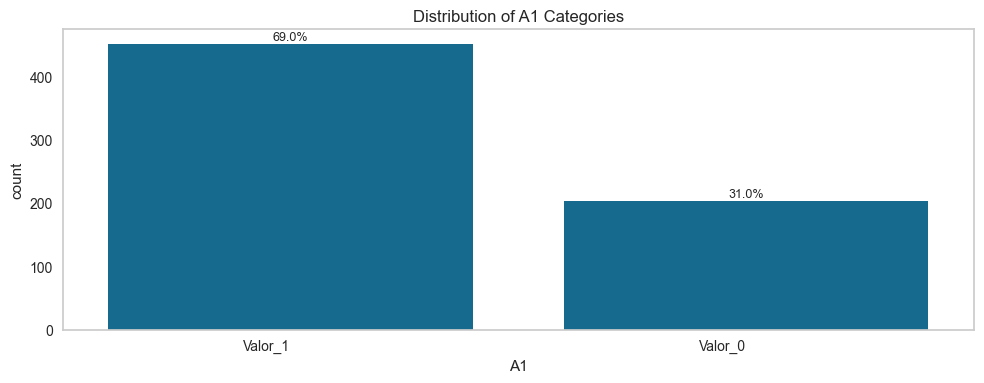

In [20]:
plt.figure(figsize=(10,4))
ax=sns.countplot(data=df_analisis,x='A1',
                 order=df_analisis['A1'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center',fontsize=9)

plt.title("Distribution of A1 Categories")
plt.tight_layout()
plt.grid(False)
plt.show()

La categoría **valor_1 (69%)** presenta mayor cantidad de solicitudes que la categoría **valor_0 (31%**) como se muestra en la gráfica. 38% más entre una categoría u otra, una cantidad considerable teniendo en cuenta que se cuenta con 654 filas.

### Análisis de la variable A9

In [21]:
df_analisis['A9'] = df_analisis['A9'].map(dicc_cambio_var_bin)

In [22]:
groupped_data = df_analisis.groupby(['A9'],as_index=False).agg({'R1': 'count'})
groupped_data.rename(columns={'R1':'nro_solicitudes'},inplace=True)
groupped_data.sort_values(by=['nro_solicitudes'],ascending=False,inplace=True)
groupped_data["% Total"] = groupped_data['nro_solicitudes']/len(df_analisis)*100
groupped_data

A9  nro_solicitudes   % Total
1  Valor_1              350  53.51682
0  Valor_0              304  46.48318

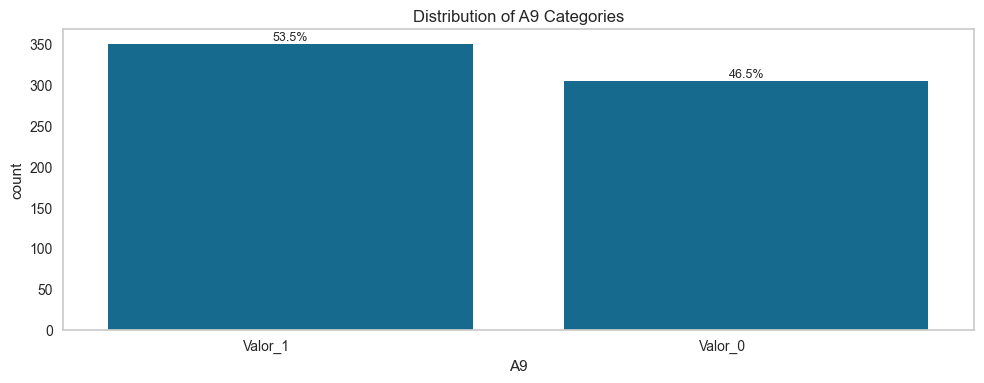

In [23]:
plt.figure(figsize=(10,4))
ax=sns.countplot(data=df_analisis,x='A9',
                 order=df_analisis['A9'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center',fontsize=9)
    
plt.title("Distribution of A9 Categories")
plt.tight_layout()
plt.grid(False)
plt.show()

La categoría **valor_1 (54%)** presenta mayor cantidad de solicitudes que la categoría **valor_0 (46%**) como se muestra en la gráfica. 7% más entre una categoría u otra.

### Análisis de la variable A10

In [24]:
df_analisis['A10'] = df_analisis['A10'].map(dicc_cambio_var_bin)

In [25]:
groupped_data = df_analisis.groupby(['A10'],as_index=False).agg({'R1': 'count'})
groupped_data.rename(columns={'R1':'nro_solicitudes'},inplace=True)
groupped_data.sort_values(by=['nro_solicitudes'],ascending=False,inplace=True)
groupped_data["% Total"] = groupped_data['nro_solicitudes']/len(df_analisis)*100
groupped_data

A10  nro_solicitudes    % Total
1  Valor_1              367  56.116208
0  Valor_0              287  43.883792

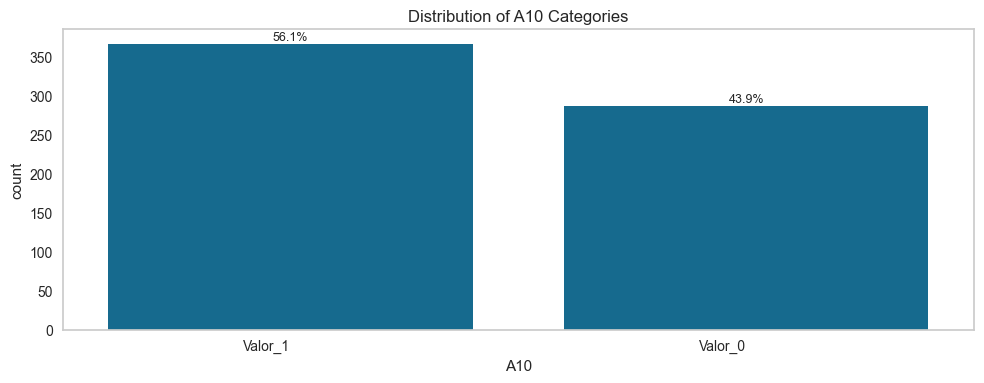

In [26]:
plt.figure(figsize=(10,4))
ax=sns.countplot(data=df_analisis,x='A10',
                 order=df_analisis['A10'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center',fontsize=9)

plt.title("Distribution of A10 Categories")
plt.tight_layout()
plt.grid(False)
plt.show()

La categoría **valor_1 (56%)** presenta mayor cantidad de solicitudes que la categoría **valor_0 (44%**) como se muestra en la gráfica. 12% más entre una categoría u otra.

### Análisis de la variable A12

In [27]:
df_analisis['A12'] = df_analisis['A12'].map(dicc_cambio_var_bin)

In [28]:
groupped_data = df_analisis.groupby(['A12'],as_index=False).agg({'R1': 'count'})
groupped_data.rename(columns={'R1':'nro_solicitudes'},inplace=True)
groupped_data.sort_values(by=['nro_solicitudes'],ascending=False,inplace=True)
groupped_data["% Total"] = groupped_data['nro_solicitudes']/len(df_analisis)*100
groupped_data

A12  nro_solicitudes   % Total
1  Valor_1              352  53.82263
0  Valor_0              302  46.17737

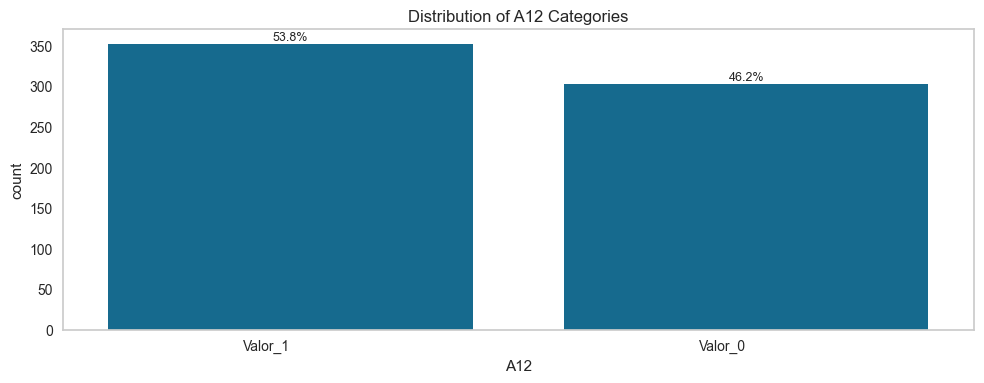

In [29]:
plt.figure(figsize=(10,4))
ax=sns.countplot(data=df_analisis,x='A12',
                 order=df_analisis['A12'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center',fontsize=9)

plt.title("Distribution of A12 Categories")
plt.tight_layout()
plt.grid(False)
plt.show()

La categoría **valor_1 (54%)** presenta mayor cantidad de solicitudes que la categoría **valor_0 (46%**) como se muestra en la gráfica. 8% más aproximadamente entre una categoría u otra.

## Analisis Preliminar Univariado (Variables Numéricas)

Se realiza un análisis general para las variables **$'A2','A3','A8','A11','A14','A15'$**

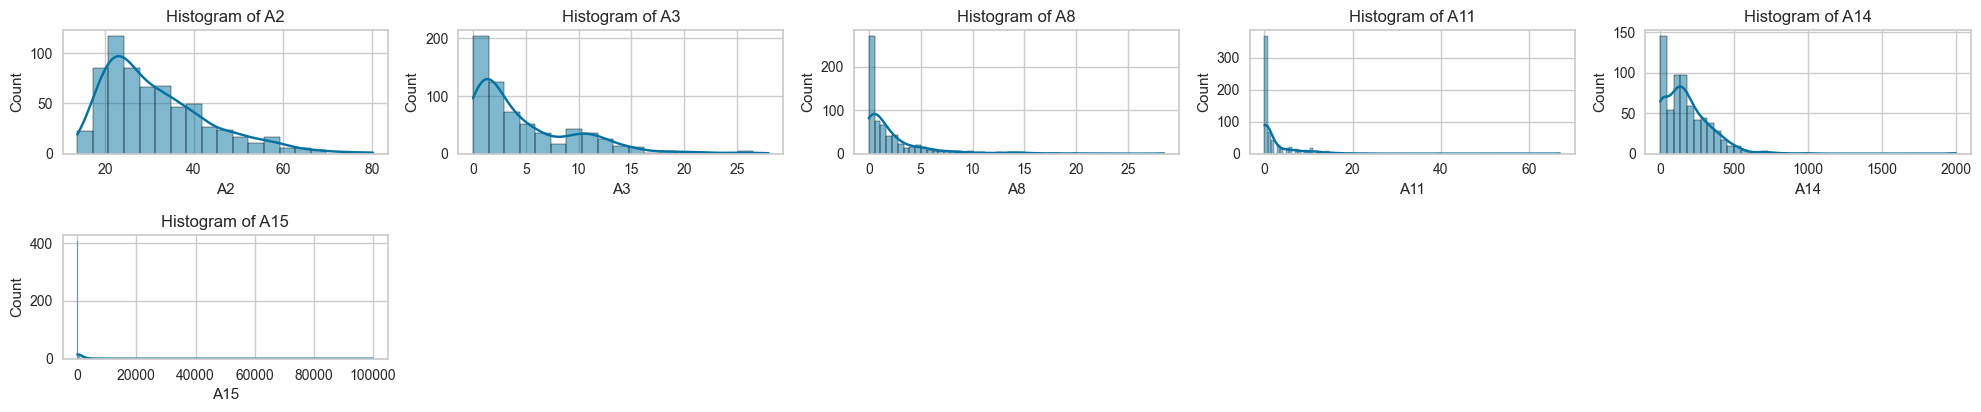

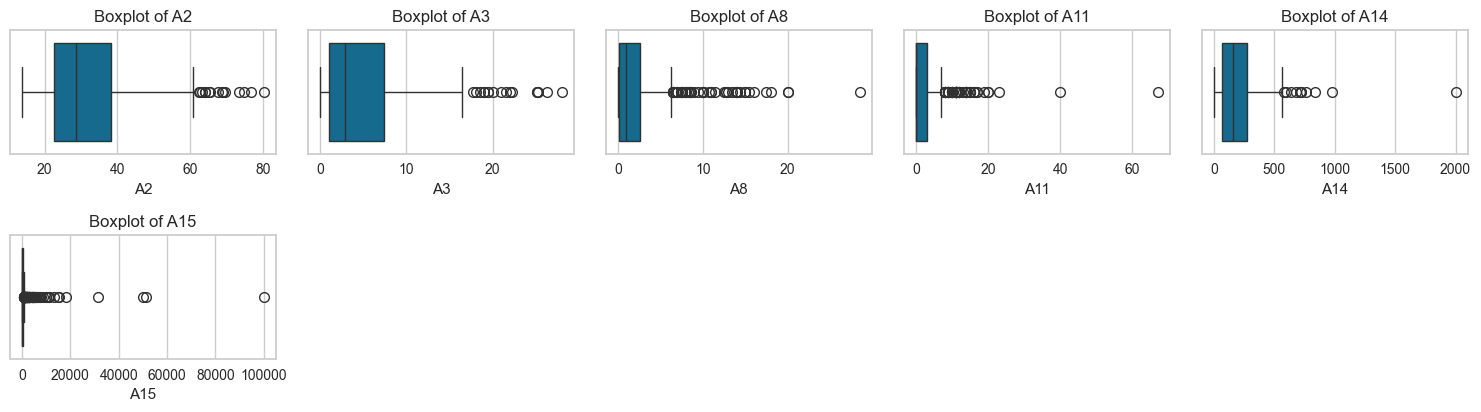

In [30]:
# Histograma 
numerical_columns = ['A2','A3','A8','A11','A14','A15']

plt.figure(figsize=(20, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(5, 5, i + 1)
    sns.histplot(df_analisis[col], kde=True)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(x=df_analisis[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

Veamos el análisis de cada una de estas variables

### Análisis de la variable A2

#### Histograma

Se construye el histograma de la variable y su diagrama de densidad

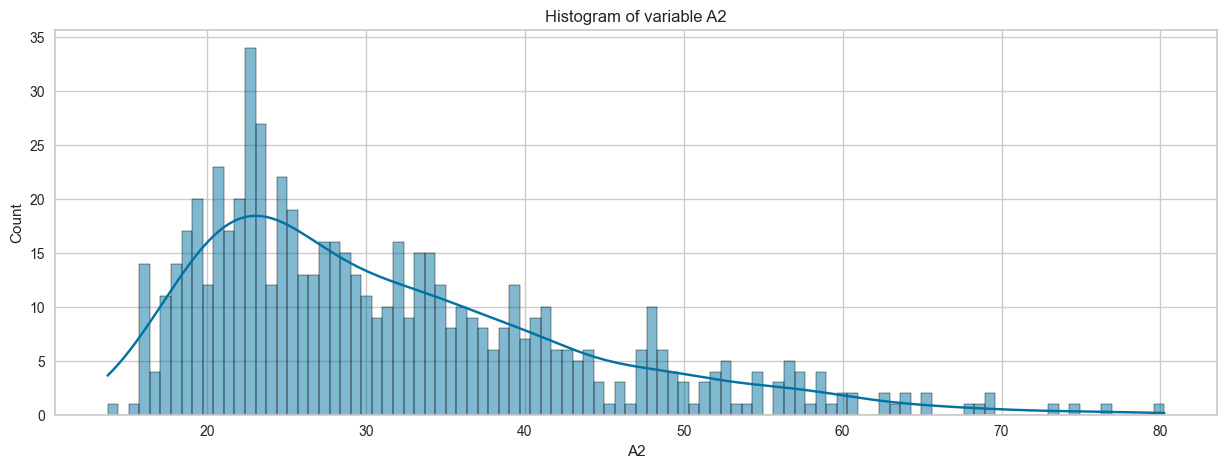

In [31]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_analisis,x='A2',kde=True,bins=100)
plt.title("Histogram of variable A2")
plt.show()

In [32]:
df_analisis.describe()['A2']

count    654.000000
mean      31.578349
std       11.981789
min       13.750000
25%       22.580000
50%       28.460000
75%       38.250000
max       80.250000
Name: A2, dtype: float64

Se observa lo siguiente:
- La variable **A2** presenta un histograma asimetrico positiva, con una cola hacia la derecha, lo que evidencia que se tiene la presencia de pocos valores altos hacia la derecha, mientras que la mayoría de individuos que solicitan una tarjeta de crédito tienen valores que se concentran entre el primer cuartil $Q1$ y tercer cuartil $Q3$, entre aproximadamente 22 y 38 respectivamente.

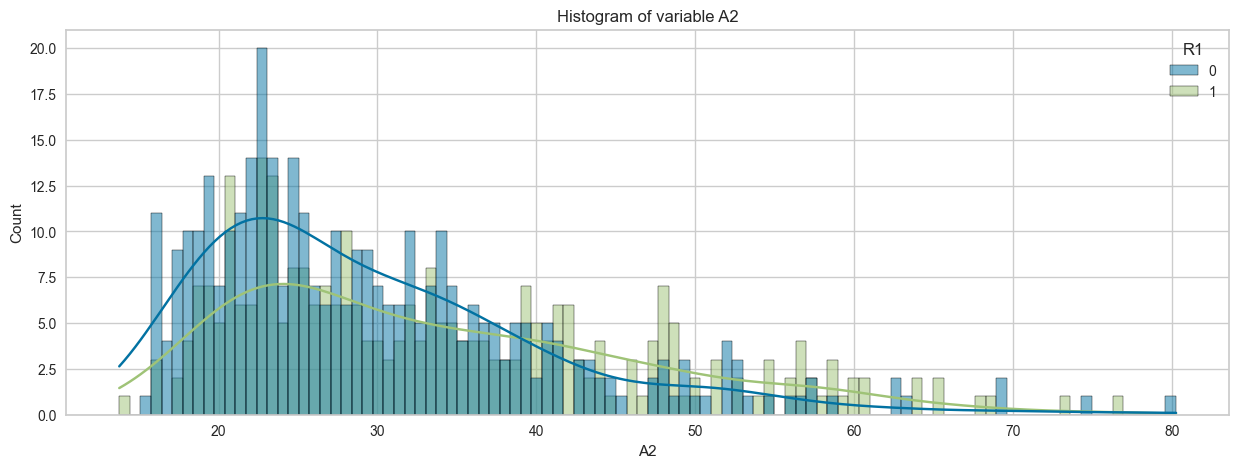

In [33]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_analisis,x='A2',kde=True,hue='R1',bins=100)
plt.title("Histogram of variable A2")
plt.show()

In [34]:
desc_stats = df_analisis.groupby('R1')['A2'].describe()
print(desc_stats)


    count       mean        std    min    25%     50%    75%    max
R1                                                                 
0   358.0  29.703855  11.034282  15.17  21.92  27.045  34.83  80.25
1   296.0  33.845473  12.689357  13.75  23.25  31.040  41.44  76.75


Se observa lo siguiente:
- La distribución de **A2** para **R1 igual a 0** tiene una mayor densidad en el rango de 20 a 30 como se visualiza en la gráfica. Esto indica que las observaciones están más presentes en este rango.
- **Para R1 igual a 1**, la distribución también es asimétrica con cola hacia la derecha, pero si bien tiene una densidad más baja comparada con **R1 igual a 0**, **los valores se distribuyen más uniformemente en un rango más amplio**, con menos concentración en valores específicos.
- Las curvas de densidad muestran que las observaciones con **R1 igual a 0** tienden a tener valores más bajos en comparación con aquellas con R1 igual a 1 ya que se distribuyen más uniformemente en un rango más amplio.


Através de este histograma tambien podemos validar la presencia de algunos valores fuera del rango normal de la distribución. Veamos un **Boxplot** para analizar estos puntos con más detalle.

#### Boxplot y Test de Tukey

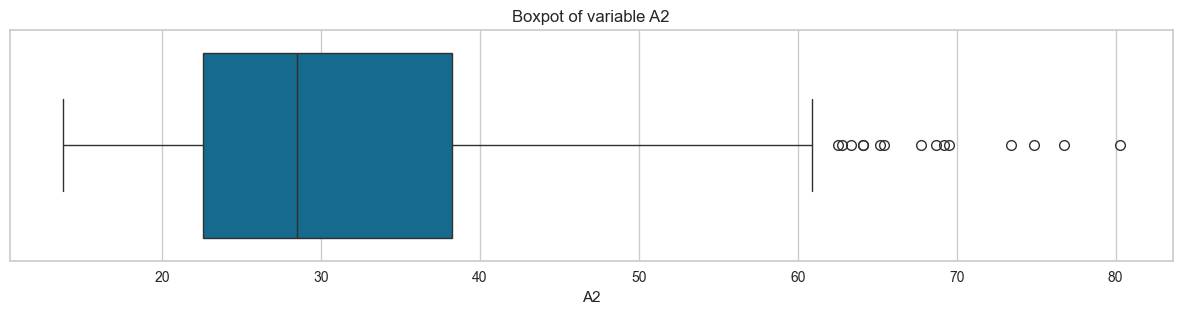

In [35]:
plt.figure(figsize=(15,3))
sns.boxplot(df_analisis['A2'],orient='h')
plt.title("Boxpot of variable A2")
plt.show()

Una forma muy sencilla de eliminar outliers de forma analítica es aplicando el test de Tukey. Éste dice que se considera valor atípico a todo aquel que **esté fuera**  del siguiente rango:

- Valor atípico: $ Q_1 - 1.5\cdot IQR > x > Q_3 + 1.5 \cdot IQR$
- Valor atípico extremo: $Q_1 - 3\cdot IQR > x >Q_3 + 3\cdot IQR$

Si la distribución es normal, entonces queda de la siguiente forma:

- Valor atípico: $ -\sigma > x > \sigma $
- Valor atípico extremo: $ -2\cdot\sigma > x > 2\cdot\sigma $

    count       mean        std    min    25%     50%    75%    max
R1                                                                 
0   358.0  29.703855  11.034282  15.17  21.92  27.045  34.83  80.25
1   296.0  33.845473  12.689357  13.75  23.25  31.040  41.44  76.75


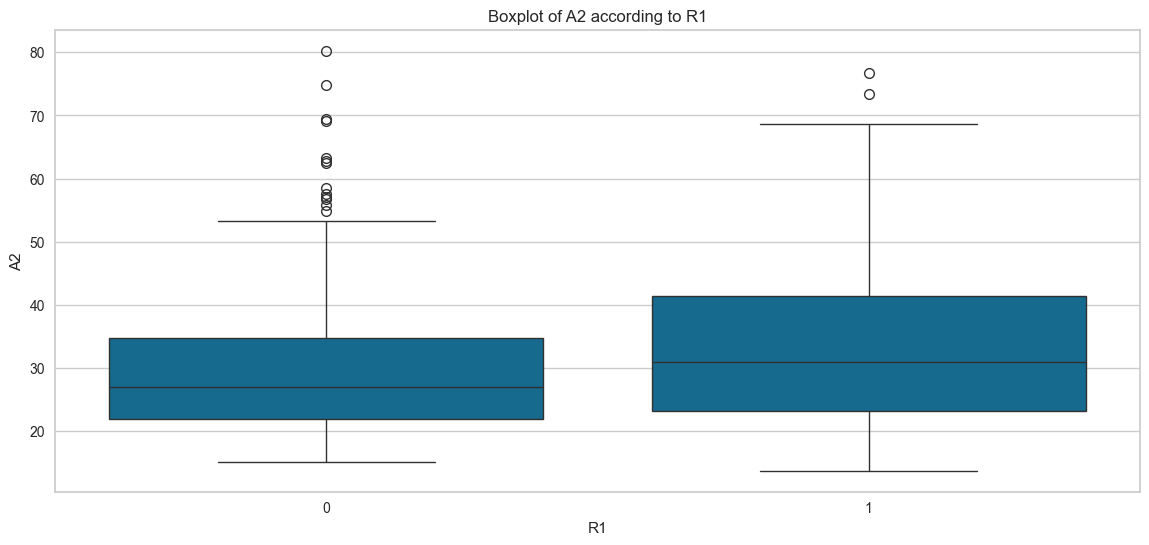

In [36]:
desc_stats = df_analisis.groupby('R1')['A2'].describe()
print(desc_stats)

plt.figure(figsize=(14,6))
sns.boxplot(x='R1', y='A2', data=df_analisis)
plt.title('Boxplot of A2 according to R1')
plt.show()

Calculemos el rango permitido de la variable $A2$ con respecto al target $R1$, así como identifiquemos los valores outliers.

In [37]:

Q1_0 = df_analisis[df_analisis['R1'] == 0]['A2'].quantile(0.25)
Q3_0 = df_analisis[df_analisis['R1'] == 0]['A2'].quantile(0.75)
IQR_0 = Q3_0 - Q1_0
outliers_0 = df_analisis[(df_analisis['R1'] == 0) & ((df_analisis['A2'] < (Q1_0 - 1.5 * IQR_0)) | (df_analisis['A2'] > (Q3_0 + 1.5 * IQR_0)))]

Q1_1 = df_analisis[df_analisis['R1'] == 1]['A2'].quantile(0.25)
Q3_1 = df_analisis[df_analisis['R1'] == 1]['A2'].quantile(0.75)
IQR_1 = Q3_1 - Q1_1
outliers_1 = df_analisis[(df_analisis['R1'] == 1) & ((df_analisis['A2'] < (Q1_1 - 1.5 * IQR_1)) | (df_analisis['A2'] > (Q3_1 + 1.5 * IQR_1)))]

print(f"La cantidad de valores Outliers para R1=0:\n{len(outliers_0)}")
print(f"La cantidad de valores Outliers para R1=1:\n{len(outliers_1)}")

La cantidad de valores Outliers para R1=0:
13
La cantidad de valores Outliers para R1=1:
2


#### Análisis de Percentiles

A través del Boxplot y el test de Tukey podemos ver claramente que existen algunos valores outliers hacia la derecha que pueden no favorecer en el comportamiento habitual de los datos. Complementemos el análisis mediante el análisis por **Percentiles**

In [38]:
vector_percentiles = [0,0.5,1,2.5,5,10,25,50,75,90,92.5,95,97.5,98,98.5,99,99.5,100]
vector_valores_percentiles=np.percentile(df_analisis['A2'],vector_percentiles)

pd.concat([pd.DataFrame(vector_percentiles, columns = ['Percentile']),
           pd.DataFrame(vector_valores_percentiles, columns = ['Valor'])], axis = 1)

Percentile     Valor
0          0.0  13.75000
1          0.5  15.83000
2          1.0  16.00000
3          2.5  16.50000
4          5.0  17.92000
5         10.0  19.17000
6         25.0  22.58000
7         50.0  28.46000
8         75.0  38.25000
9         90.0  48.58000
10        92.5  51.92625
11        95.0  56.44800
12        97.5  60.41750
13        98.0  62.73500
14        98.5  64.30345
15        99.0  68.18240
16        99.5  72.38120
17       100.0  80.25000

Lo que se busca son **grandes variaciones por percentil**. Para esta variable en particular podemos notar que los valores de cada uno de los percentiles no tienen grandes variaciones. 

**Si bien el test de tukey nos arroja ciertos valores outliers con respecto al target, mediante este análisis complementario, esta variable no será necesario pre-procesarla a fin de retirar o inputar estos valores atipicos.**

### Análisis de la variable A3

#### Histograma

Se construye el histograma de la variable y su diagrama de densidad

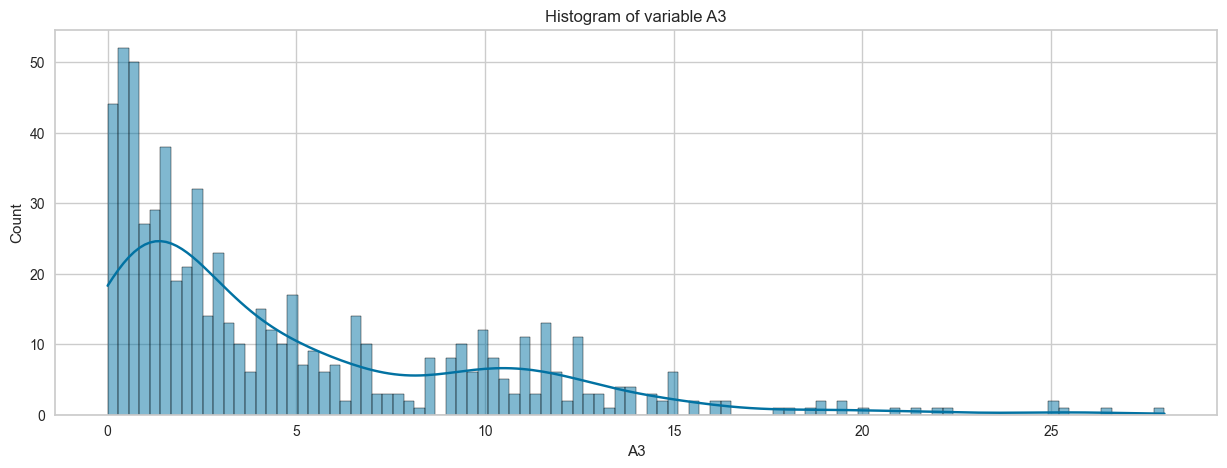

In [39]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_analisis,x='A3',kde=True,bins=100)
plt.title("Histogram of variable A3")
plt.show()

In [40]:
df_analisis.describe()['A3']

count    654.000000
mean       4.830558
std        5.023295
min        0.000000
25%        1.040000
50%        2.855000
75%        7.437500
max       28.000000
Name: A3, dtype: float64

Se observa lo siguiente:
- La variable A3 muestra una distribución asimétrica positiva, con una cola hacia la derecha. Esto significa que hay algunos valores extremadamente altos, y muchos valores bajos alrededor del $Q3$ (7.43)
- Tiene una media de 4.8 mayor que la mediana de 2.85. Esto significa que hay presencia de algunos valores extremos que generan que la media se vea impactada
- El 25% (1.04) de los valores son cercanos a cero.

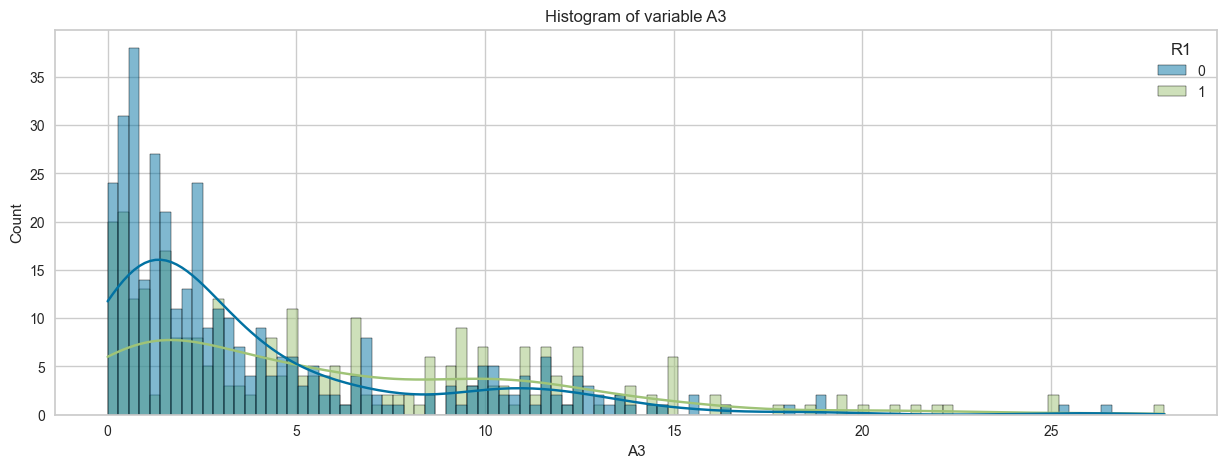

In [41]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_analisis,x='A3',kde=True,hue='R1',bins=100)
plt.title("Histogram of variable A3")
plt.show()

In [42]:
desc_stats = df_analisis.groupby('R1')['A3'].describe()
print(desc_stats)

    count      mean       std  min    25%   50%      75%     max
R1                                                              
0   358.0  3.886844  4.387755  0.0  0.835  2.23  5.00000  26.335
1   296.0  5.971943  5.492651  0.0  1.500  4.48  9.56125  28.000


Se observa lo siguiente:
- La dispersión de los valores de $A3$ es considerable en ambos grupos, pero más pronunciada en el grupo R1 = 1, sus valores están más distribuidos en un rango más amplio mostrando una mayor variabilidad
- La desviación estándar de R1 = 1 es 5.49, indicando una mayor dispersión en comparación con R1 = 0 que presenta un desviación de 4.38.
- La mediana para R1 = 0 es **2.23** frente a un **4.48** para R1 = 1. Esto indica que el 50% de los valores para R1 = 0 son menores en comparación para R1 = 1.



Através de este histograma tambien podemos validar la presencia de algunos valores fuera del rango normal de la distribución. Veamos un **Boxplot** para analizar estos puntos con más detalle.

#### Boxplot y Test de Tukey

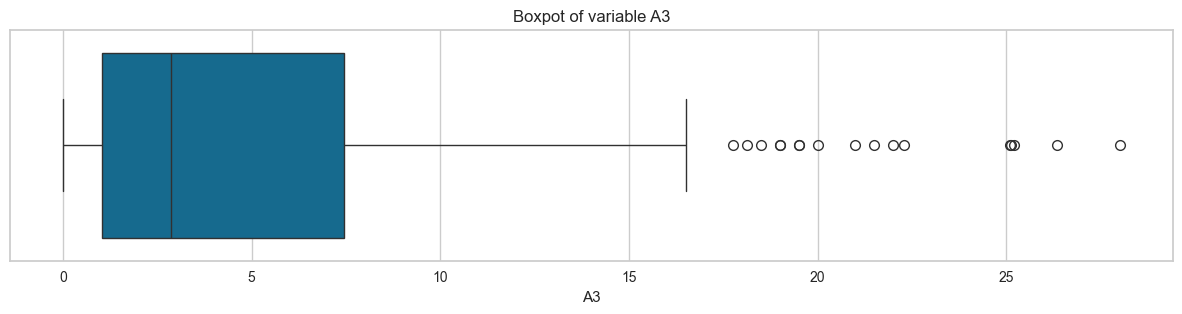

In [43]:
plt.figure(figsize=(15,3))
sns.boxplot(df_analisis['A3'],orient='h')
plt.title("Boxpot of variable A3")
plt.show()

Una forma muy sencilla de eliminar outliers de forma analítica es aplicando el test de Tukey.

    count      mean       std  min    25%   50%      75%     max
R1                                                              
0   358.0  3.886844  4.387755  0.0  0.835  2.23  5.00000  26.335
1   296.0  5.971943  5.492651  0.0  1.500  4.48  9.56125  28.000


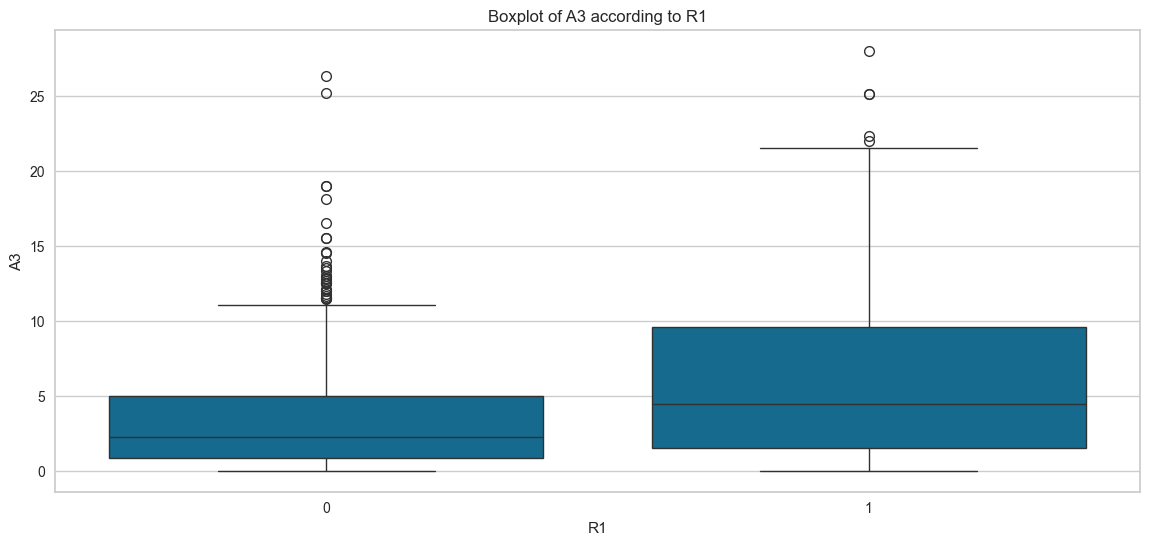

In [44]:
desc_stats = df_analisis.groupby('R1')['A3'].describe()
print(desc_stats)

plt.figure(figsize=(14, 6))
sns.boxplot(x='R1', y='A3', data=df_analisis)
plt.title('Boxplot of A3 according to R1')
plt.show()

Calculemos el rango permitido definido a través del test de tukey.

In [45]:
Q1_0 = df_analisis[df_analisis['R1'] == 0]['A3'].quantile(0.25)
Q3_0 = df_analisis[df_analisis['R1'] == 0]['A3'].quantile(0.75)
IQR_0 = Q3_0 - Q1_0
outliers_0 = df_analisis[(df_analisis['R1'] == 0) & ((df_analisis['A3'] < (Q1_0 - 1.5 * IQR_0)) | (df_analisis['A3'] > (Q3_0 + 1.5 * IQR_0)))]

Q1_1 = df_analisis[df_analisis['R1'] == 1]['A3'].quantile(0.25)
Q3_1 = df_analisis[df_analisis['R1'] == 1]['A3'].quantile(0.75)
IQR_1 = Q3_1 - Q1_1
outliers_1 = df_analisis[(df_analisis['R1'] == 1) & ((df_analisis['A3'] < (Q1_1 - 1.5 * IQR_1)) | (df_analisis['A3'] > (Q3_1 + 1.5 * IQR_1)))]

print(f"La cantidad de valores Outliers para R1=0:\n{len(outliers_0)}")
print(f"La cantidad de valores Outliers para R1=1:\n{len(outliers_1)}")

La cantidad de valores Outliers para R1=0:
33
La cantidad de valores Outliers para R1=1:
5


#### Análisis de Percentiles

A través del Boxplot y el test de Tukey podemos ver claramente que existen algunos valores outliers hacia la derecha que pueden no favorecer en el comportamiento habitual de los datos. Complementemos el análisis mediante el análisis por **Percentiles**

In [46]:
vector_percentiles = [0,0.5,1,2.5,5,10,25,50,75,90,92.5,95,97.5,98,98.5,99,99.5,100]
vector_valores_percentiles=np.percentile(df_analisis['A3'],vector_percentiles)

pd.concat([pd.DataFrame(vector_percentiles, columns = ['Percentile']),
           pd.DataFrame(vector_valores_percentiles, columns = ['Valor'])], axis = 1)

Percentile      Valor
0          0.0   0.000000
1          0.5   0.000000
2          1.0   0.000000
3          2.5   0.053000
4          5.0   0.205000
5         10.0   0.415000
6         25.0   1.040000
7         50.0   2.855000
8         75.0   7.437500
9         90.0  12.000000
10        92.5  12.542125
11        95.0  14.500000
12        97.5  17.343750
13        98.0  18.970000
14        98.5  19.602500
15        99.0  21.735000
16        99.5  25.114400
17       100.0  28.000000

Lo que se busca son **grandes variaciones por percentil**. Para esta variable en particular podemos notar que los valores de cada uno de los percentiles no tienen grandes variaciones. 

**Si bien el test de tukey nos arroja ciertos valores outliers con respecto al target, mediante este análisis complementario, esta variable no será necesario pre-procesarla a fin de retirar o inputar estos valores atipicos.**

### Análisis de la variable A8

#### Histograma

Se construye el histograma de la variable y su diagrama de densidad

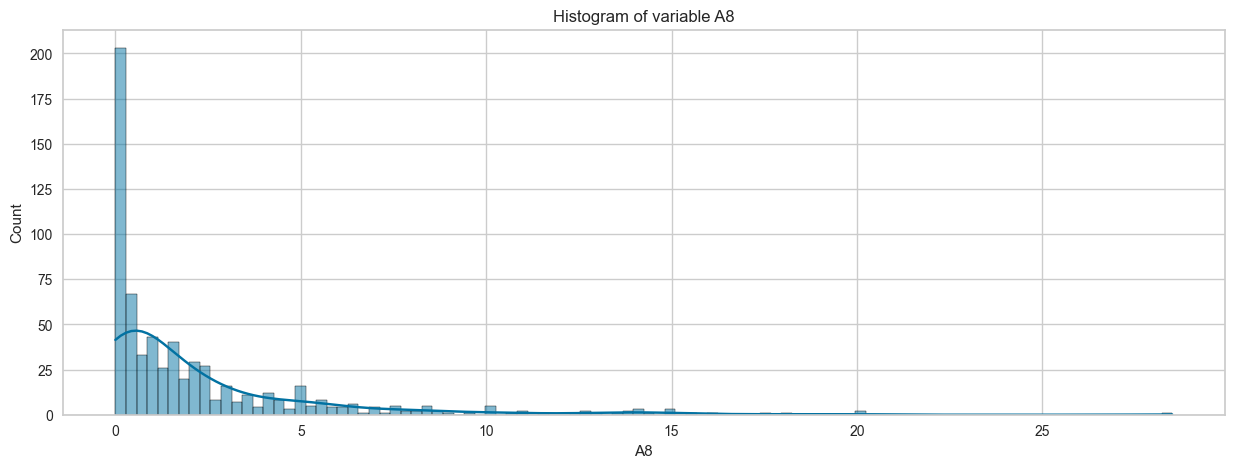

In [47]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_analisis,x='A8',kde=True,bins=100)
plt.title("Histogram of variable A8")
plt.show()

In [48]:
df_analisis.describe()['A8']

count    654.000000
mean       2.241690
std        3.369197
min        0.000000
25%        0.165000
50%        1.000000
75%        2.615000
max       28.500000
Name: A8, dtype: float64

Se observa lo siguiente:
- **Distribución asimétrica**: 
    - La variable A8 muestra una distribución asimétrica positiva, con una cola hacia la derecha. Esto significa que hay algunos valores extremadamente altos, y muchos valores bajos. El tercer cuartil ($Q3$) tiene un valor de 2.61
- **Concentración de valores**: 
    - El 50% de los valores son menores o iguales a 1. Esto lo evidencia la mediana que tiene un valor de 1 ($Q2$ = Mediana).
    - La mayoría de los valores se encuentran entre 0 y 2.65 ($Q3$ = 75% de los datos), con una concentración muy alta en el valor 0. Esto sugiere que muchas observaciones tienen valores bajos.
- **Densidad de valores**:
    - La densidad de los valores muestra un pico muy pronunciado en 0, indicando una alta frecuencia de este valor.
    - A medida que los valores aumentan, la densidad disminuye rápidamente (se desvanece gradualmente). Esto significa que los valores altos son mucho menos comunes.
- **Estadísticas descriptivas:**
    - La desviación estándar es 3.36, lo que indica una variabilidad moderada en los datos.
    - El máximo valor es 28, un valor alejado del tercer cuartil ($Q3$=75% de los datos) cuyo valor es 2.61

Se procede con el análisis tomando en cuenta el target $R1$

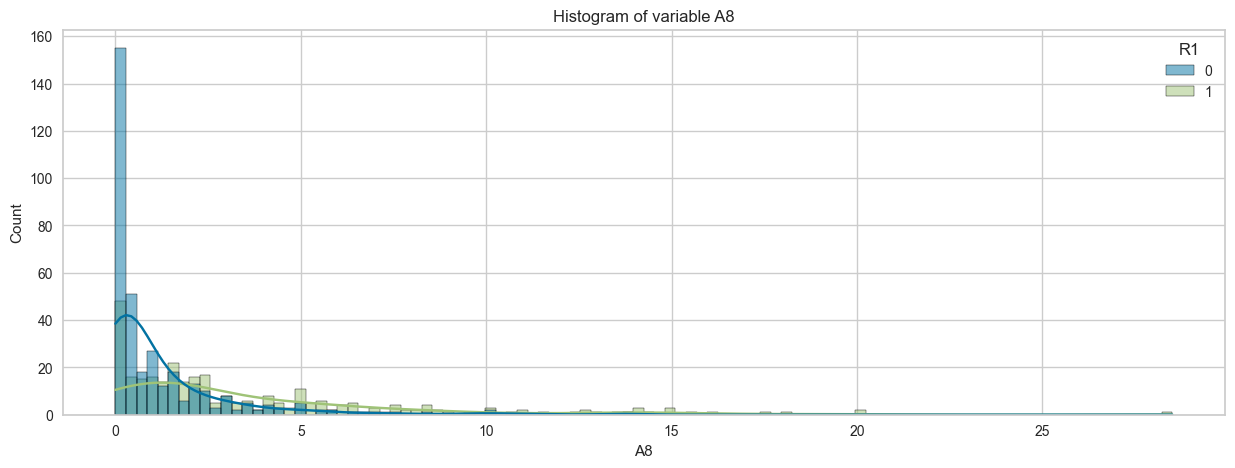

In [49]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_analisis,x='A8',kde=True,hue='R1',bins=100)
plt.title("Histogram of variable A8")
plt.show()

In [50]:
desc_stats = df_analisis.groupby('R1')['A8'].describe()
print(desc_stats)

    count      mean       std  min    25%     50%  75%     max
R1                                                            
0   358.0  1.221816  2.026750  0.0  0.125  0.4775  1.5  13.875
1   296.0  3.475186  4.167399  0.0  0.750  2.0000  5.0  28.500


Se observa lo siguiente:
- **Concentración de valores:**
    - La mayoría de los valores se encuentran entre 0 y 1.5 ($Q3$) para R1 = 0 y entre 0 y 5 ($Q3$) para R1 = 1.
    - El 50% de los valores para R1 = 0 son menores o iguales a 0.4775, mientras que para R1 = 1 son menores o iguales a 2.0.
    - Hay una alta concentración de valores en 0, especialmente para R1 = 0, lo que sugiere que muchas observaciones tienen valores bajos.
- **Densidad de valores:**
    - Para R1 = 0, la densidad disminuye rápidamente después de 0, mostrando que los valores más altos son mucho menos comunes.
    - Para R1 = 1, aunque la densidad también disminuye después de 0, La densidad de sus valores es más alta en un rango más amplio en comparación con R1 = 0, mostrando una mayor variabilidad. 
- **Comparación de estadísticas descriptivas:**
    - Hay una notable diferencia en la variabilidad entre los dos grupos. R1 = 1 muestra una mayor dispersión y valores más altos en general comparado con R1 = 0. 
    - La desviación estandar para R1 = 0 es 2.03. mientras que la desviación estándar para R1 = 1 es 4.16, indicando una mayor dispersión en comparación con R1 = 0.
    - La mediana es significativamente mayor, indicando que el 50% de los valores son menores o iguales a 2.0. Mientras que el 50% de los valores para R1 = 0 son menores o iguales a 0.4775.
    - Para R1 = 1, el máximo valor es 28, un valor ligeramente alejado del tercer cuartil $Q3$ cuyo valor es 5. Esto puede indicar la presencia de valores outliers.


Através de este histograma tambien podemos validar la presencia de algunos valores fuera del rango normal de la distribución. Veamos un **Boxplot** para analizar estos puntos con más detalle.

#### Boxplot y Test de Tukey

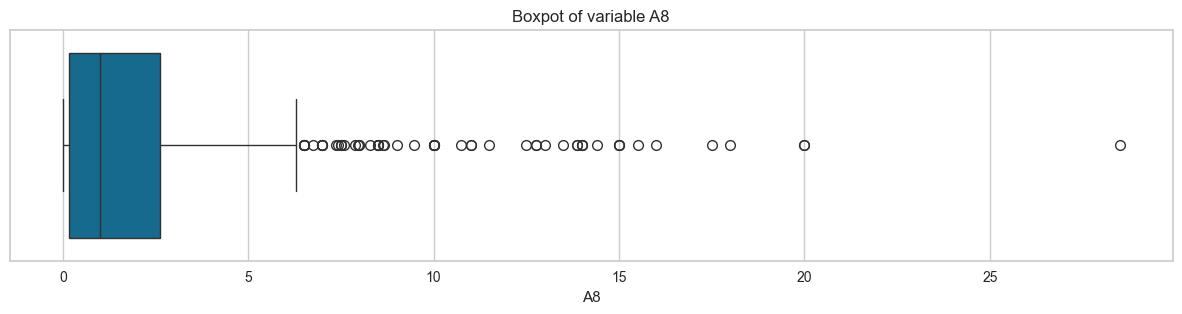

In [51]:
plt.figure(figsize=(15,3))
sns.boxplot(df_analisis['A8'],orient='h')
plt.title("Boxpot of variable A8")
plt.show()

Una forma muy sencilla de eliminar outliers de forma analítica es aplicando el test de Tukey.

    count      mean       std  min    25%     50%  75%     max
R1                                                            
0   358.0  1.221816  2.026750  0.0  0.125  0.4775  1.5  13.875
1   296.0  3.475186  4.167399  0.0  0.750  2.0000  5.0  28.500


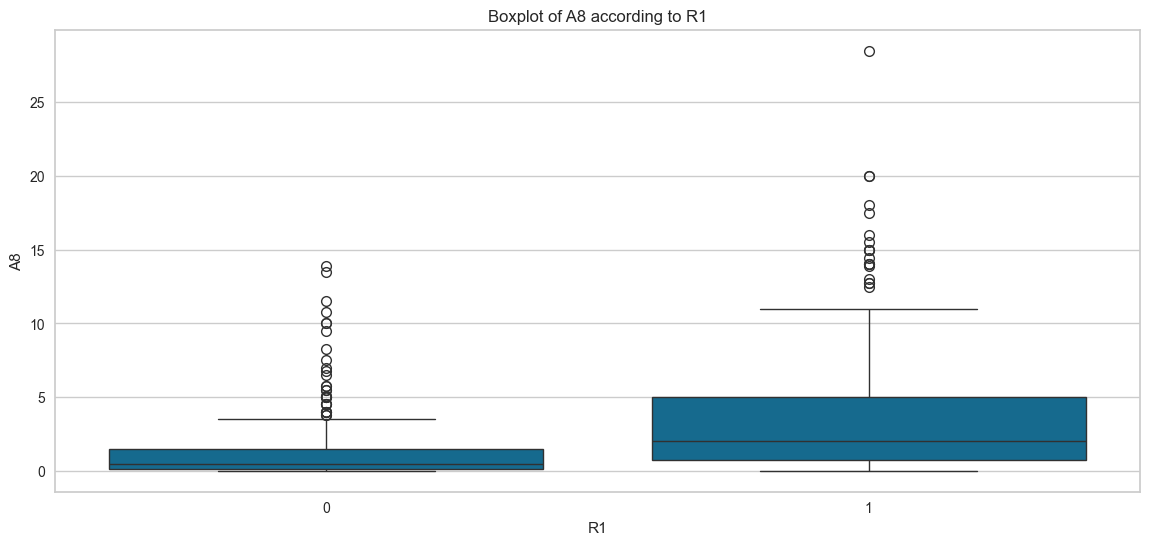

In [52]:
desc_stats = df_analisis.groupby('R1')['A8'].describe()
print(desc_stats)

plt.figure(figsize=(14, 6))
sns.boxplot(x='R1', y='A8', data=df_analisis)
plt.title('Boxplot of A8 according to R1')
plt.show()

Calculemos el rango permitido definido a través del test de tukey.

In [53]:
Q1_0 = df_analisis[df_analisis['R1'] == 0]['A8'].quantile(0.25)
Q3_0 = df_analisis[df_analisis['R1'] == 0]['A8'].quantile(0.75)
IQR_0 = Q3_0 - Q1_0
outliers_0 = df_analisis[(df_analisis['R1'] == 0) & ((df_analisis['A8'] < (Q1_0 - 1.5 * IQR_0)) | (df_analisis['A8'] > (Q3_0 + 1.5 * IQR_0)))]

Q1_1 = df_analisis[df_analisis['R1'] == 1]['A8'].quantile(0.25)
Q3_1 = df_analisis[df_analisis['R1'] == 1]['A8'].quantile(0.75)
IQR_1 = Q3_1 - Q1_1
outliers_1 = df_analisis[(df_analisis['R1'] == 1) & ((df_analisis['A8'] < (Q1_1 - 1.5 * IQR_1)) | (df_analisis['A8'] > (Q3_1 + 1.5 * IQR_1)))]

print(f"La cantidad de valores Outliers para R1=0:\n{len(outliers_0)}")
print(f"La cantidad de valores Outliers para R1=1:\n{len(outliers_1)}")

La cantidad de valores Outliers para R1=0:
30
La cantidad de valores Outliers para R1=1:
19


#### Análisis de Percentiles

A través del Boxplot y el test de Tukey podemos ver claramente que existen algunos valores outliers hacia la derecha que pueden no favorecer en el comportamiento habitual de los datos. Complementemos el análisis mediante el análisis por **Percentiles**

In [54]:
vector_percentiles = [0,0.5,1,2.5,5,10,25,50,75,90,92.5,95,97.5,98,98.5,99,99.5,100]
vector_valores_percentiles=np.percentile(df_analisis['A8'],vector_percentiles)

pd.concat([pd.DataFrame(vector_percentiles, columns = ['Percentile']),
           pd.DataFrame(vector_valores_percentiles, columns = ['Valor'])], axis = 1)

Percentile      Valor
0          0.0   0.000000
1          0.5   0.000000
2          1.0   0.000000
3          2.5   0.000000
4          5.0   0.000000
5         10.0   0.040000
6         25.0   0.165000
7         50.0   1.000000
8         75.0   2.615000
9         90.0   5.750000
10        92.5   7.009375
11        95.0   8.639000
12        97.5  13.337500
13        98.0  13.992500
14        98.5  14.534925
15        99.0  15.235000
16        99.5  17.867500
17       100.0  28.500000

Lo que se busca son **grandes variaciones por percentil**. Para esta variable el percentil **95** tiene un valor de **8.63** y el percentil **100** tiene un valor **28.5**, en **5%** los datos se alejan más del triple del valor del percentil **95**, lo cual puede considerable para esta distribución teniendo en cuenta que la mediana es **1**

Una poca cantidad de valores con altos valores. Esto queda en evidencia con el análisis de percentiles. Este será nuestro criterio empleado para imputar las variables.

### Análisis de la variable A11

#### Histograma

Se construye el histograma de la variable y su diagrama de densidad

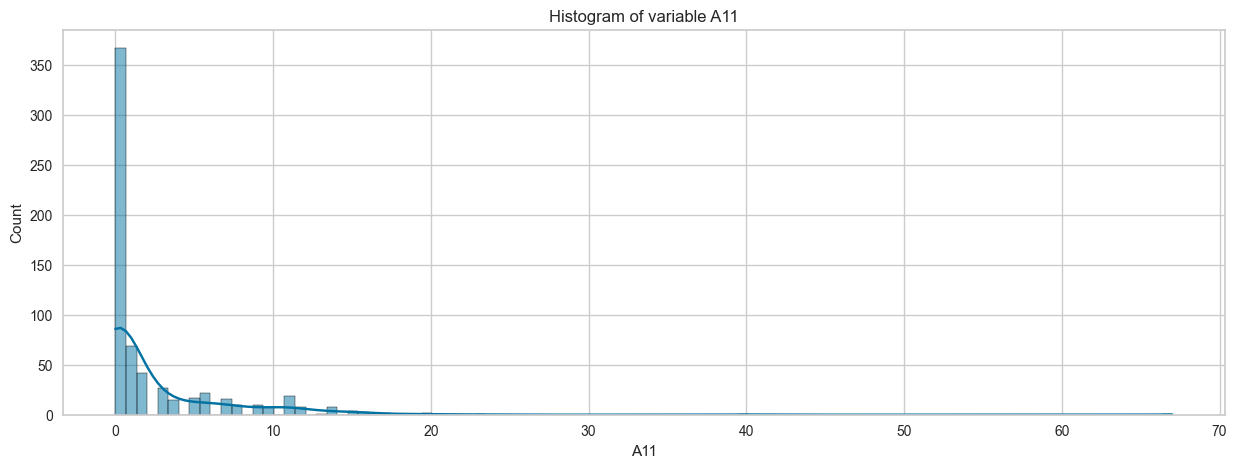

In [55]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_analisis,x='A11',kde=True,bins=100)
plt.title("Histogram of variable A11")
plt.show()

In [56]:
df_analisis.describe()['A11']

count    654.000000
mean       2.498471
std        4.965655
min        0.000000
25%        0.000000
50%        0.000000
75%        3.000000
max       67.000000
Name: A11, dtype: float64

Se observa lo siguiente:
- **Distribución asimétrica**:
    - La variable A11 muestra una distribución asimétrica positiva, con una cola hacia la derecha. Esto significa que hay algunos valores extremadamente altos, y muchos valores bajos, especialmente alrededor del valor 0.
- **Concentración de valores**: 
    - El 50% de los valores son menores o iguales a 0. Esto lo evidencia la mediana que tiene un valor de 0 ($Q2$ = Mediana).
    - La mayoría de los valores se encuentran entre 0 y 3 ($Q3$ = 75% de los datos), con una concentración muy alta en el valor 0. Esto sugiere que muchas observaciones tienen valores bajos.
- **Densidad de valores**:
    - La densidad de los valores muestra un pico muy pronunciado en 0, indicando una alta frecuencia de este valor.
    - A medida que los valores aumentan, la densidad disminuye rápidamente (se desvanece gradualmente). Esto significa que los valores altos son mucho menos comunes.
- **Estadísticas descriptivas:**
    - La desviación estándar es 4.97, lo que indica una variabilidad considerable en los datos. Especialmente porque se tiene un gran concentración alrededor del cero ($Q2$ = Mediana).
    - El máximo valor es 67, un valor alejado del tercer cuartil ($Q3$ = 75% de los datos) cuyo valor es 3.

Se procede con el análisis tomando en cuenta el target $R1$

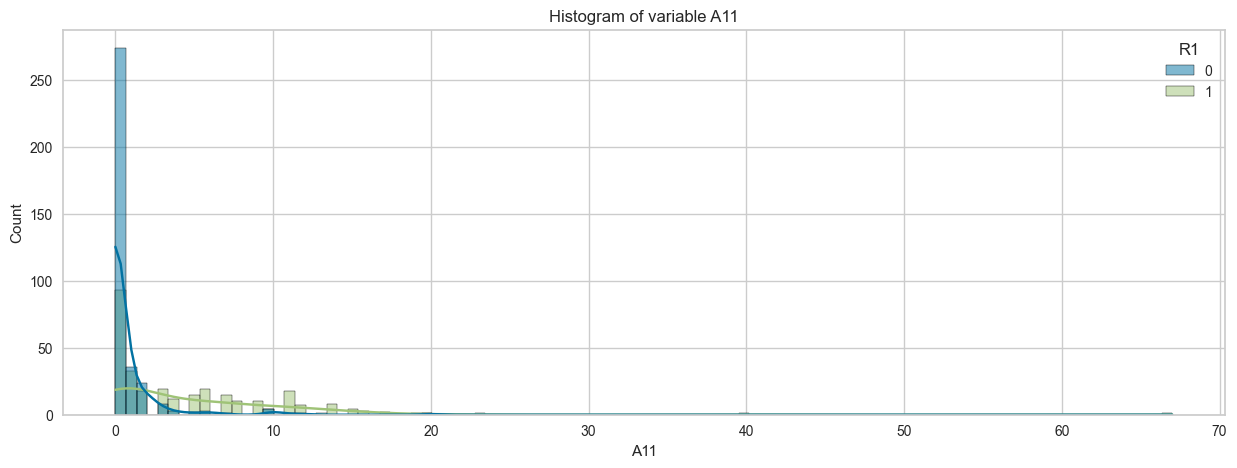

In [57]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_analisis,x='A11',kde=True,hue='R1',bins=100)
plt.title("Histogram of variable A11")
plt.show()

In [58]:
desc_stats = df_analisis.groupby('R1')['A11'].describe()
print(desc_stats)

    count      mean       std  min  25%  50%  75%   max
R1                                                     
0   358.0  0.664804  1.955941  0.0  0.0  0.0  0.0  20.0
1   296.0  4.716216  6.398136  0.0  0.0  3.0  7.0  67.0


Se observa lo siguiente:
- **Concentración de valores:**
    - La mayoría de los valores se encuentran entre 0 y 0 ($Q3$) para R1 = 0 y entre 0 y 7 ($Q3$) para R1 = 1
    - El 50% de los valores para R1 = 0 son menores o iguales a 0, mientras que para R1 = 1 son menores o iguales a 3
    - Hay una alta concentración de valores en 0, especialmente para R1 = 0, lo que sugiere que muchas observaciones tienen valores bajos.
- **Densidad de valores:**
    - Para R1 = 0, la densidad disminuye rápidamente después de 0, mostrando que los valores más altos son mucho menos comunes.
    - Para R1 = 1, aunque la densidad también disminuye después de 0, La densidad de sus valores es más alta en un rango más amplio en comparación con R1 = 0, mostrando una mayor variabilidad. 
- **Comparación de estadísticas descriptivas:**
    - Hay una notable diferencia en la variabilidad entre los dos grupos. R1 = 1 muestra una mayor dispersión y valores más altos en general comparado con R1 = 0. 
    - La desviación estandar para R1 = 0 es 1.96, mientras que la desviación estándar para R1 = 1 es 6.40, indicando una mayor dispersión en comparación con R1 = 0.
    - La mediana para R1 = 1 es significativamente mayor, indicando que el 50% de los valores son menores o iguales a 3. Mientras que el 50% de los valores para R1 = 0 son menores o iguales a 0.
    - Para R1 = 0, el máximo valor es 20, un valor alejado del tercer cuartil $Q3$ cuyo valor es 0, indicando la presencia de valores atípicos significativos en el conjunto de datos.
    - Para R1 = 1, el máximo valor es 67, un valor alejado del tercer cuartil $Q3$ cuyo valor es 7, indicando la presencia de valores atípicos significativos en el conjunto de datos.


Através de este histograma tambien podemos validar la presencia de algunos valores fuera del rango normal de la distribución. Veamos un **Boxplot** para analizar estos puntos con más detalle.

#### Boxplot y Test de Tukey

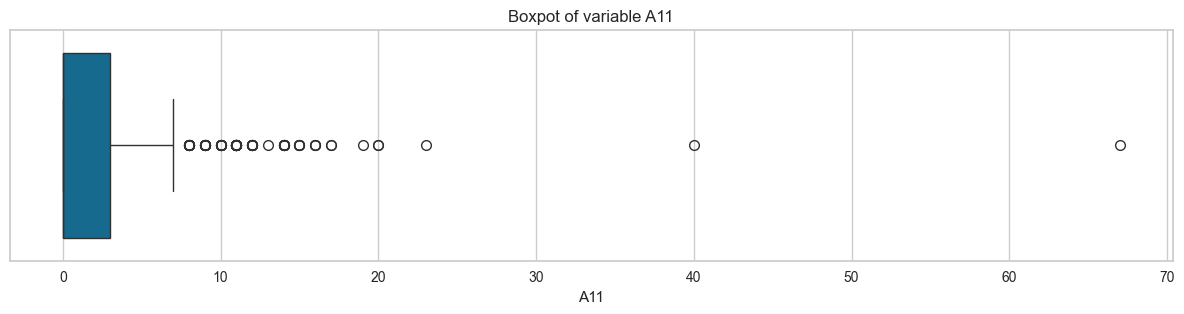

In [59]:
plt.figure(figsize=(15,3))
sns.boxplot(df_analisis['A11'],orient='h')
plt.title("Boxpot of variable A11")
plt.show()

Una forma muy sencilla de eliminar outliers de forma analítica es aplicando el test de Tukey.

    count      mean       std  min  25%  50%  75%   max
R1                                                     
0   358.0  0.664804  1.955941  0.0  0.0  0.0  0.0  20.0
1   296.0  4.716216  6.398136  0.0  0.0  3.0  7.0  67.0


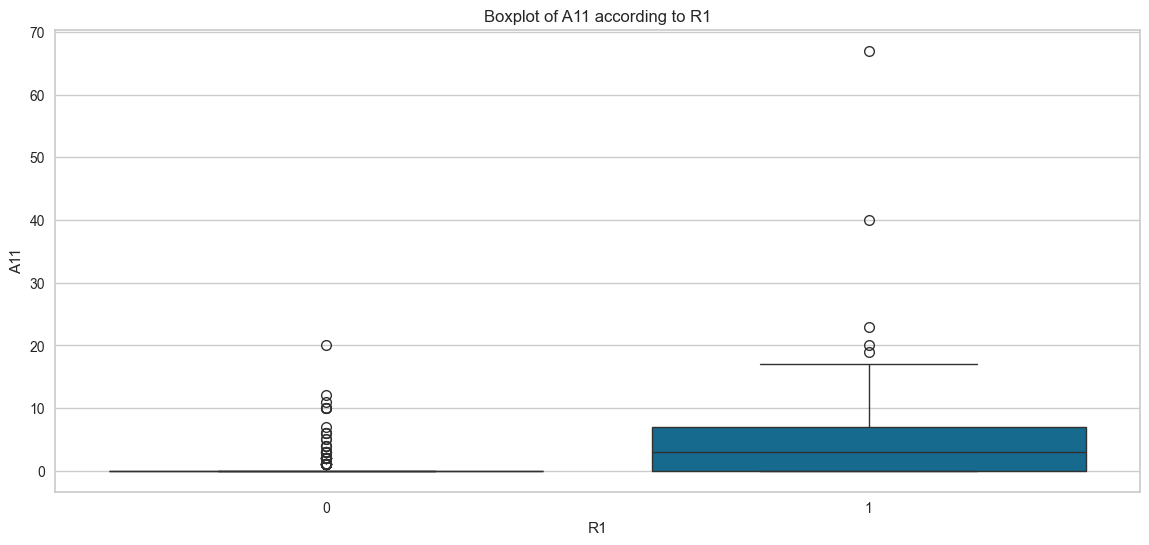

In [60]:
desc_stats = df_analisis.groupby('R1')['A11'].describe()
print(desc_stats)

plt.figure(figsize=(14, 6))
sns.boxplot(x='R1', y='A11', data=df_analisis)
plt.title('Boxplot of A11 according to R1')
plt.show()

Calculemos el rango permitido definido a través del test de tukey.

In [61]:
Q1_0 = df_analisis[df_analisis['R1'] == 0]['A11'].quantile(0.25)
Q3_0 = df_analisis[df_analisis['R1'] == 0]['A11'].quantile(0.75)
IQR_0 = Q3_0 - Q1_0
outliers_0 = df_analisis[(df_analisis['R1'] == 0) & ((df_analisis['A11'] < (Q1_0 - 1.5 * IQR_0)) | (df_analisis['A11'] > (Q3_0 + 1.5 * IQR_0)))]

Q1_1 = df_analisis[df_analisis['R1'] == 1]['A11'].quantile(0.25)
Q3_1 = df_analisis[df_analisis['R1'] == 1]['A11'].quantile(0.75)
IQR_1 = Q3_1 - Q1_1
outliers_1 = df_analisis[(df_analisis['R1'] == 1) & ((df_analisis['A11'] < (Q1_1 - 1.5 * IQR_1)) | (df_analisis['A11'] > (Q3_1 + 1.5 * IQR_1)))]

print(f"La cantidad de valores Outliers para R1=0:\n{len(outliers_0)}")
print(f"La cantidad de valores Outliers para R1=1:\n{len(outliers_1)}")

La cantidad de valores Outliers para R1=0:
84
La cantidad de valores Outliers para R1=1:
5


#### Análisis de Percentiles

A través del Boxplot y el test de Tukey podemos ver claramente que existen algunos valores outliers hacia la derecha que pueden no favorecer en el comportamiento habitual de los datos. Complementemos el análisis mediante el análisis por **Percentiles**

In [62]:
vector_percentiles = [0,0.5,1,2.5,5,10,25,50,75,90,92.5,95,97.5,98,98.5,99,99.5,100]
vector_valores_percentiles=np.percentile(df_analisis['A11'],vector_percentiles)

pd.concat([pd.DataFrame(vector_percentiles, columns = ['Percentile']),
           pd.DataFrame(vector_valores_percentiles, columns = ['Valor'])], axis = 1)

Percentile  Valor
0          0.0    0.0
1          0.5    0.0
2          1.0    0.0
3          2.5    0.0
4          5.0    0.0
5         10.0    0.0
6         25.0    0.0
7         50.0    0.0
8         75.0    3.0
9         90.0    9.0
10        92.5   11.0
11        95.0   11.0
12        97.5   14.0
13        98.0   15.0
14        98.5   16.0
15        99.0   17.0
16        99.5   20.0
17       100.0   67.0

Lo que se busca son **grandes variaciones por percentil**. Para esta variable el percentil **99** tiene un valor de **17** y el percentil **100** tiene un valor de **67**, en solo un **1%** los datos se alejan considerablemente para esta distribución de datos, teniendo en cuenta que la mediana es **0**

Una poca cantidad de valores con altos valores. Esto queda en evidencia con el análisis de percentiles. Este será nuestro criterio empleado para imputar las variables.

### Análisis de la variable A14

#### Histograma

Se construye el histograma de la variable y su diagrama de densidad

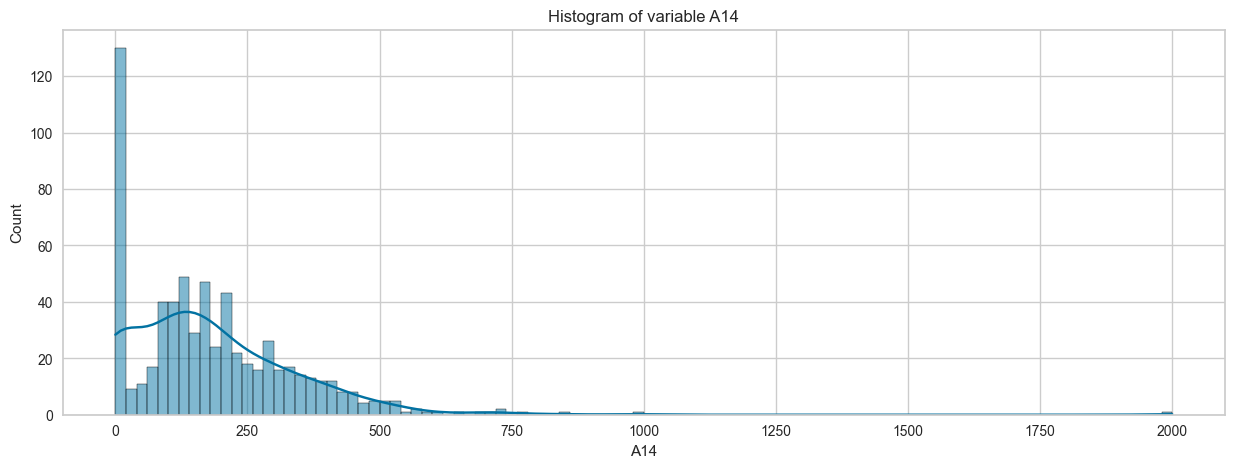

In [63]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_analisis,x='A14',kde=True,bins=100)
plt.title("Histogram of variable A14")
plt.show()

In [64]:
df_analisis.describe()['A14']

count     654.000000
mean      180.084098
std       168.315719
min         0.000000
25%        70.750000
50%       160.000000
75%       271.000000
max      2000.000000
Name: A14, dtype: float64

Se observa lo siguiente:
- **Distribución asimétrica**: 
    - La variable A14 muestra una distribución asimétrica positiva, con una cola hacia la derecha. Esto significa que hay algunos valores extremadamente altos y muchos valores bajos, especialmente alrededor del valor 0.
- **Concentración de valores**: 
    - El 50% de los valores son menores o iguales a 160. Esto lo evidencia la mediana que tiene un valor de 160 ($Q2$ = Mediana).
    - La mayoría de los valores se encuentran entre 70.75 y 271 ($Q3$ = 75% de los datos), con una concentración considerable en los valores bajos.
- **Densidad de valores**:
    - La densidad de los valores muestra un pico muy pronunciado en 0, indicando una alta frecuencia de este valor.
    - A medida que los valores aumentan, la densidad disminuye rápidamente (se desvanece gradualmente). Esto significa que los valores altos son mucho menos comunes.
- **Estadísticas descriptivas:**
    - La desviación estándar es de 168.32, lo que indica una variabilidad considerable en los datos. Especialmente porque se tiene una gran concentración alrededor de los valores bajos.
    - El máximo valor es 2000, un valor alejado del tercer cuartil ($Q3$) cuyo valor es 271, indicando la presencia de valores atípicos significativos en el conjunto de datos.

Se procede con el análisis tomando en cuenta el target $R1$

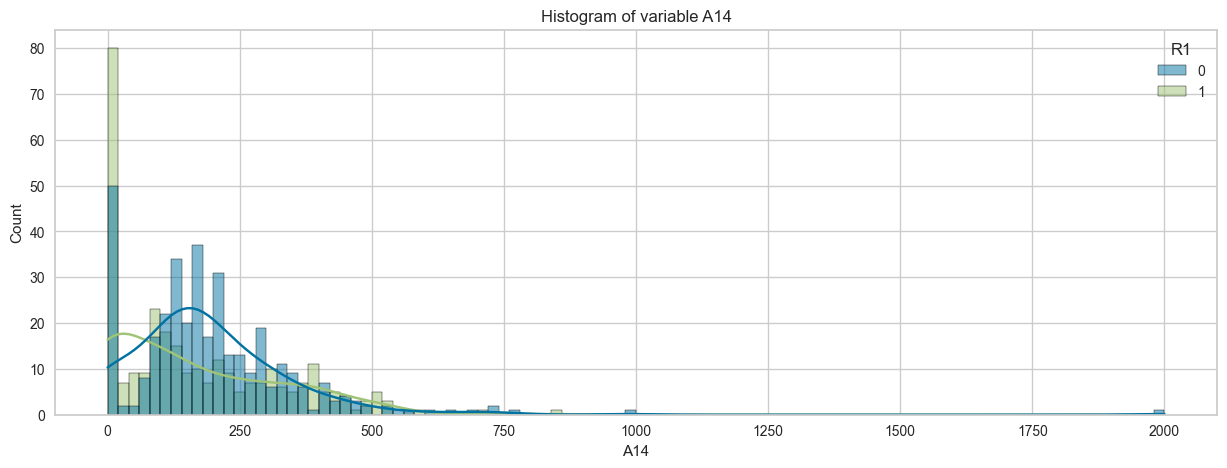

In [65]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_analisis,x='A14',kde=True,hue='R1',bins=100)
plt.title("Histogram of variable A14")
plt.show()

In [66]:
desc_stats = df_analisis.groupby('R1')['A14'].describe()
print(desc_stats)

    count        mean         std  min    25%    50%    75%     max
R1                                                                 
0   358.0  192.868715  172.120608  0.0  100.0  160.0  260.0  2000.0
1   296.0  164.621622  162.543550  0.0    0.0  120.0  280.0   840.0


Se observa lo siguiente:
- **Concentración de valores:**
    - La mayoría de los valores se encuentran entre 0 y 260 ($Q3$) para R1 = 0 y entre 0 y 280 ($Q3$) para R1 = 1
    - El 50% de los valores para R1 = 0 son menores o iguales a 160, mientras que para R1 = 1 son menores o iguales a 120
    - Hay una alta concentración de valores en 0, especialmente para R1 = 0, lo que sugiere que muchas observaciones tienen valores bajos.
- **Densidad de valores:**
    - Para R1 = 0, la densidad disminuye rápidamente después de 0, mostrando que los valores más altos son mucho menos comunes.
    - Para R1 = 1, aunque la densidad también disminuye después de 0, la densidad de sus valores es más alta en un rango más amplio en comparación con R1 = 0, mostrando una mayor variabilidad.
- **Comparación de estadísticas descriptivas:**
    - Hay una notable diferencia en la variabilidad entre los dos grupos. R1 = 0 muestra una mayor dispersión y valores más altos en general comparado con R1 = 1.
    - La desviación estándar para R1 = 0 es 172.12, mientras que la desviación estándar para R1 = 1 es 162.54, indicando una gran dispersión en ambos grupos.
    - La mediana para R1 = 0 es 160, mientras que para R1 = 1 es 120, indicando que el 50% de los valores para R1 = 0 son menores o iguales a 160, y el 50% de los valores para R1 = 1 son menores o iguales a 120.
    - Para R1 = 0, el máximo valor es 2000, un valor alejado del tercer cuartil $Q3$ cuyo valor es 260, indicando la presencia de valores atípicos significativos en el conjunto de datos.
    - Para R1 = 1, el máximo valor es 840, un valor alejado del tercer cuartil $Q3$ cuyo valor es 280, indicando la presencia de valores atípicos significativos en el conjunto de datos.


Através de este histograma tambien podemos validar la presencia de algunos valores fuera del rango normal de la distribución. Veamos un **Boxplot** para analizar estos puntos con más detalle.

#### Boxplot y Test de Tukey

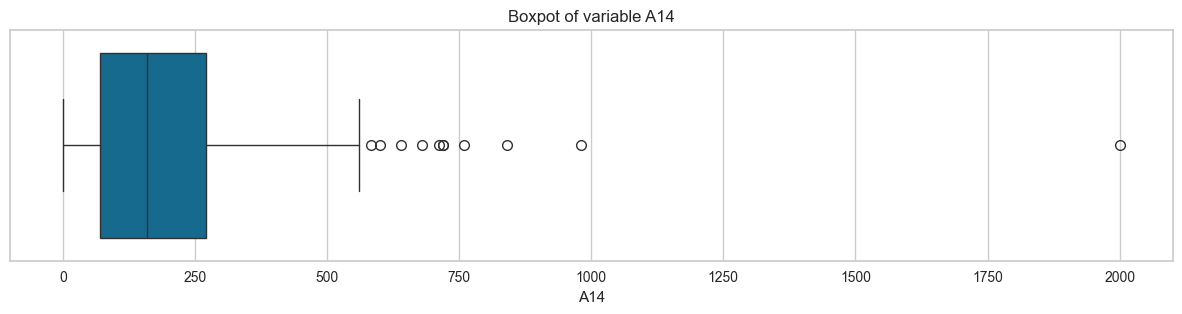

In [67]:
plt.figure(figsize=(15,3))
sns.boxplot(df_analisis['A14'],orient='h')
plt.title("Boxpot of variable A14")
plt.show()

Una forma muy sencilla de eliminar outliers de forma analítica es aplicando el test de Tukey.

    count        mean         std  min    25%    50%    75%     max
R1                                                                 
0   358.0  192.868715  172.120608  0.0  100.0  160.0  260.0  2000.0
1   296.0  164.621622  162.543550  0.0    0.0  120.0  280.0   840.0


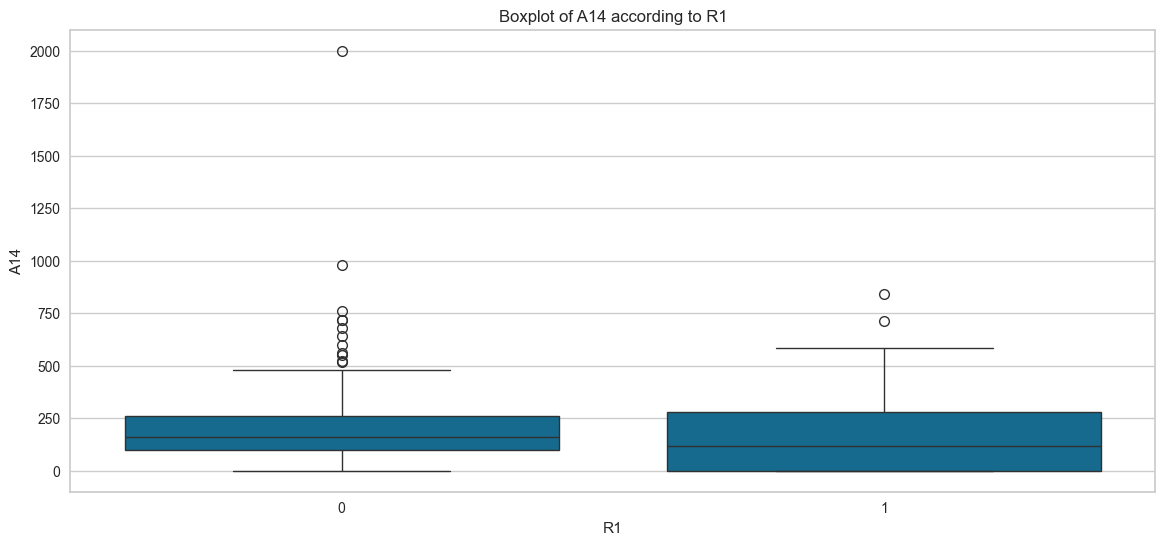

In [68]:
desc_stats = df_analisis.groupby('R1')['A14'].describe()
print(desc_stats)

plt.figure(figsize=(14, 6))
sns.boxplot(x='R1', y='A14', data=df_analisis)
plt.title('Boxplot of A14 according to R1')
plt.show()

Calculemos el rango permitido definido a través del test de tukey.

In [69]:
Q1_0 = df_analisis[df_analisis['R1'] == 0]['A14'].quantile(0.25)
Q3_0 = df_analisis[df_analisis['R1'] == 0]['A14'].quantile(0.75)
IQR_0 = Q3_0 - Q1_0
outliers_0 = df_analisis[(df_analisis['R1'] == 0) & ((df_analisis['A14'] < (Q1_0 - 1.5 * IQR_0)) | (df_analisis['A14'] > (Q3_0 + 1.5 * IQR_0)))]

Q1_1 = df_analisis[df_analisis['R1'] == 1]['A14'].quantile(0.25)
Q3_1 = df_analisis[df_analisis['R1'] == 1]['A14'].quantile(0.75)
IQR_1 = Q3_1 - Q1_1
outliers_1 = df_analisis[(df_analisis['R1'] == 1) & ((df_analisis['A14'] < (Q1_1 - 1.5 * IQR_1)) | (df_analisis['A14'] > (Q3_1 + 1.5 * IQR_1)))]

print(f"La cantidad de valores Outliers para R1=0:\n{len(outliers_0)}")
print(f"La cantidad de valores Outliers para R1=1:\n{len(outliers_1)}")

La cantidad de valores Outliers para R1=0:
12
La cantidad de valores Outliers para R1=1:
2


#### Análisis de Percentiles

A través del Boxplot y el test de Tukey podemos ver claramente que existen algunos valores outliers hacia la derecha que pueden no favorecer en el comportamiento habitual de los datos. Complementemos el análisis mediante el análisis por **Percentiles**

In [70]:
vector_percentiles = [0,0.5,1,2.5,5,10,25,50,75,90,92.5,95,97.5,98,98.5,99,99.5,100]
vector_valores_percentiles=np.percentile(df_analisis['A14'],vector_percentiles)

pd.concat([pd.DataFrame(vector_percentiles, columns = ['Percentile']),
           pd.DataFrame(vector_valores_percentiles, columns = ['Valor'])], axis = 1)

Percentile     Valor
0          0.0     0.000
1          0.5     0.000
2          1.0     0.000
3          2.5     0.000
4          5.0     0.000
5         10.0     0.000
6         25.0    70.750
7         50.0   160.000
8         75.0   271.000
9         90.0   394.400
10        92.5   416.100
11        95.0   456.750
12        97.5   520.000
13        98.0   548.380
14        98.5   586.485
15        99.0   694.570
16        99.5   749.400
17       100.0  2000.000

Lo que se busca son **grandes variaciones por percentil**. Para esta variable el percentil **99.5** tiene un valor de **749** y el percentil **100** tiene un valor de **2000**, en solo un **0.5%** los datos se alejan considerablemente para esta distribución de datos, teniendo en cuenta que la mediana es de **160**

Una poca cantidad de valores con altos valores. Esto queda en evidencia con el análisis de percentiles. Este será nuestro criterio empleado para imputar las variables.

### Análisis de la variable A15

#### Histograma

Se construye el histograma de la variable y su diagrama de densidad

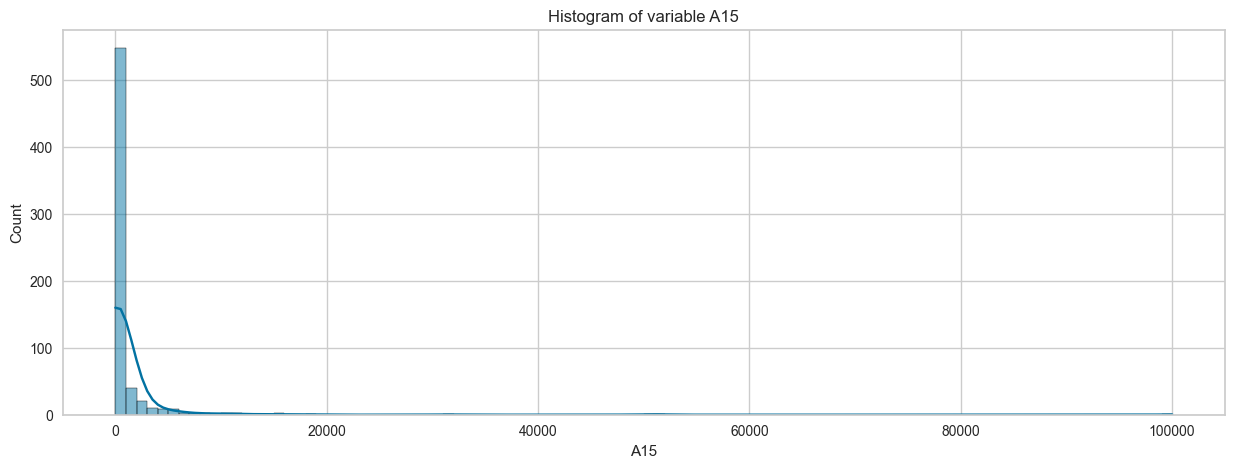

In [71]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_analisis,x='A15',kde=True,bins=100)
plt.title("Histogram of variable A15")
plt.show()

In [72]:
df_analisis.describe()['A15']

count       654.000000
mean       1012.730887
std        5249.320660
min           0.000000
25%           0.000000
50%           5.000000
75%         399.000000
max      100000.000000
Name: A15, dtype: float64

Se observa lo siguiente:
- **Distribución asimétrica**: 
    - La variable A15 muestra una distribución asimétrica positiva, con una cola hacia la derecha. Esto significa que hay algunos valores extremadamente altos y muchos valores bajos, especialmente alrededor del valor 0.
- **Concentración de valores**: 
    - El 50% de los valores son menores o iguales a 5. Esto lo evidencia la mediana que tiene un valor de 5 ($Q2$ = Mediana).
    - La mayoría de los valores se encuentran entre 0 y 399 ($Q3$ = 75% de los datos), con una concentración muy alta en el valor 0. Esto sugiere que muchas observaciones tienen valores bajos. 
    - **El 25% de los datos superiores al tercer cuartil, presentan un comportamiento inusual ya que los valores comiencen a subir gradualmente pasando de 399 a 513, luego a 604 hasta llegar hasta los 100000**
- **Densidad de valores**:
    - La densidad de los valores muestra un pico muy pronunciado en 0, indicando una alta frecuencia de este valor.
    - A medida que los valores aumentan, la densidad disminuye rápidamente (se desvanece gradualmente). Esto significa que los valores altos son mucho menos comunes.
- **Estadísticas descriptivas:**
    - La desviación estándar es 5249.32, lo que indica una variabilidad considerable en los datos. Especialmente porque se tiene una gran concentración alrededor del valor 0.
    - El máximo valor es 100000, un valor alejado del tercer cuartil ($Q3$) cuyo valor es 399, indicando la presencia de valores atípicos significativos en el conjunto de datos.

Se procede con el análisis tomando en cuenta el target $R1$

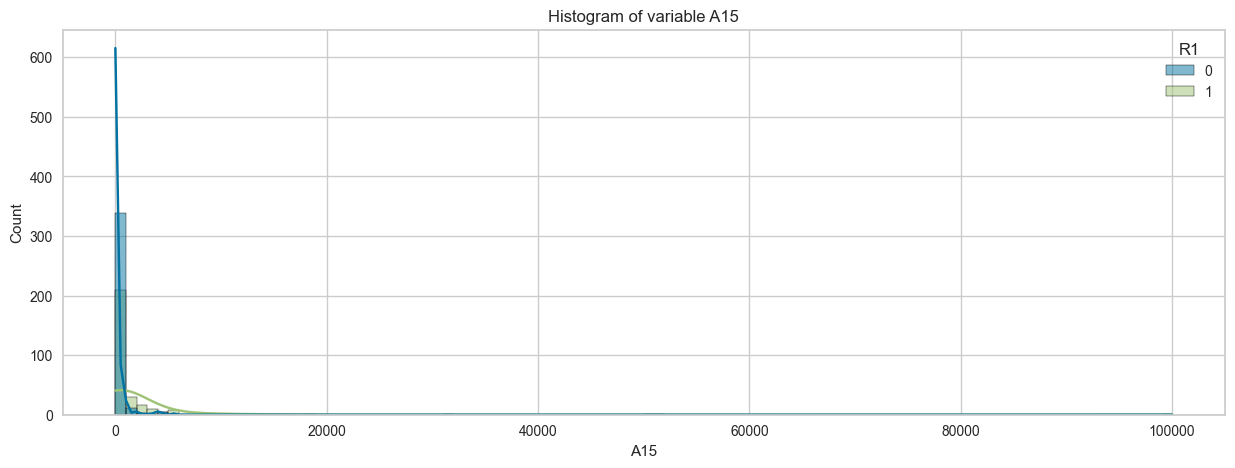

In [73]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_analisis,x='A15',kde=True,hue='R1',bins=100)
plt.title("Histogram of variable A15")
plt.show()

In [74]:
desc_stats = df_analisis.groupby('R1')['A15'].describe()
print(desc_stats)

    count         mean          std  min  25%    50%     75%       max
R1                                                                    
0   358.0   188.399441   631.945925  0.0  0.0    1.0    67.0    5552.0
1   296.0  2009.726351  7660.949172  0.0  0.0  210.5  1216.5  100000.0


Se observa lo siguiente:
- **Concentración de valores:**
    - La mayoría de los valores se encuentran entre 0 y 67 ($Q3$) para R1 = 0 y entre 0 y 1216.5 ($Q3$) para R1 = 1
    - El 50% de los valores para R1 = 0 son menores o iguales a 1, mientras que para R1 = 1 son menores o iguales a 210.5.
    - Hay una alta concentración de valores en 0, especialmente para R1 = 0, lo que sugiere que muchas observaciones tienen valores bajos.
- **Densidad de valores:**
    - Para R1 = 0, la densidad disminuye drásticamente después de 0, mostrando que los valores más altos son mucho menos comunes.
    - Para R1 = 1, aunque la densidad también disminuye después de 0, la densidad de sus valores es más alta en un rango más amplio en comparación con R1 = 0, mostrando una mayor variabilidad.
- **Comparación de estadísticas descriptivas:**
    - Hay una notable diferencia en la variabilidad entre los dos grupos. R1 = 1 muestra una mayor dispersión y valores más altos en general comparado con R1 = 0.
    - La desviación estándar para R1 = 0 es 631.95, mientras que la desviación estándar para R1 = 1 es 7660.95, indicando una gran dispersión en ambos grupos.
    - La mediana para R1 = 0 es 1, mientras que para R1 = 1 es 210.5, indicando que el 50% de los valores para R1 = 0 son menores o iguales a 1, y el 50% de los valores para R1 = 1 son menores o iguales a 210.5.
    - Para R1 = 0, el máximo valor es 5552, un valor alejado del tercer cuartil $Q3$ cuyo valor es 67, indicando la presencia de valores atípicos significativos en el conjunto de datos.
    - Para R1 = 1, el máximo valor es 100000, un valor alejado del tercer cuartil $Q3$ cuyo valor es 1216.5, indicando la presencia de valores atípicos significativos en el conjunto de datos.


Através de este histograma tambien podemos validar la presencia de algunos valores fuera del rango normal de la distribución. Veamos un **Boxplot** para analizar estos puntos con más detalle.

#### Boxplot y Test de Tukey

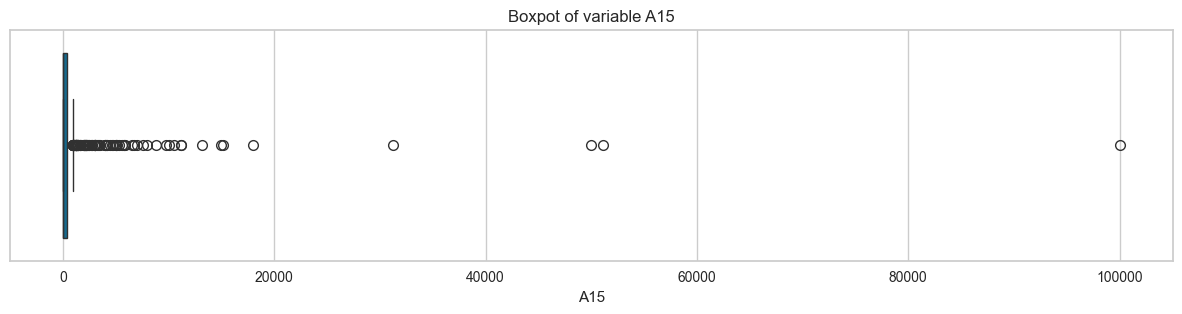

In [75]:
plt.figure(figsize=(15,3))
sns.boxplot(df_analisis['A15'],orient='h')
plt.title("Boxpot of variable A15")
plt.show()

Una forma muy sencilla de eliminar outliers de forma analítica es aplicando el test de Tukey.

    count         mean          std  min  25%    50%     75%       max
R1                                                                    
0   358.0   188.399441   631.945925  0.0  0.0    1.0    67.0    5552.0
1   296.0  2009.726351  7660.949172  0.0  0.0  210.5  1216.5  100000.0


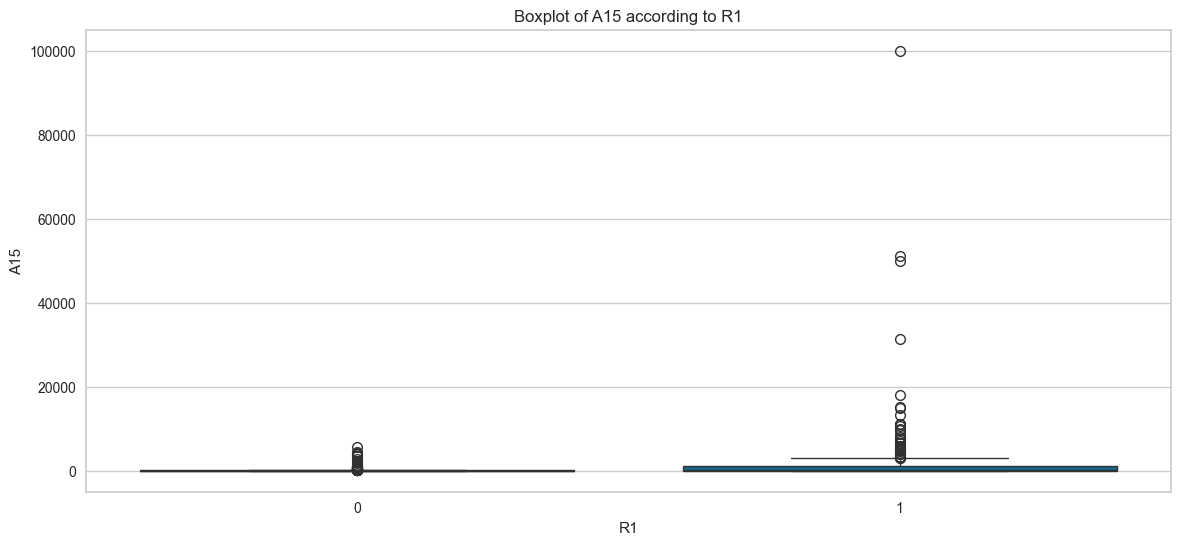

In [76]:
desc_stats = df_analisis.groupby('R1')['A15'].describe()
print(desc_stats)

plt.figure(figsize=(14, 6))
sns.boxplot(x='R1', y='A15', data=df_analisis)
plt.title('Boxplot of A15 according to R1')
plt.show()

Calculemos el rango permitido definido a través del test de tukey.

In [77]:
Q1_0 = df_analisis[df_analisis['R1'] == 0]['A15'].quantile(0.25)
Q3_0 = df_analisis[df_analisis['R1'] == 0]['A15'].quantile(0.75)
IQR_0 = Q3_0 - Q1_0
outliers_0 = df_analisis[(df_analisis['R1'] == 0) & ((df_analisis['A15'] < (Q1_0 - 1.5 * IQR_0)) | (df_analisis['A15'] > (Q3_0 + 1.5 * IQR_0)))]

Q1_1 = df_analisis[df_analisis['R1'] == 1]['A15'].quantile(0.25)
Q3_1 = df_analisis[df_analisis['R1'] == 1]['A15'].quantile(0.75)
IQR_1 = Q3_1 - Q1_1
outliers_1 = df_analisis[(df_analisis['R1'] == 1) & ((df_analisis['A15'] < (Q1_1 - 1.5 * IQR_1)) | (df_analisis['A15'] > (Q3_1 + 1.5 * IQR_1)))]

print(f"La cantidad de valores Outliers para R1=0:\n{len(outliers_0)}")
print(f"La cantidad de valores Outliers para R1=1:\n{len(outliers_1)}")

La cantidad de valores Outliers para R1=0:
65
La cantidad de valores Outliers para R1=1:
37


#### Análisis de Percentiles

A través del Boxplot y el test de Tukey podemos ver claramente que existen algunos valores outliers hacia la derecha que pueden no favorecer en el comportamiento habitual de los datos. Complementemos el análisis mediante el análisis por **Percentiles**

In [78]:
vector_percentiles = [0,0.5,1,2.5,5,10,25,30,40,45,50,53,55,57,60,65,70,75,78,80,82,85,88,90,92.5,95,97.5,98,98.5,99,99.5,100]
vector_valores_percentiles=np.percentile(df_analisis['A15'],vector_percentiles)

pd.concat([pd.DataFrame(vector_percentiles, columns = ['Percentile']),
           pd.DataFrame(vector_valores_percentiles, columns = ['Valor'])], axis = 1)

Percentile       Valor
0          0.0       0.000
1          0.5       0.000
2          1.0       0.000
3          2.5       0.000
4          5.0       0.000
5         10.0       0.000
6         25.0       0.000
7         30.0       0.000
8         40.0       0.000
9         45.0       1.000
10        50.0       5.000
11        53.0      10.000
12        55.0      17.150
13        57.0      25.420
14        60.0      50.000
15        65.0     136.700
16        70.0     247.400
17        75.0     399.000
18        78.0     513.240
19        80.0     604.000
20        82.0     804.140
21        85.0    1000.000
22        88.0    1339.680
23        90.0    2000.000
24        92.5    2733.775
25        95.0    4101.800
26        97.5    6942.325
27        98.0    8799.940
28        98.5   10687.280
29        99.0   14052.360
30        99.5   27771.630
31       100.0  100000.000

Lo que se busca son **grandes variaciones por percentil**. Para esta variable el percentil **88** tiene un valor de **1339** y el percentil **100** tiene un valor de **100000**, en **12%** los datos se alejan considerablemente para esta distribución de datos, teniendo en cuenta que la mediana es de **5**

Una poca cantidad de valores con altos valores. Esto queda en evidencia con el análisis de percentiles. Este será nuestro criterio empleado para imputar las variables.

## Reporte Univariado

Se realiza la conversión en los tipos de datos para realizar el reporte univariado

In [79]:
df_analisis_uni = df_analisis.copy()

In [80]:
# Se incluye el target a fin tener una mejor interpretación.
feat_categorical_uni = ['A1','A9','A10','A12','R1']

feat_numerical_uni = ['A2','A3','A8','A11','A14','A15']

In [81]:
for var in feat_categorical_uni:
  df_analisis_uni[var] = df_analisis_uni[var].astype('category')

In [82]:
df_analisis_uni.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   A1      654 non-null    category
 1   A2      654 non-null    float64 
 2   A3      654 non-null    float64 
 3   A8      654 non-null    float64 
 4   A9      654 non-null    category
 5   A10     654 non-null    category
 6   A11     654 non-null    int64   
 7   A12     654 non-null    category
 8   A14     654 non-null    int64   
 9   A15     654 non-null    int64   
 10  R1      654 non-null    category
dtypes: category(5), float64(3), int64(3)
memory usage: 34.6 KB


In [83]:
v=pd.DataFrame({"variable": df_analisis_uni.columns.values})
t=pd.DataFrame({"tipo": df_analisis_uni.dtypes.values})
meta=pd.concat([v, t], axis=1)
meta=meta.loc[(meta['tipo']=='category')|(meta['tipo']=='float64')|(meta['tipo']=='int64'),:]
meta

variable      tipo
0        A1  category
1        A2   float64
2        A3   float64
3        A8   float64
4        A9  category
5       A10  category
6       A11     int64
7       A12  category
8       A14     int64
9       A15     int64
10       R1  category

En el siguiente reporte se muestra lo siguiente:
- Para las variables cualitativas un gráfico de barras ordenado según la cantidad de vuelos, así como un digrama de pastel que indica el porcentaje de cada categoria.
- Para la única variable cuantitativa se muestra su histograma y boxplot.

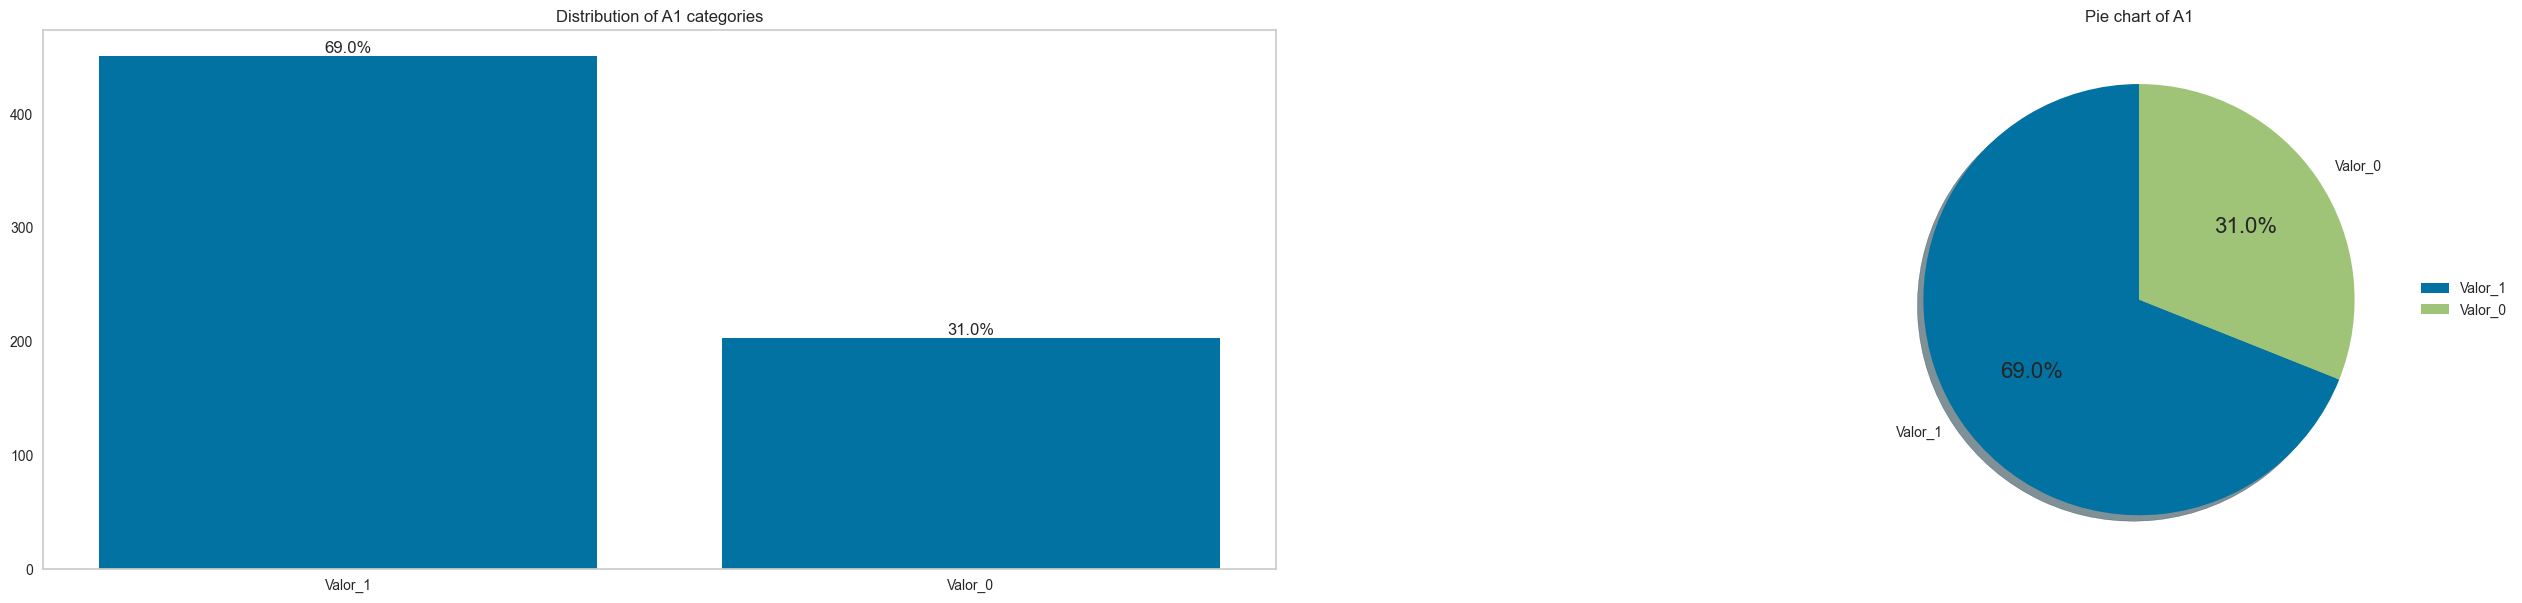

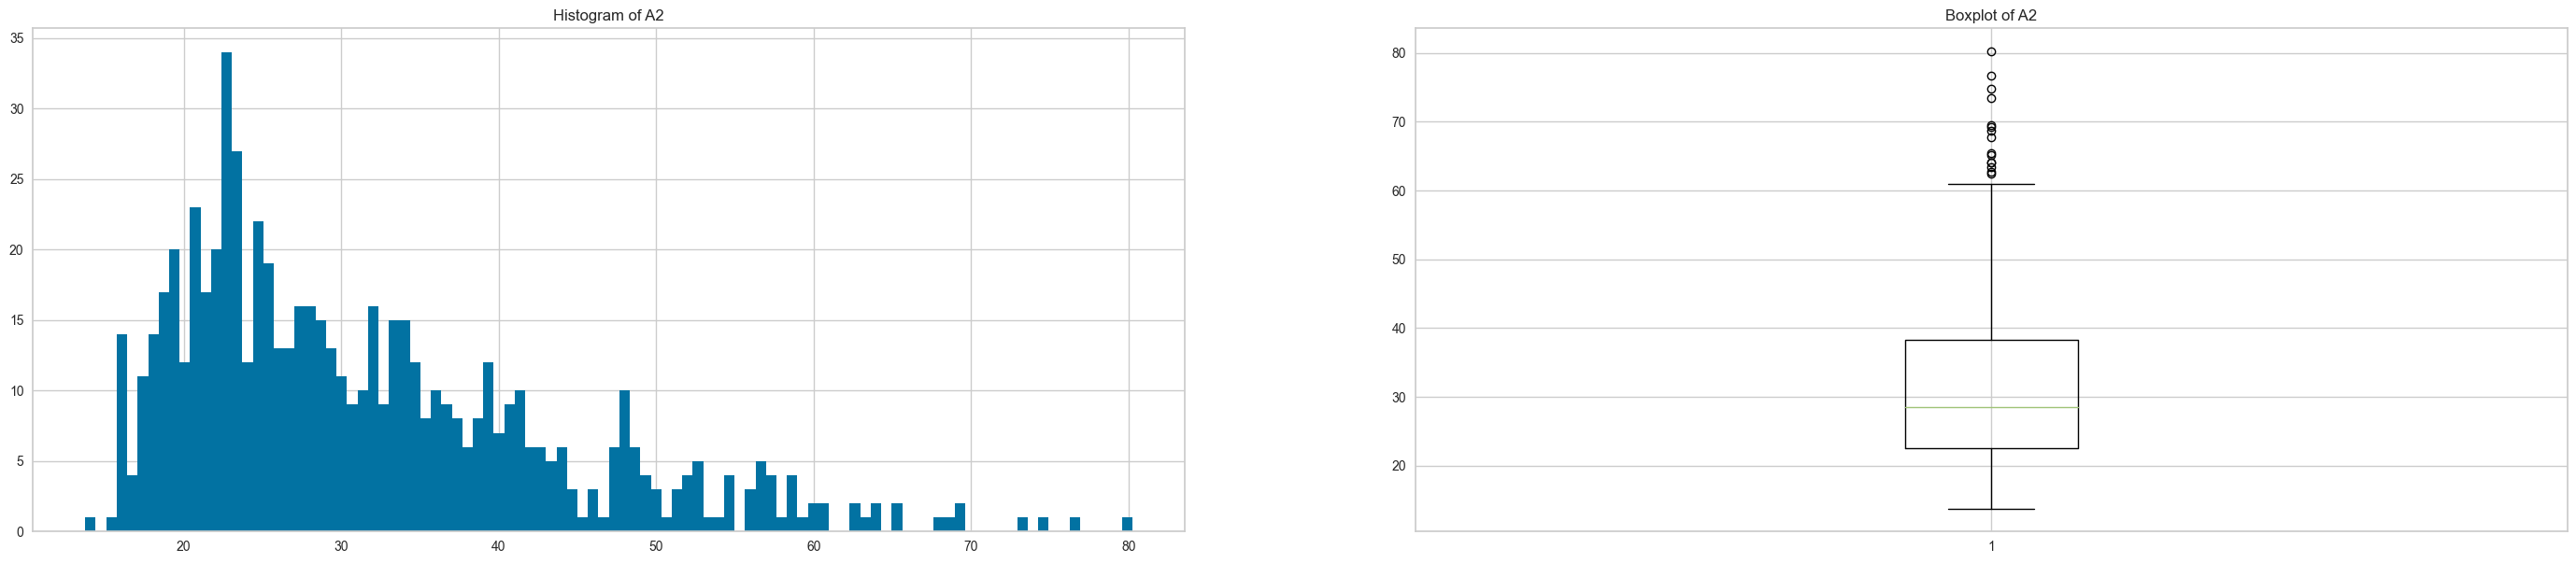

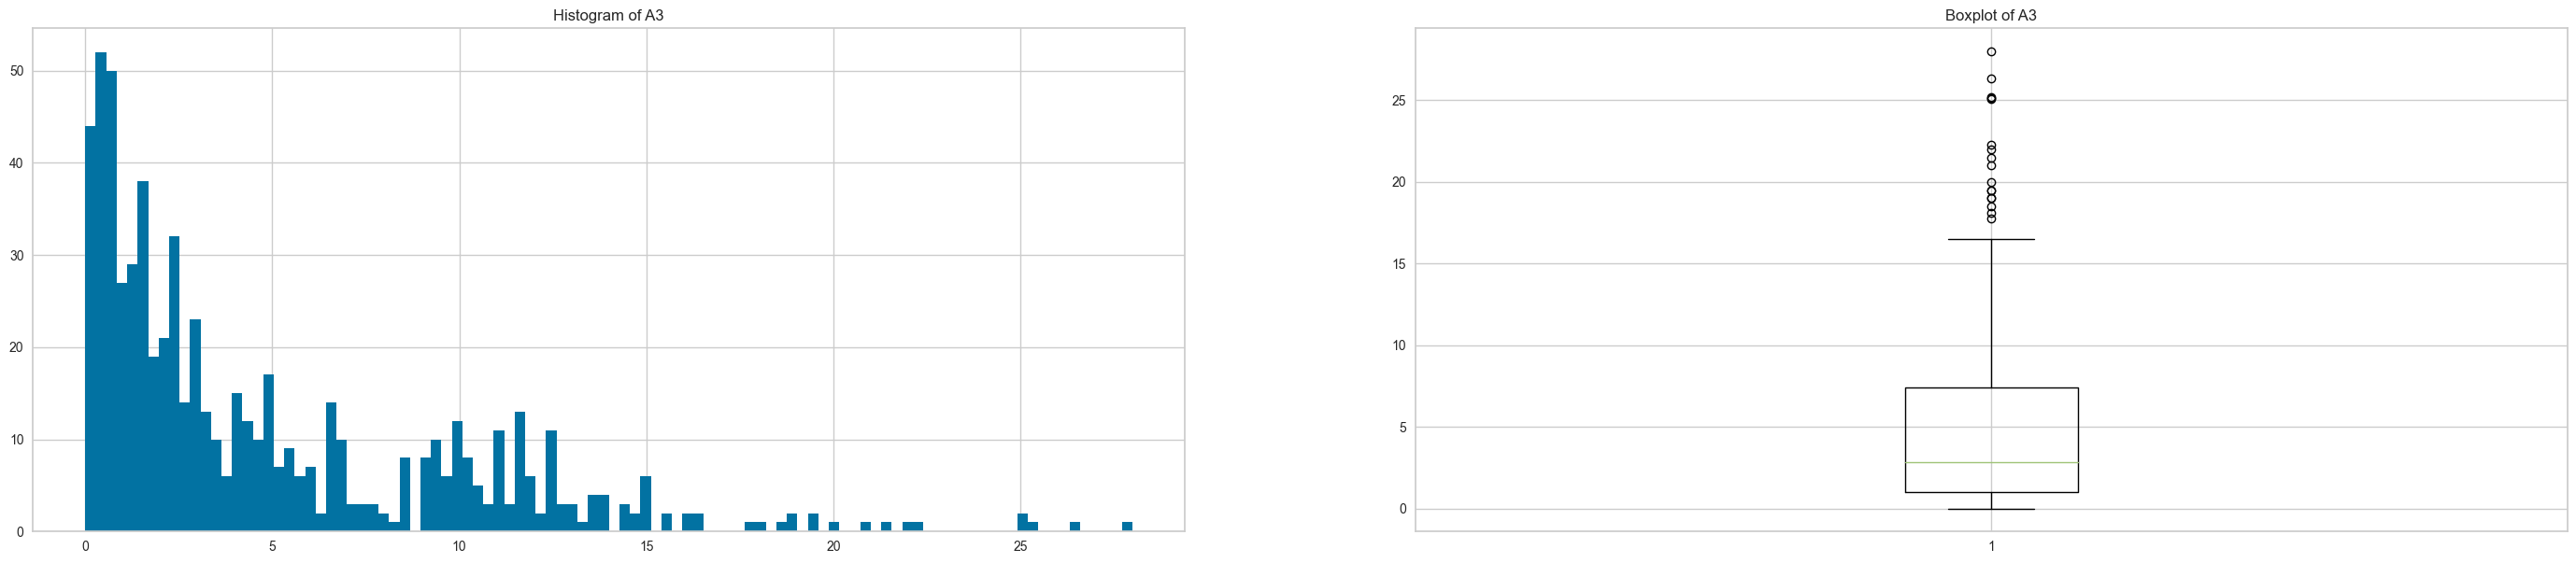

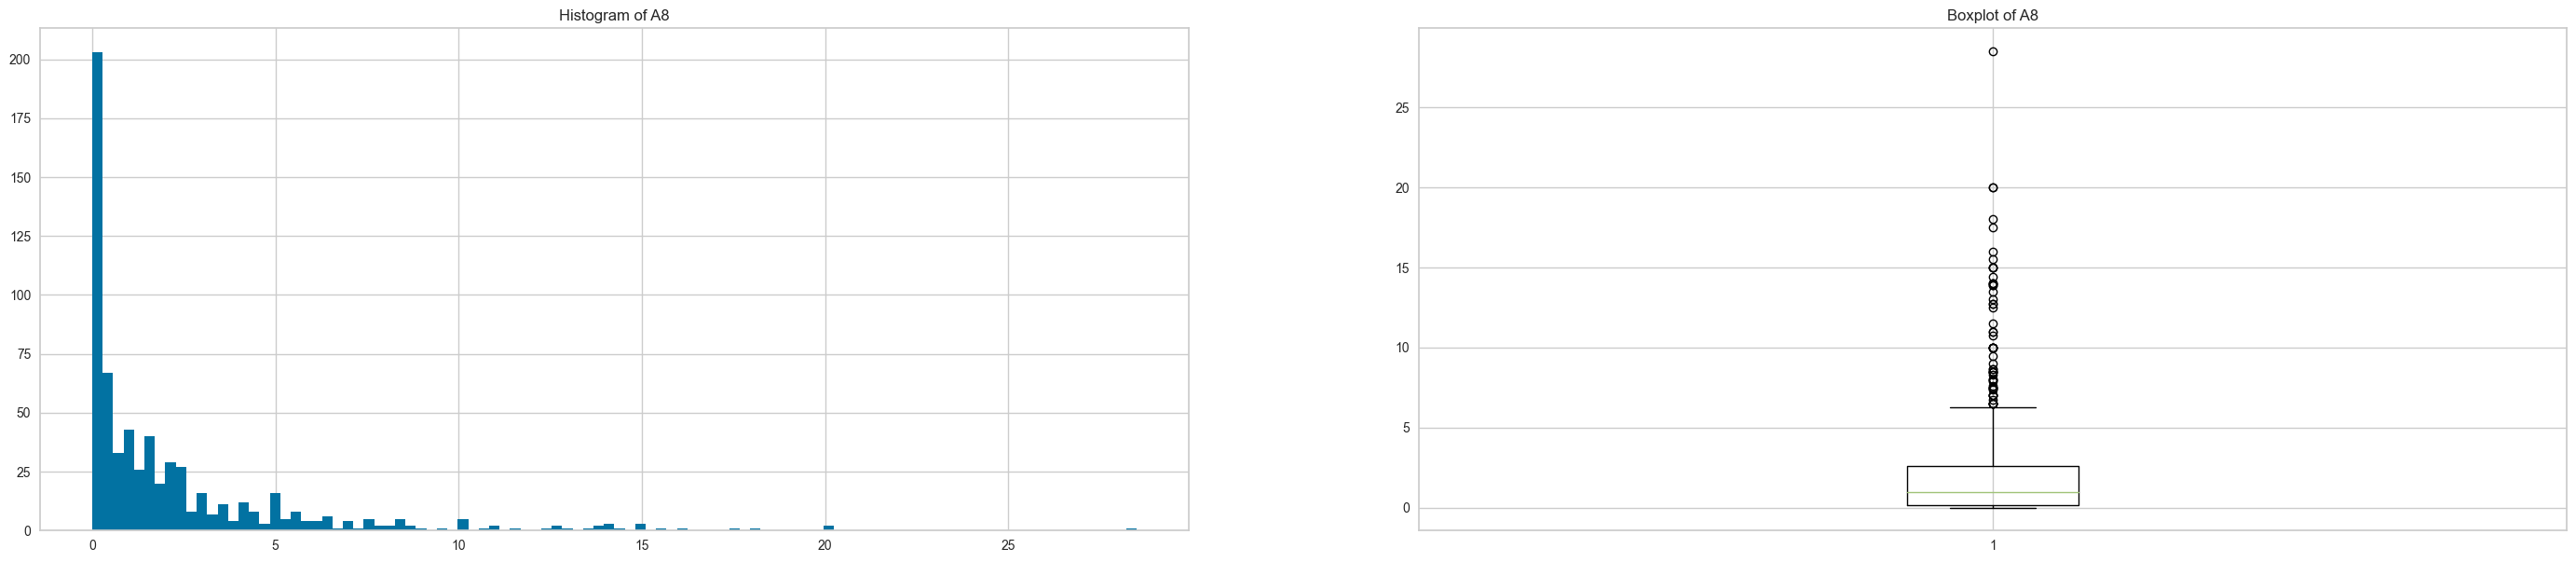

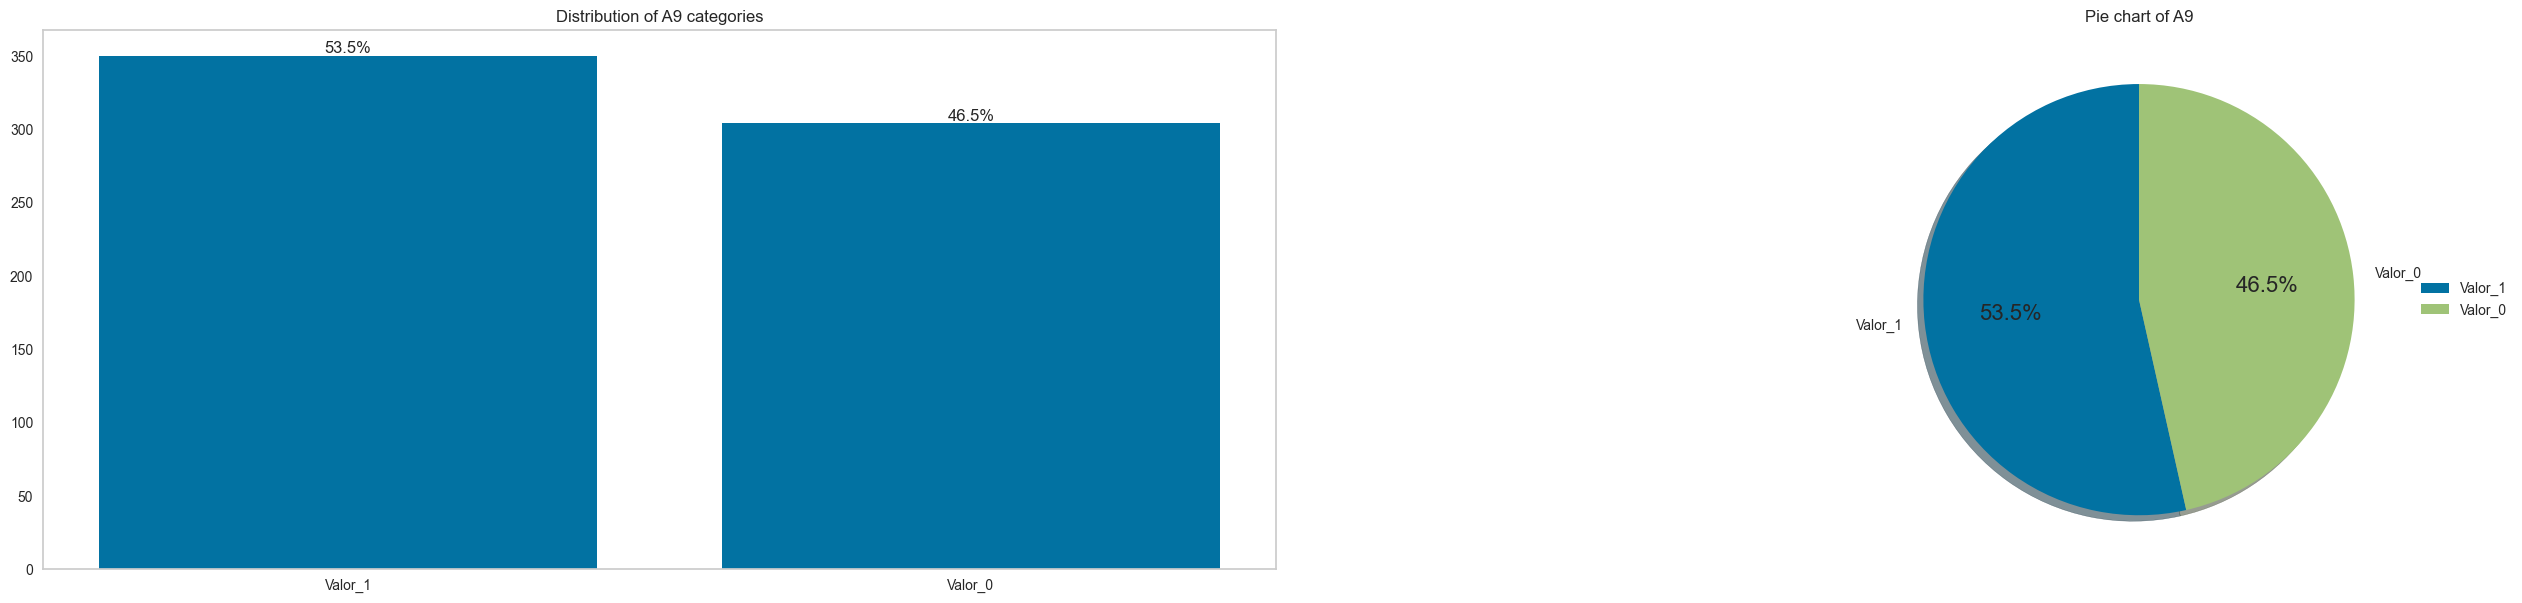

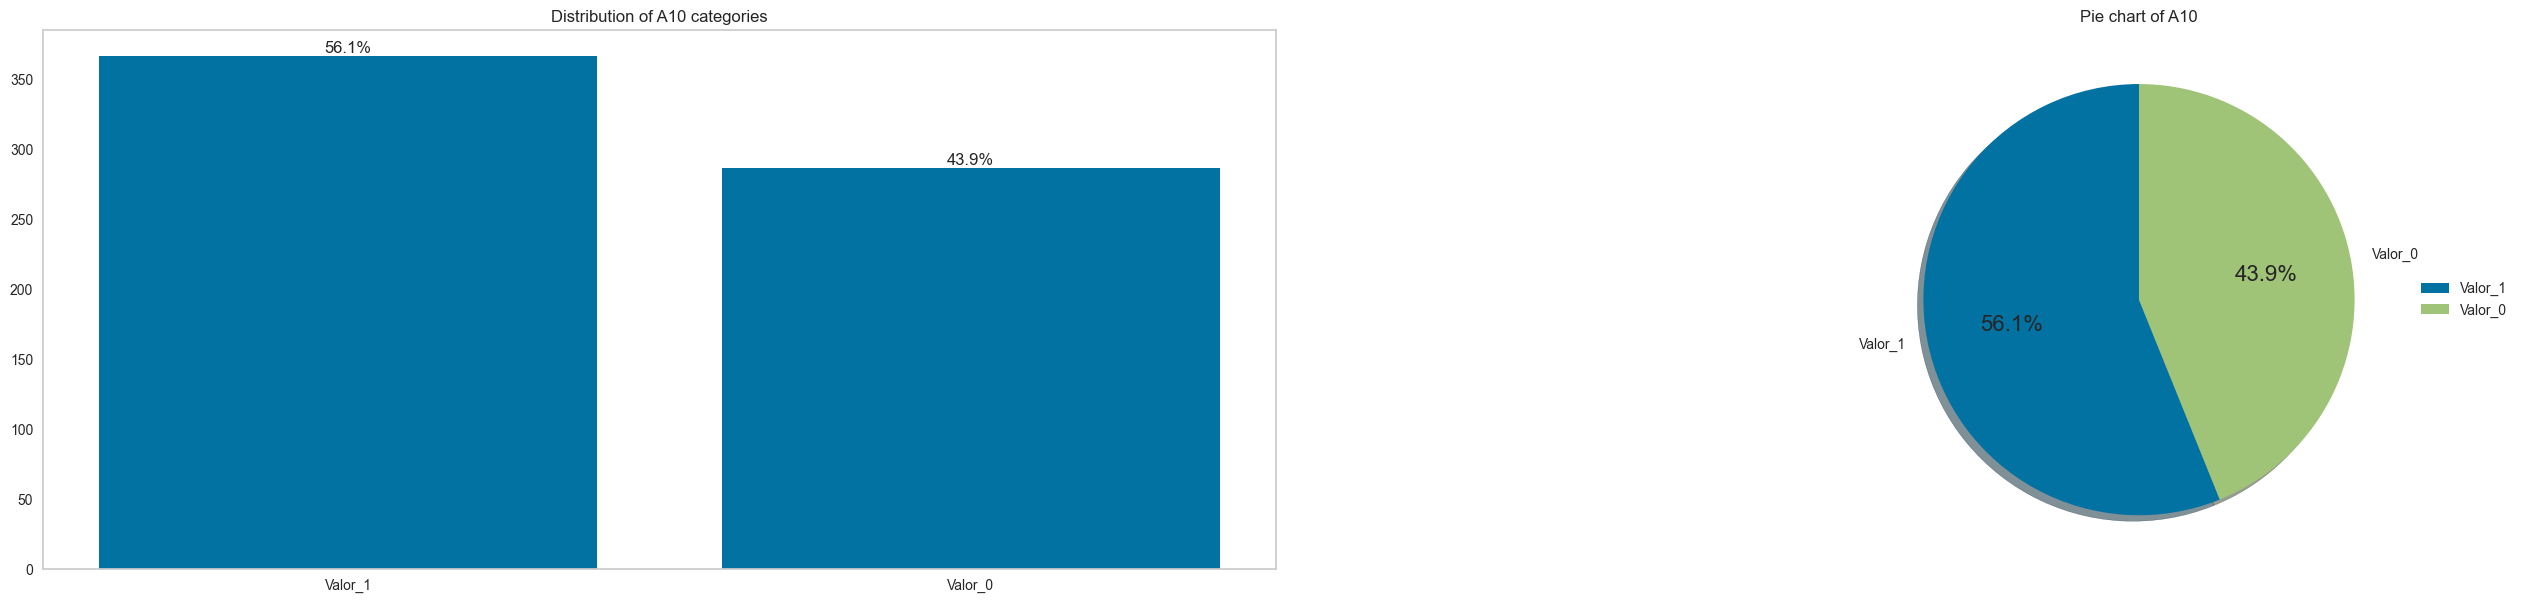

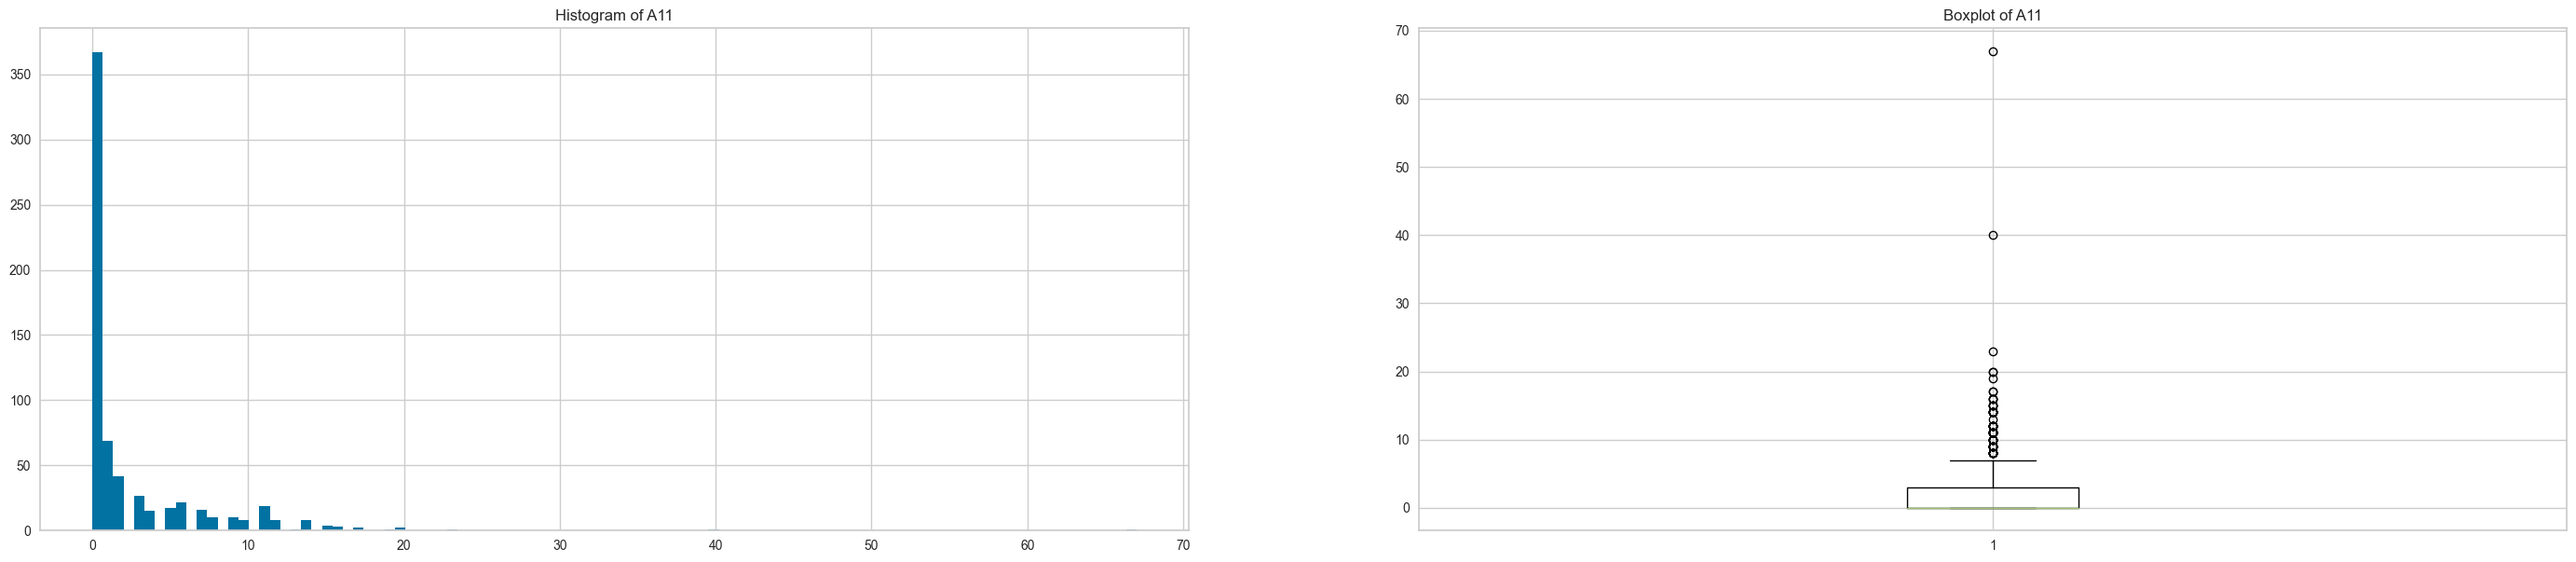

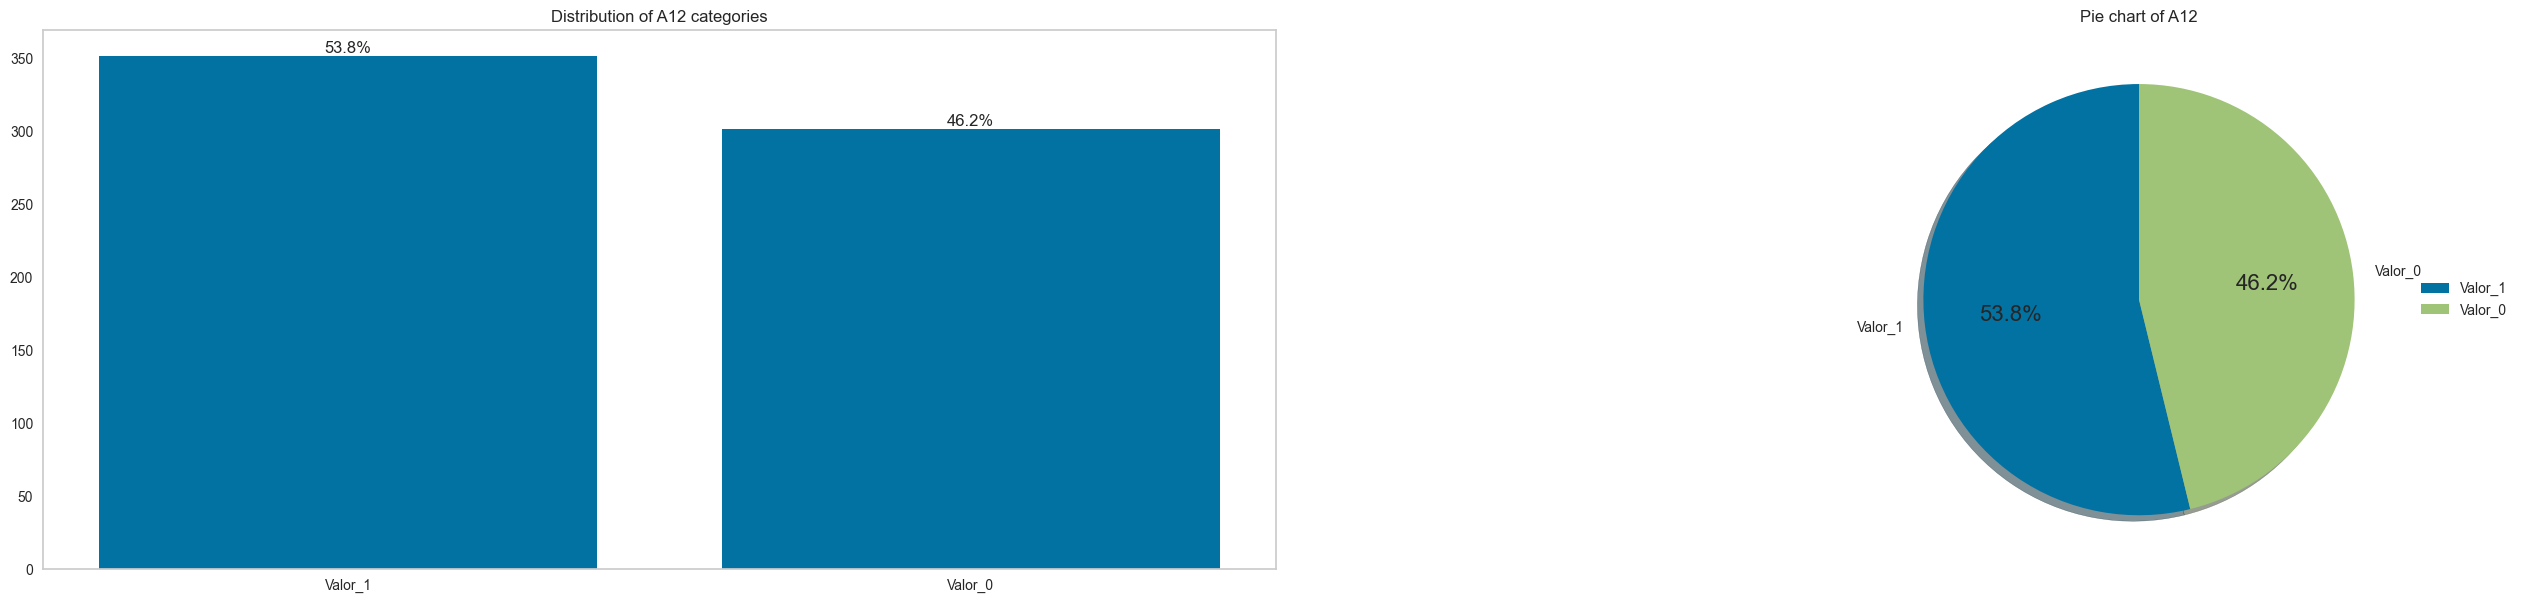

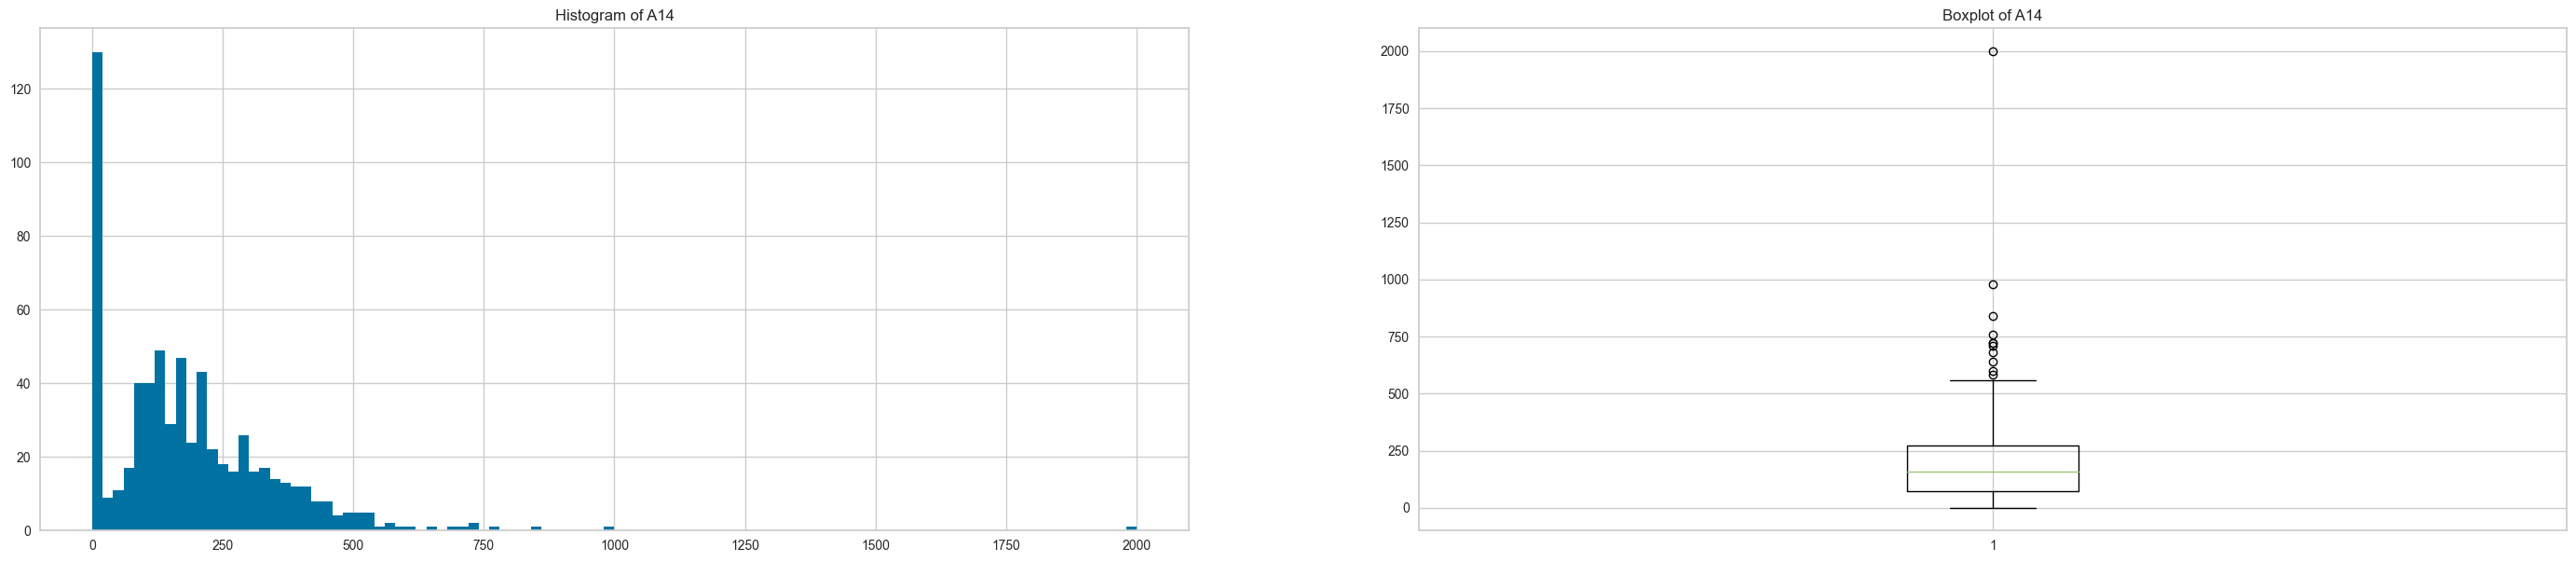

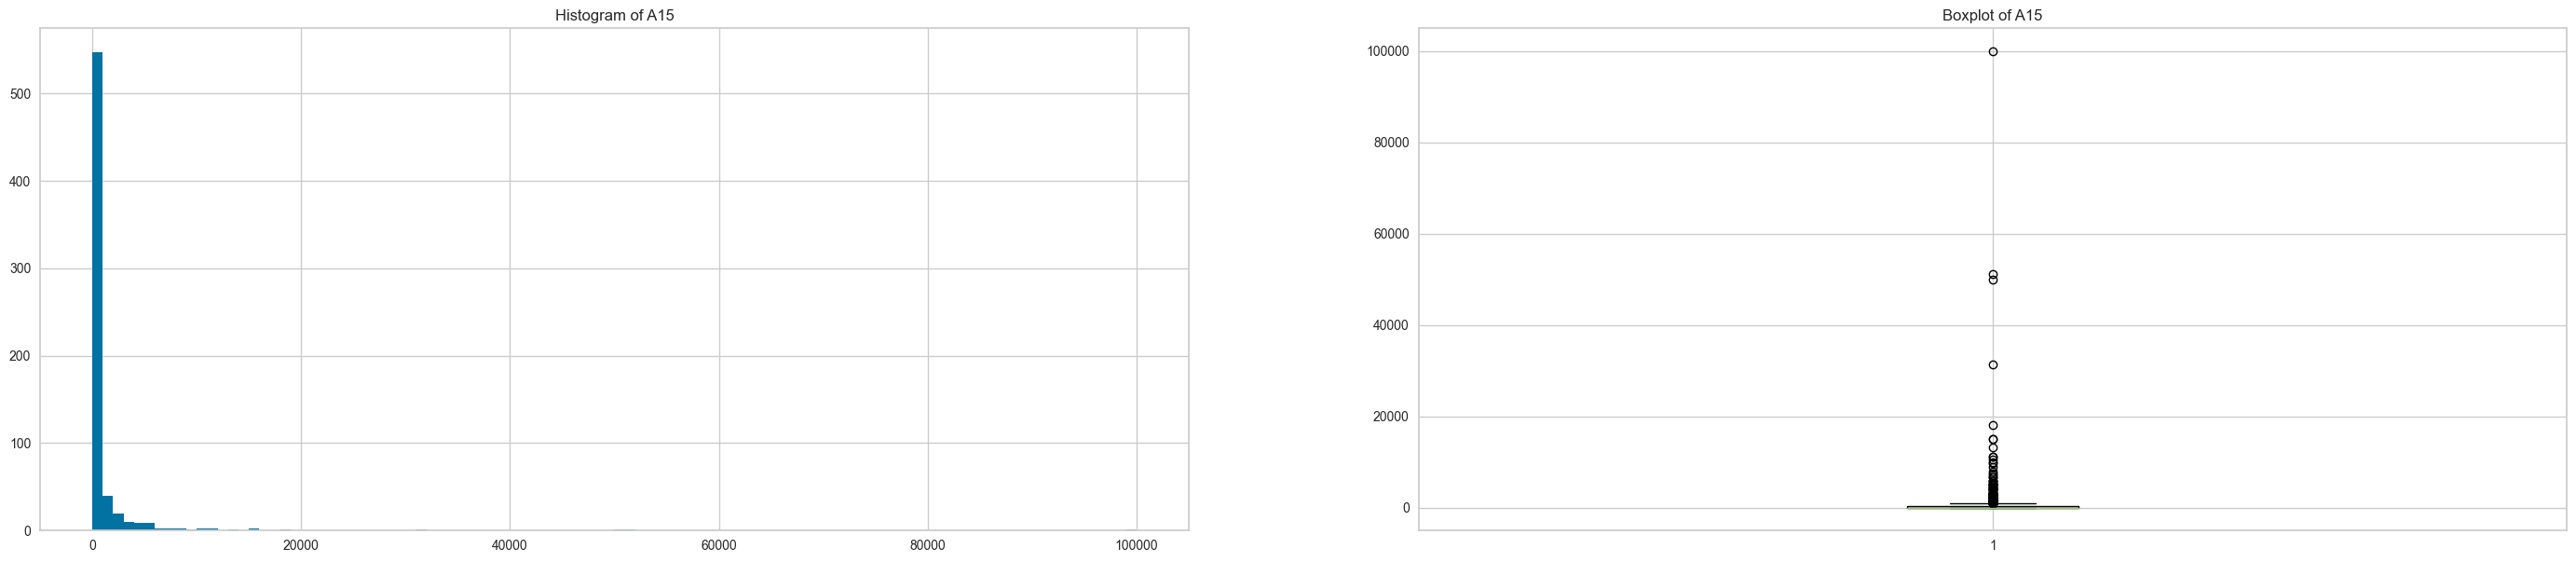

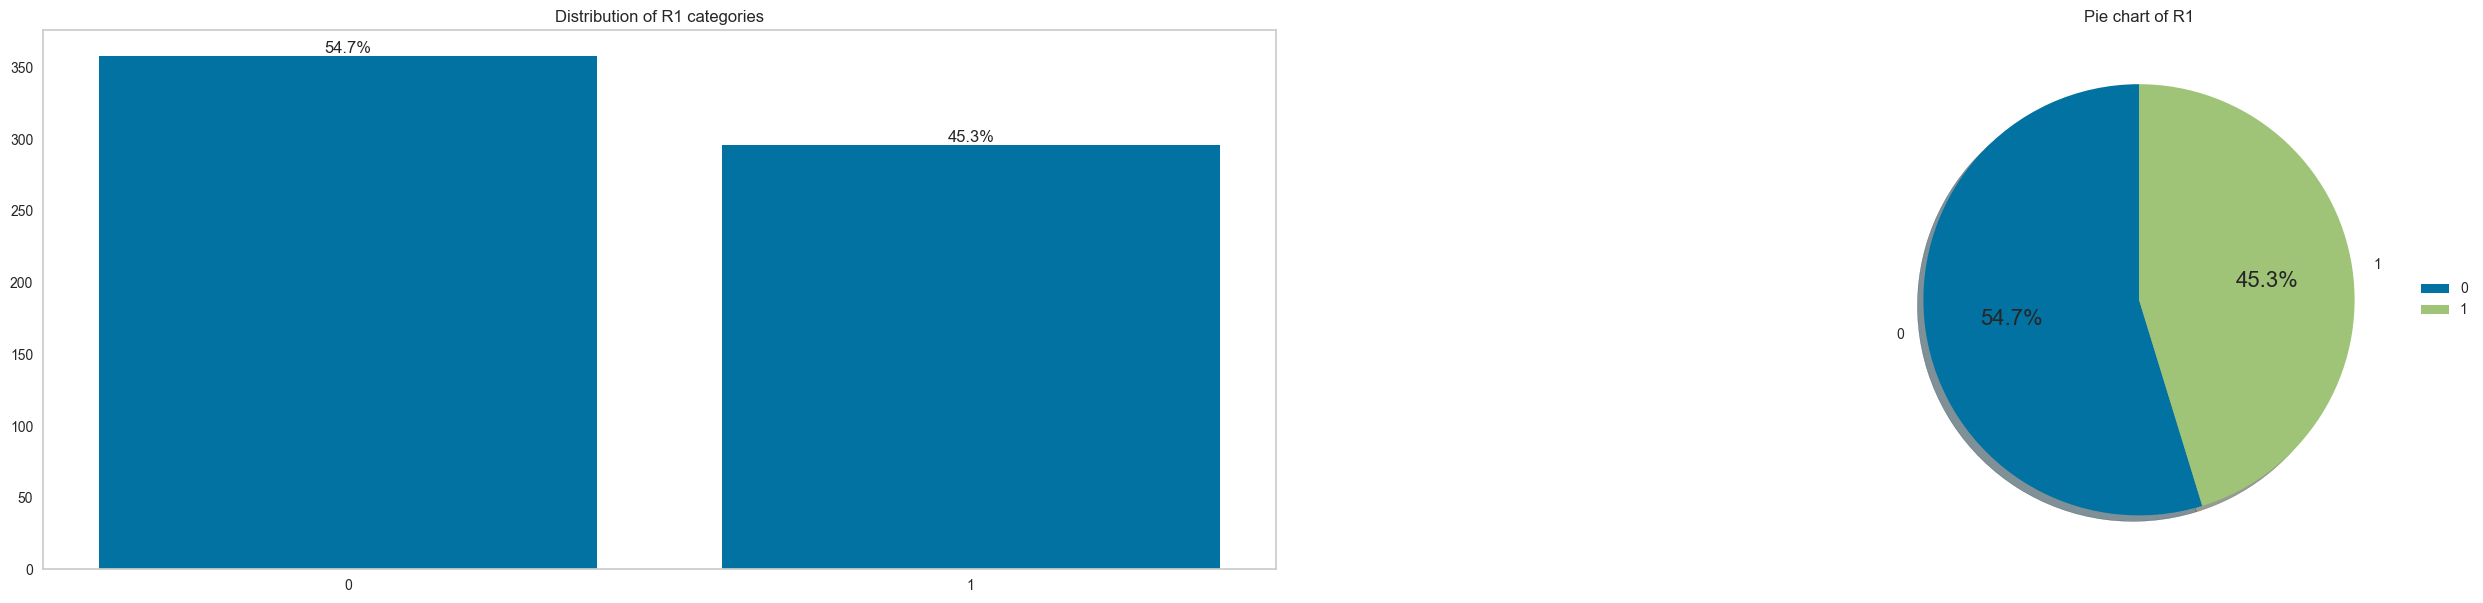

In [84]:
# Reporte Univariado
plot_graph_initial(df_analisis_uni, meta)

## Analisis Preliminar Bivariado


*  Se tomará en cuenta como parte del análisis la **mediana** y la **media** teniendo en cuenta que los valores de la media son afectados por los valores outliers en la mayoría de las variables cuantitativas
*  Se tomará en cuenta la cantidad de categorías de cada variable cualitativa
*  La intensidad de color en cada boxplot ayudaría a saber la concentración de valores en cada boxplot (densidad). **El gráfico del tipo Violinplot** será empleado ya que ayudará a reflejar esta característica

### Análisis de la variable A2 y la variable A1 con el Target R1

In [85]:
data_agrupada = df_analisis.groupby(['A1'],as_index=False).agg({'R1': 'count','A2': ['mean','median','std']})
data_agrupada.columns = ['_'.join(map(str,col)).strip() for col in data_agrupada.columns.values]
data_agrupada.rename(columns={'A1_':'A1','R1_count':'nro_solicitudes'},inplace=True)
data_agrupada.sort_values(by=['A2_median'],ascending=False)
data_agrupada

A1  nro_solicitudes    A2_mean  A2_median     A2_std
0  Valor_0              203  30.760985      26.08  12.542158
1  Valor_1              451  31.946253      29.58  11.716503

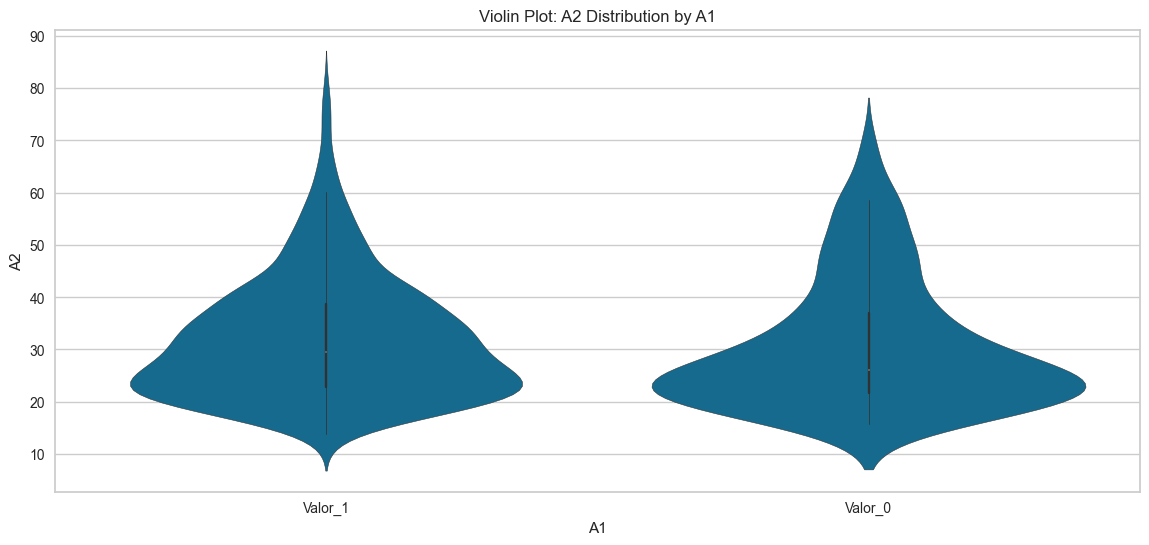

In [86]:
fig, ax = plt.subplots(1, figsize=(14,6))
sns.violinplot(x=df_analisis['A1'], y=df_analisis['A2'],
            order = df_analisis.groupby(by=["A1"])["A2"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 0)
plt.title("Violin Plot: A2 Distribution by A1")
plt.show()

Se interpreta lo siguiente:
- Se observa que la densidad de los valores de la categoría valor_0 se encuentra entre 20 y 30, mientras que para el valor_1 se extiende hasta casi los 40. 
- La categoría valor_1 presenta mayor dispersión y amplitud con valores que superan los 80, es decir presenta una mayor variabilidad, posiblemente por la presencia de outliers que al categoría valor_0.

Se añade el target para una mejor interpretación:

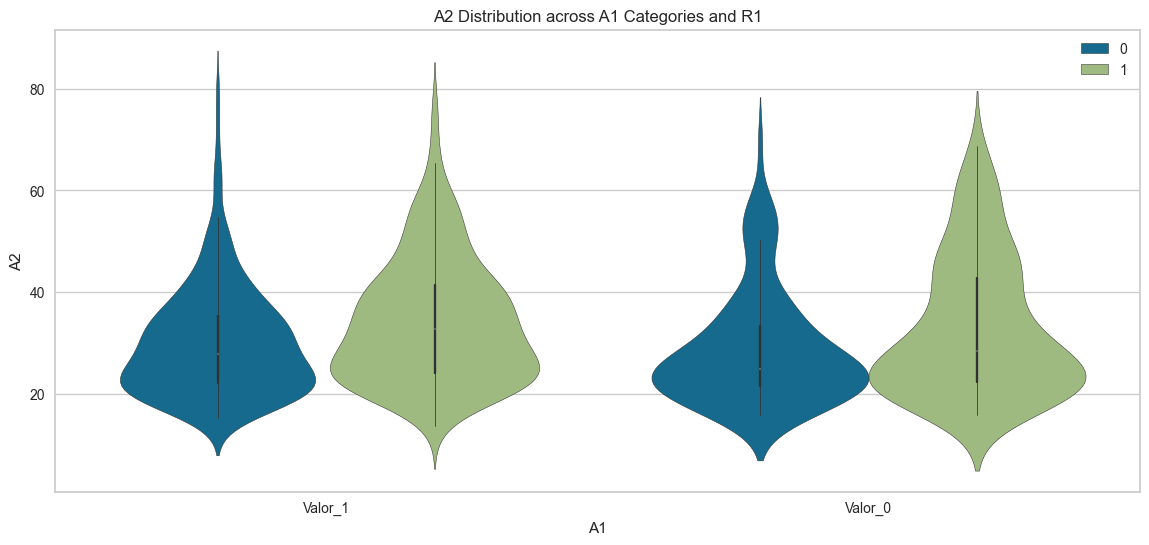

In [87]:
plt.subplots(1, figsize=(14,6))
sns.violinplot(x=df_analisis['A1'], y=df_analisis['A2'],hue=df_analisis['R1'],
               order = df_analisis.groupby(by=["A1"])["A2"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 0)
plt.legend(loc='upper right')
plt.title("A2 Distribution across A1 Categories and R1")
plt.show()

Se interpreta lo siguiente:

- **Solicitudes Rechazadas**: 
    - Se observa que la densidad de los valores de la categoría valor_0 se encuentra entre 20 y 30, mientras que para el valor_1 se extiende hasta casi los 40. 
    - La distribución más amplia en valor_1, con valores que se extienden hasta casi los 40, muestra una mayor variabilidad y posibles outliers, indicando que esta categoría incluye casos extremos o menos comunes.
- **Solicitudes Aceptadas**: 
    - Ambas categorías presentan una alta densidad alrededor de los 20 y 30, así mismo, la categoría valor_1 presenta un aumento de densidad sobre los 40. **Esto sugiere que la aceptación de solicitudes tiene un comportamiento más concentrado en ciertos rangos de valores de A2.**
    - La mayor dispersión y la amplitud en la categoría valor_1, con valores que superan los 80, nuevamente indican una mayor variabilidad y la posible presencia de outliers.

### Análisis de la variable A3 y la variable A10 con el Target R1

In [88]:
data_agrupada = df_analisis.groupby(['A10'],as_index=False).agg({'R1': 'count','A3': ['mean','median','std']})
data_agrupada.columns = ['_'.join(map(str,col)).strip() for col in data_agrupada.columns.values]
data_agrupada.rename(columns={'A10_':'A10','R1_count':'nro_solicitudes'},inplace=True)
data_agrupada.sort_values(by=['A3_median'],ascending=False)
data_agrupada

A10  nro_solicitudes   A3_mean  A3_median    A3_std
0  Valor_0              287  5.771707       3.75  5.605719
1  Valor_1              367  4.094564       2.50  4.384888

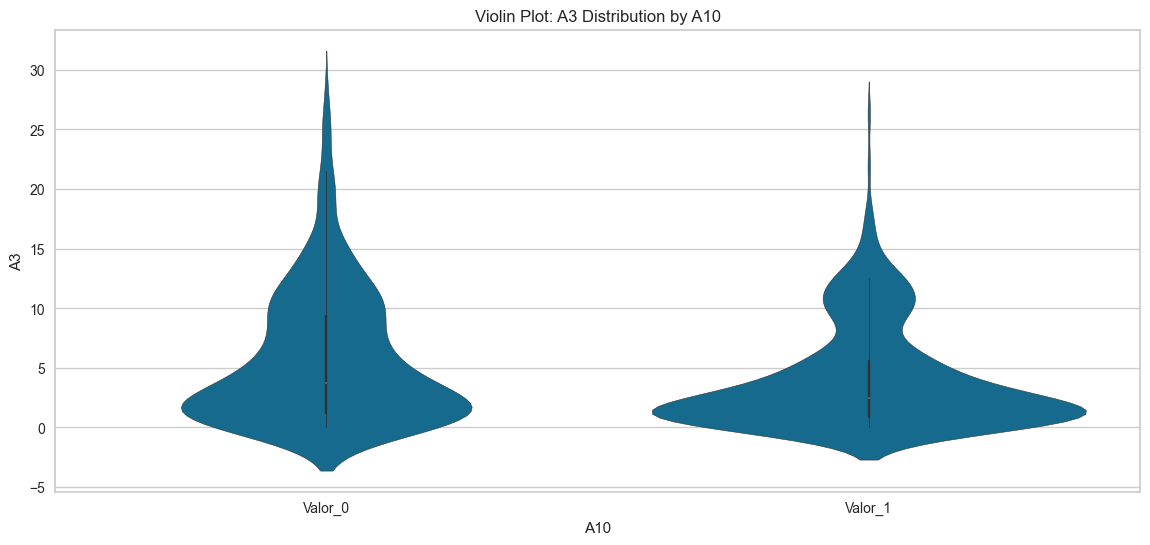

In [89]:
fig, ax = plt.subplots(1, figsize=(14,6))
sns.violinplot(x=df_analisis['A10'], y=df_analisis['A3'],
            order = df_analisis.groupby(by=["A10"])["A3"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 0)
plt.title("Violin Plot: A3 Distribution by A10")
plt.show()

Se interpreta lo siguiente:
- Si bien la densidad para valor_0 y valor_1 es cercano a cero, el valor_1 presenta mayor densidad en este rango.
- Existe un ligero aumento de densidad cercano al valor de 10 para ambas categorías, siendo ligeramente de mayor en la categoría de valor_1.
- Por otro lado el valor_0 presenta mayor dispersión y amplitud con valores que superan los 30, es decir presenta una mayor variabilidad, posiblemente por la presencia de outliers.

Se añade el target para una mejor interpretación:

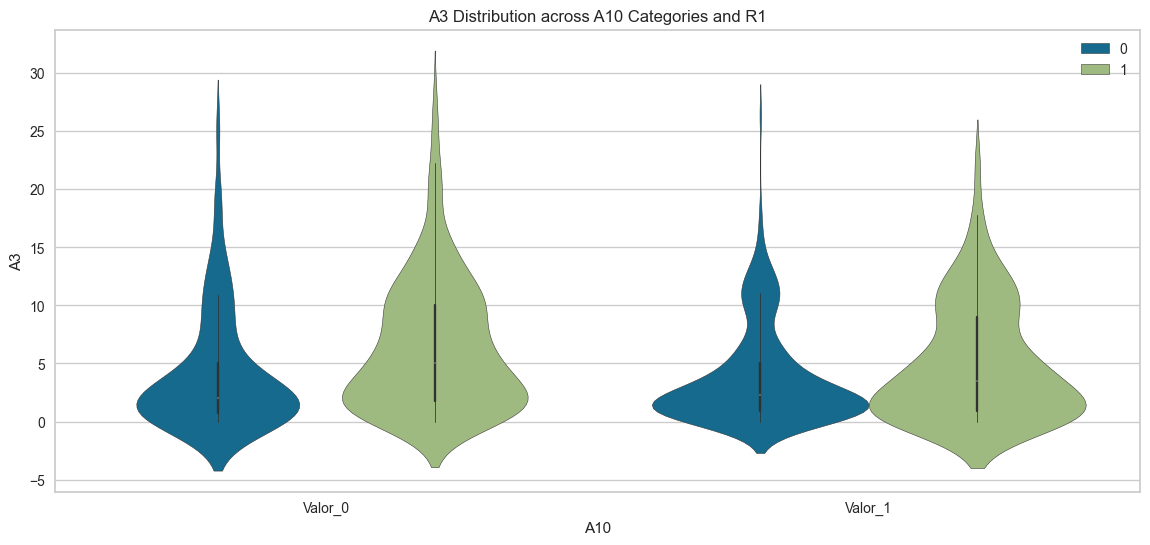

In [90]:
plt.subplots(1, figsize=(14,6))
sns.violinplot(x=df_analisis['A10'], y=df_analisis['A3'],hue=df_analisis['R1'],
               order = df_analisis.groupby(by=["A10"])["A3"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 0)
plt.legend(loc='upper right')
plt.title("A3 Distribution across A10 Categories and R1")
plt.show()

Se interpreta lo siguiente:

- **Solicitudes Rechazadas**: 
    - Si bien la densidad para valor_0 y valor_1 es cercano a cero, el valor_1 presenta mayor densidad en este rango.
    - Existe un ligero aumento de densidad cercano al valor de 10 en la categoría de valor_1.
    - El valor_0 presenta mayor dispersión y amplitud con valores cercanos a los 30, es decir presenta una mayor variabilidad, posiblemente por la presencia de outliers.

- **Solicitudes Aceptadas**: 
    - Ambas categorías presentan una alta densidad alrededor del cero, así mismo, la categoría valor_1 presenta un aumento de densidad sobre los 10.
    - El rango de amplitud es mayor en la categoría valor_0.
    - La categoría valor_0 tiene una distribución más extensa superando los 30 en comparación con el valor_1 que tiene un menor valor. Esto genera que los valores esten más dispersos, posiblemente por la presencia de valores outliers.


### Análisis de la variable A14 y la variable A12 con el Target R1

In [91]:
data_agrupada = df_analisis.groupby(['A12'],as_index=False).agg({'R1': 'count','A14': ['mean','median','std']})
data_agrupada.columns = ['_'.join(map(str,col)).strip() for col in data_agrupada.columns.values]
data_agrupada.rename(columns={'A12_':'A12','R1_count':'nro_solicitudes'},inplace=True)
data_agrupada.sort_values(by=['A14_median'],ascending=False)
data_agrupada

A12  nro_solicitudes    A14_mean  A14_median     A14_std
0  Valor_0              302  205.688742       172.5  168.611535
1  Valor_1              352  158.116477       129.5  165.158701

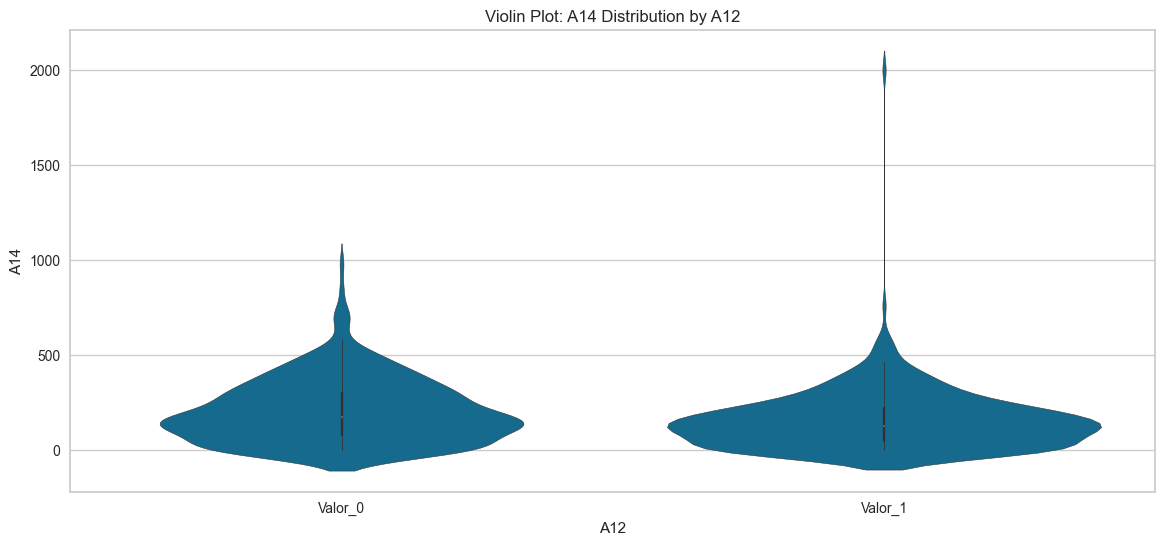

In [92]:
fig, ax = plt.subplots(1, figsize=(14,6))
sns.violinplot(x=df_analisis['A12'], y=df_analisis['A14'],
            order = df_analisis.groupby(by=["A12"])["A14"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 0)
plt.title("Violin Plot: A14 Distribution by A12")
plt.show()

Se interpreta lo siguiente:
- Si bien la densidad para valor_0 y valor_1 es cercano a cero, el valor_1 presenta mayor densidad en este rango. Esto se evidencia con una altura mayor cercano a este valor.
- El valor_1 presenta mayor dispersión y amplitud con valores que superan los 2000, es decir presenta una mayor variabilidad, posiblemente por la presencia de outliers.

Se añade el target para una mejor interpretación:

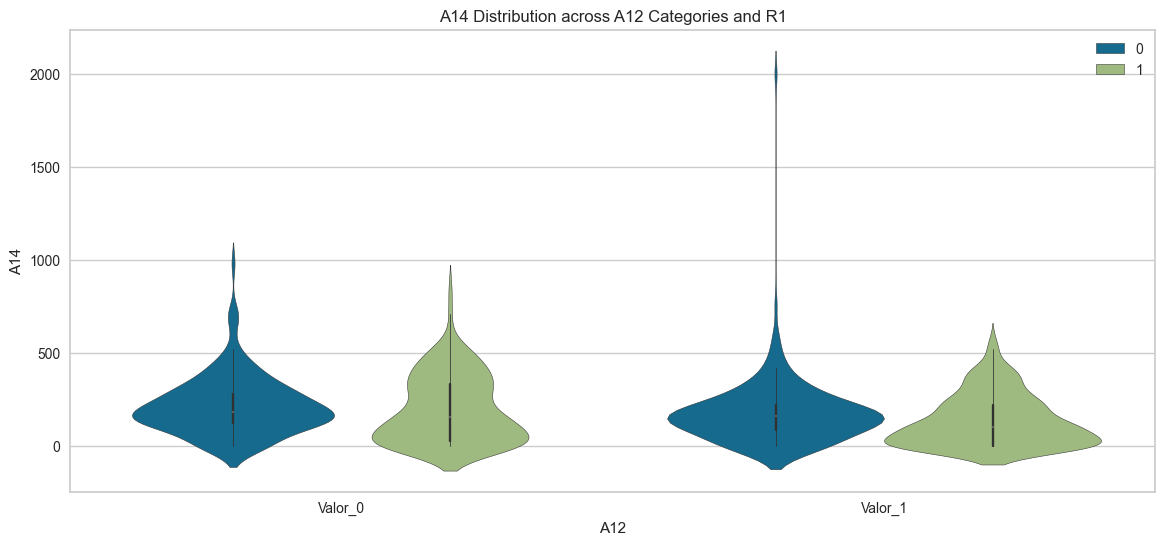

In [93]:
plt.subplots(1, figsize=(14,6))
sns.violinplot(x=df_analisis['A12'], y=df_analisis['A14'],hue=df_analisis['R1'],
               order = df_analisis.groupby(by=["A12"])["A14"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 0)
plt.legend(loc='upper right')
plt.title("A14 Distribution across A12 Categories and R1")
plt.show()

Se interpreta lo siguiente:

- **Solicitudes Rechazadas**: 
    - Si bien la densidad para valor_0 y valor_1 es cercano a cero, el valor_1 presenta mayor densidad en este rango. Esto se evidencia con una altura mayor cercano a este valor.
    - La categoría valor_1 presenta mayor dispersión y amplitud con valores que superan los 2000, es decir presenta una mayor variabilidad, posiblemente por la presencia de outliers.

- **Solicitudes Aceptadas**: 
    - Ambas categorías presentan una alta densidad alrededor del cero.
    - La categoría valor_0 tiene una distribución más extensa superando los 1000 en comparación con el valor_1 que tiene un menor valor. Esto genera que los valores esten más dispersos, posiblemente por la presencia de valores outliers.


### Análisis de la tasa de solicitud de tarjeta de crédito (Conversión con el target)

Para realizar el análisis de la tasa de solicitudes de tarjeta de crédito por categoría de cada variable cualitativa (pudiendo ser cuantitativa dividida en deciles) se emplea la tasa de conversión del target que me interesa (solicitud aceptada). **Se calcula tomando la cantidad de valores de R1 = 1 con respecto al total de valores de cada categoría**

In [94]:
# Se realiza una copia del dataframe de análisis
df_analisis_bi = df_analisis.copy()

In [95]:
df_analisis_bi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      654 non-null    object 
 1   A2      654 non-null    float64
 2   A3      654 non-null    float64
 3   A8      654 non-null    float64
 4   A9      654 non-null    object 
 5   A10     654 non-null    object 
 6   A11     654 non-null    int64  
 7   A12     654 non-null    object 
 8   A14     654 non-null    int64  
 9   A15     654 non-null    int64  
 10  R1      654 non-null    int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 56.3+ KB


In [96]:
# División de las variables según naturaleza
feat_numerical_bi = ['A2','A3','A8','A11','A14','A15']

feat_categorical_bi = ['A1','A9','A10','A12']

In [97]:
# Conversion del target ya que se toma el df_analisis en el que el target fue transformado
df_analisis_bi['R1']=df_analisis_bi['R1'].astype('int64')

for var in feat_categorical_bi:
  df_analisis_bi[var] = df_analisis_bi[var].astype('category')

In [98]:
# Creación del dataframe meta
v=pd.DataFrame({"variable": df_analisis_bi.columns.values})
t=pd.DataFrame({"tipo": df_analisis_bi.dtypes.values})
meta=pd.concat([v, t], axis=1)
meta=meta.loc[(meta['tipo']=='category')|(meta['tipo']=='float64')|(meta['tipo']=='int64'),:]
meta

variable      tipo
0        A1  category
1        A2   float64
2        A3   float64
3        A8   float64
4        A9  category
5       A10  category
6       A11     int64
7       A12  category
8       A14     int64
9       A15     int64
10       R1     int64

In [99]:
# Asegurar quitar el target en caso se encuentre
meta = meta.drop(meta.index[-1])
meta

variable      tipo
0       A1  category
1       A2   float64
2       A3   float64
3       A8   float64
4       A9  category
5      A10  category
6      A11     int64
7      A12  category
8      A14     int64
9      A15     int64

En el siguiente reporte se muestra el análisis de la tasa de solicitudes de tarjeta de crédito por categoría de cada variable cualitativa (pudiendo ser cuantitativa dividida en deciles) se emplea la tasa de conversión del target que me interesa (solicitud aceptada). **Se calcula tomando la cantidad de valores de R1 = 1 con respecto al total de valores de cada categoría**

A1


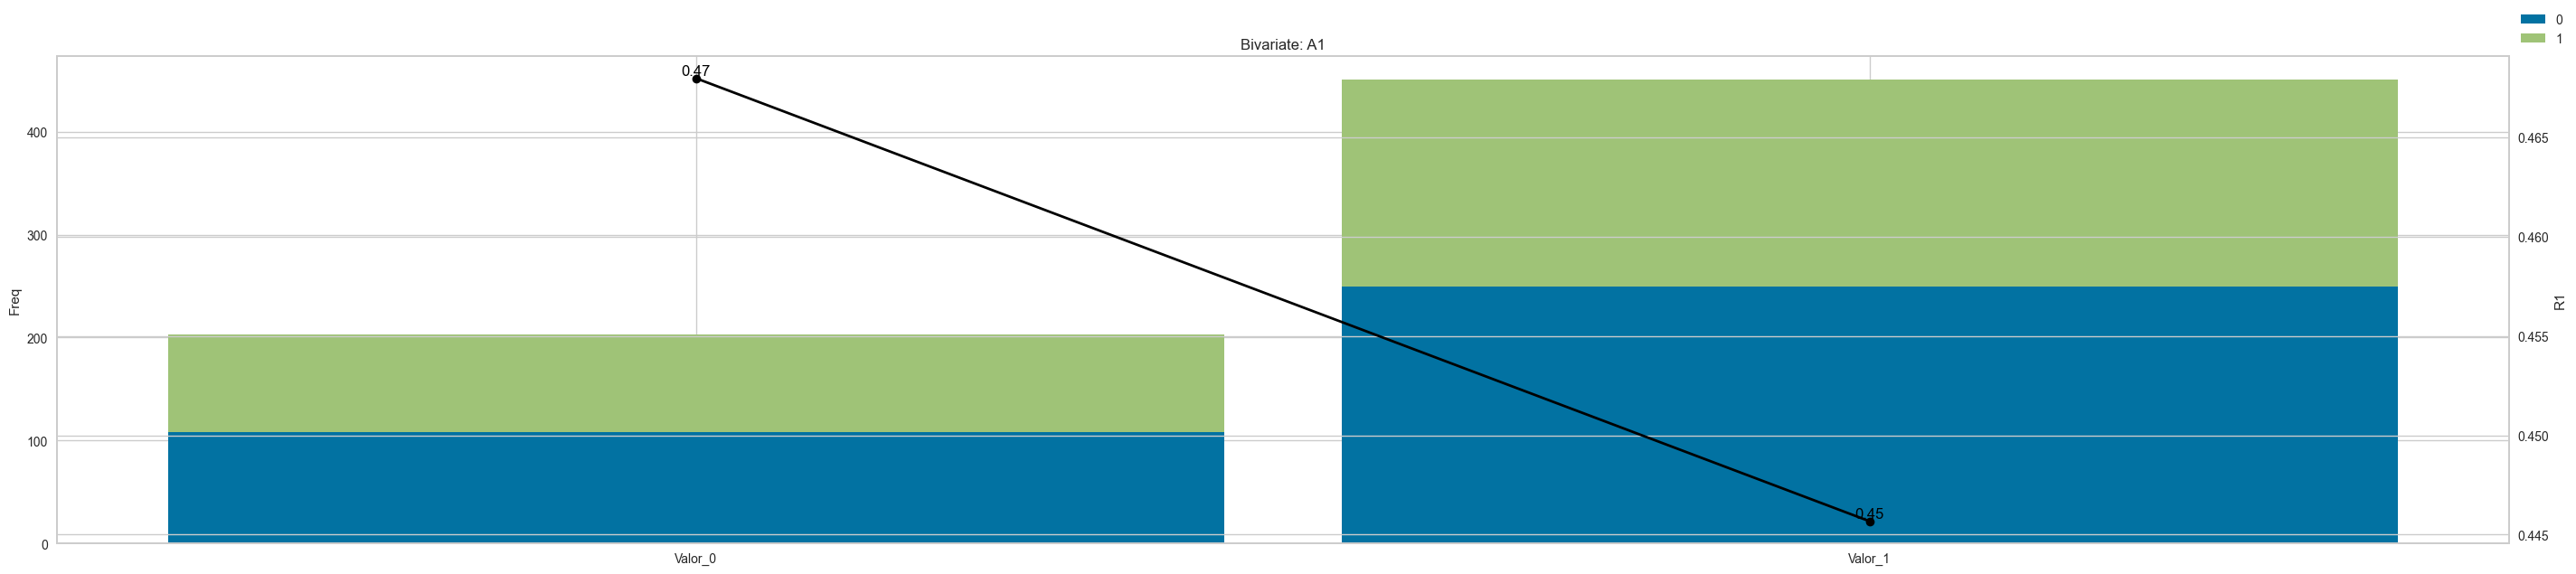

A2


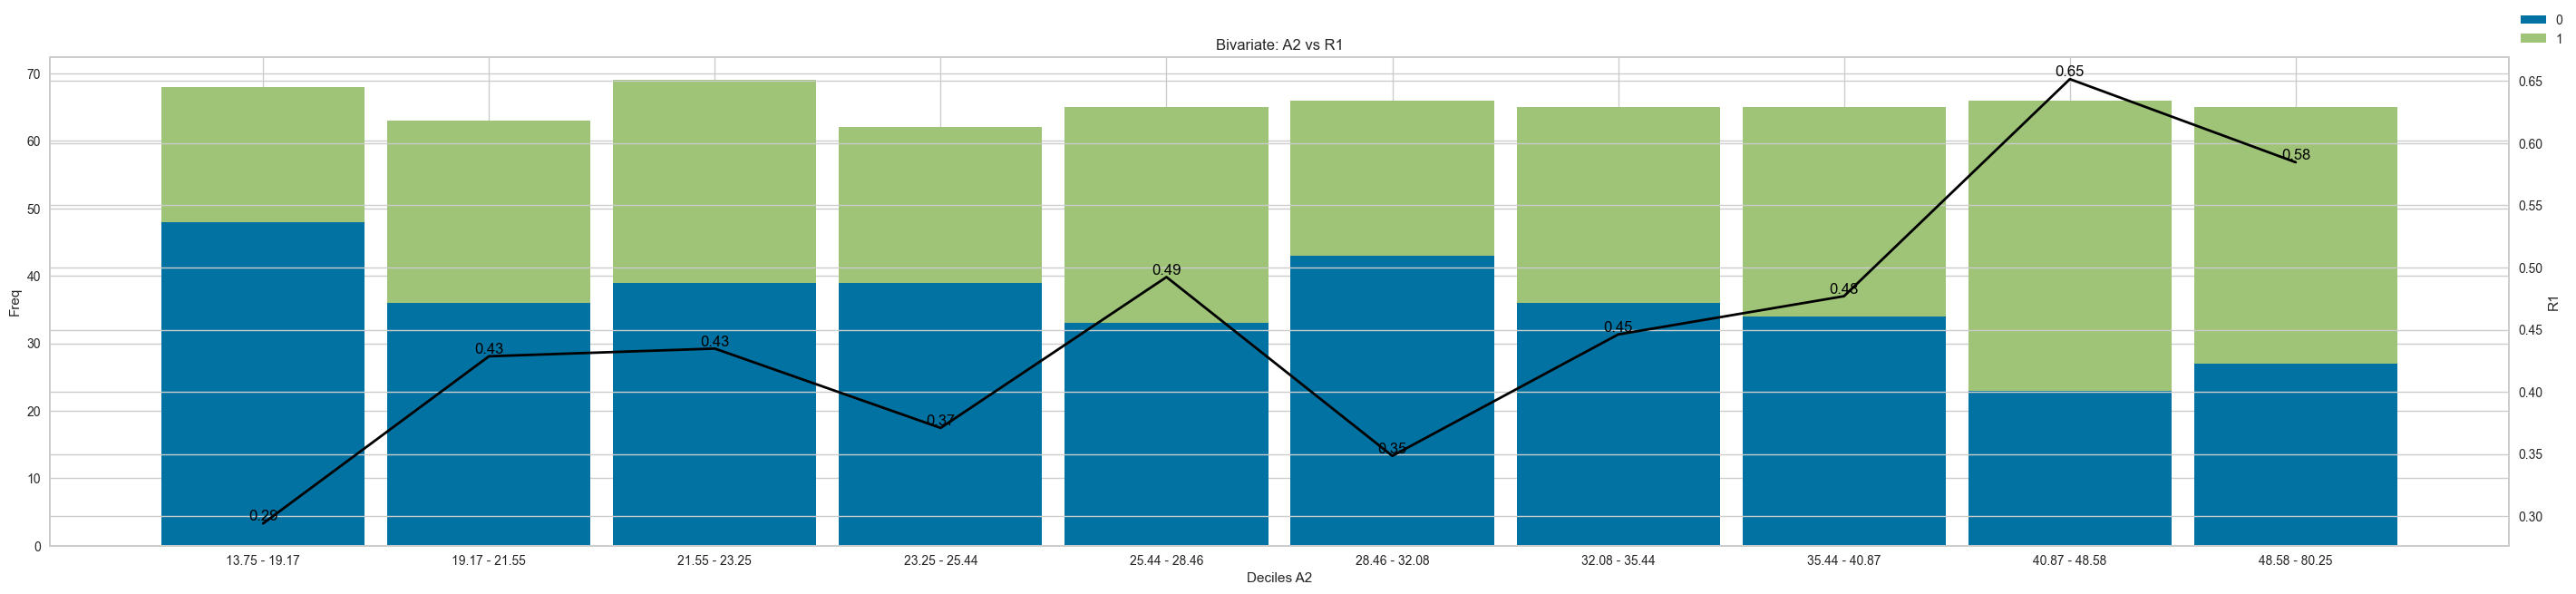

A3


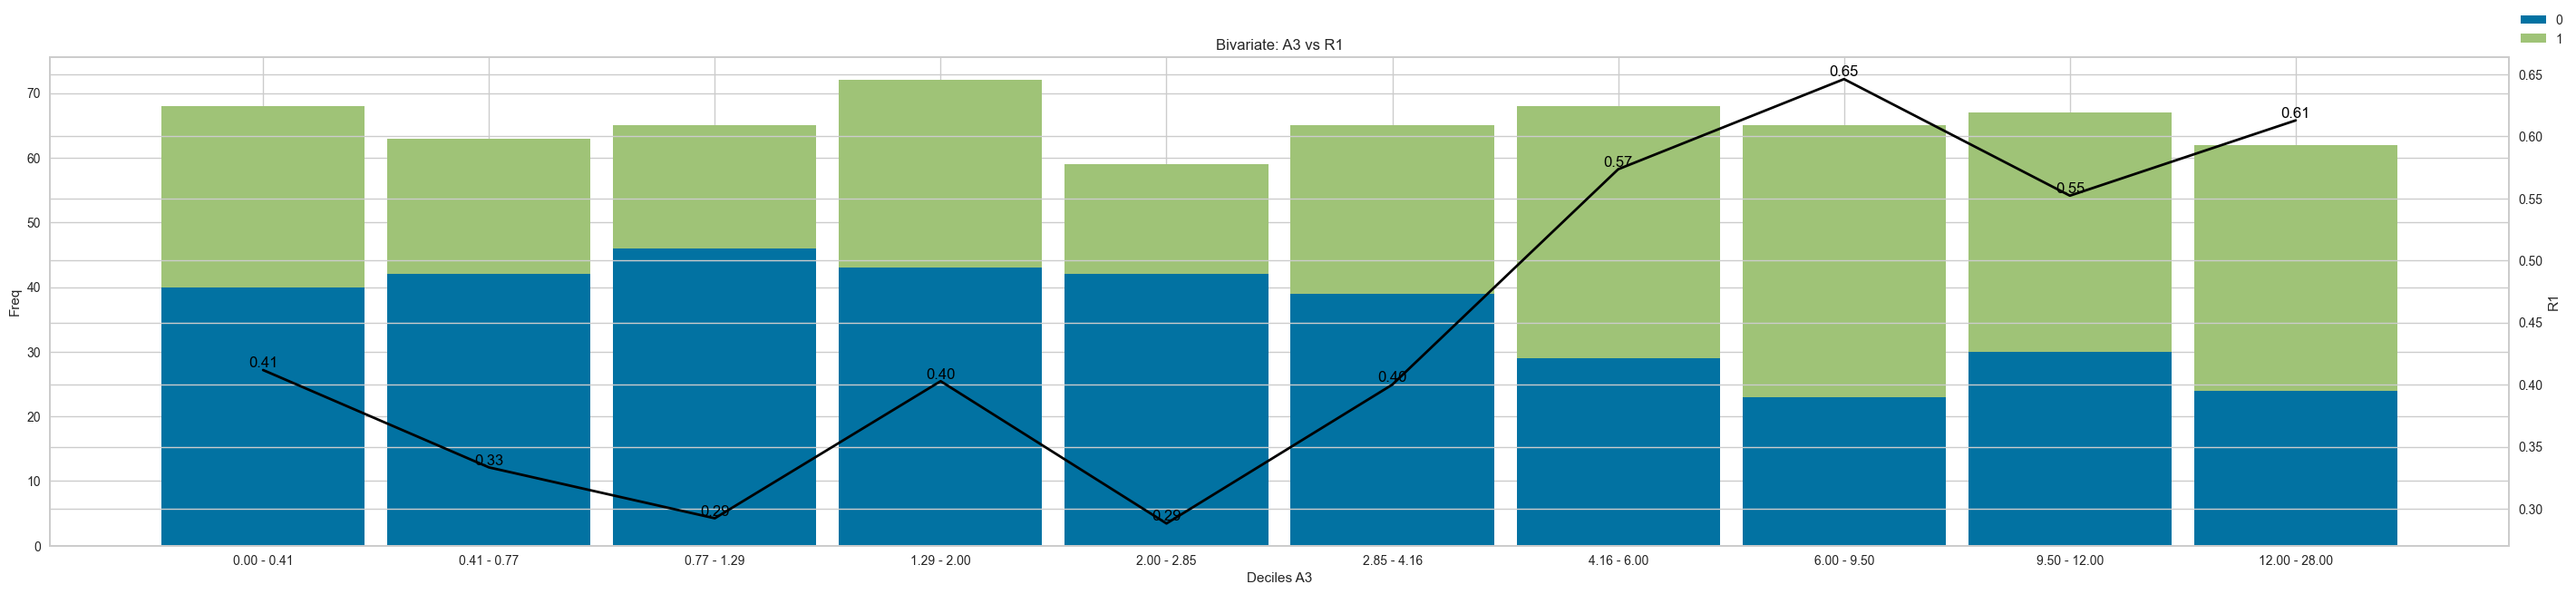

A8


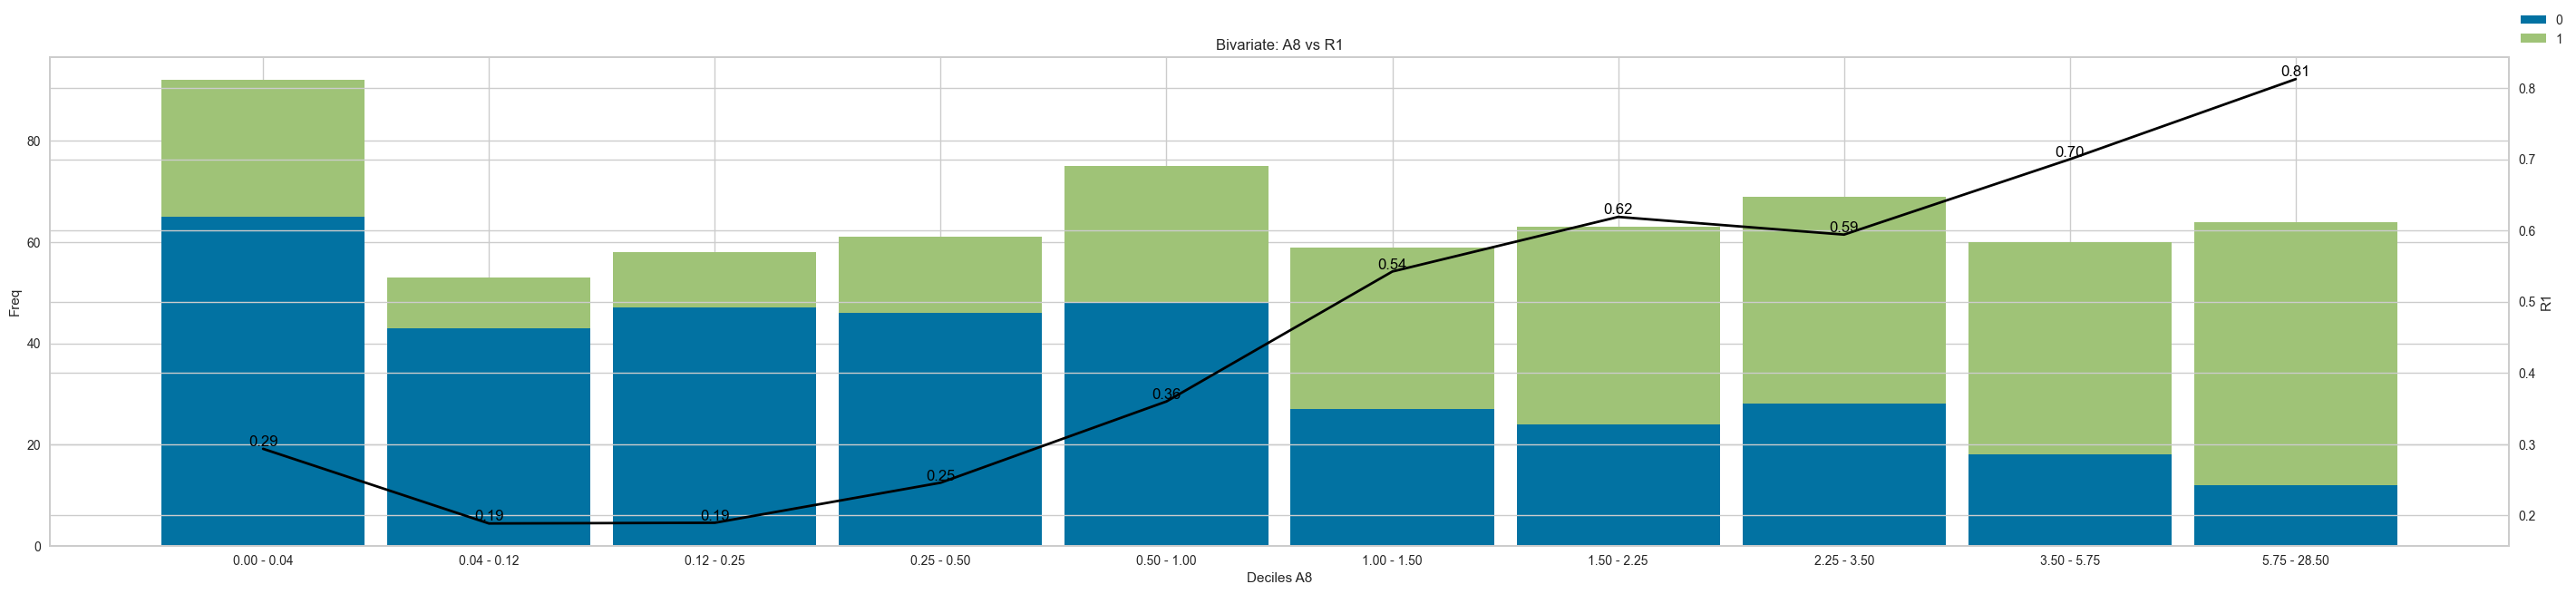

A9


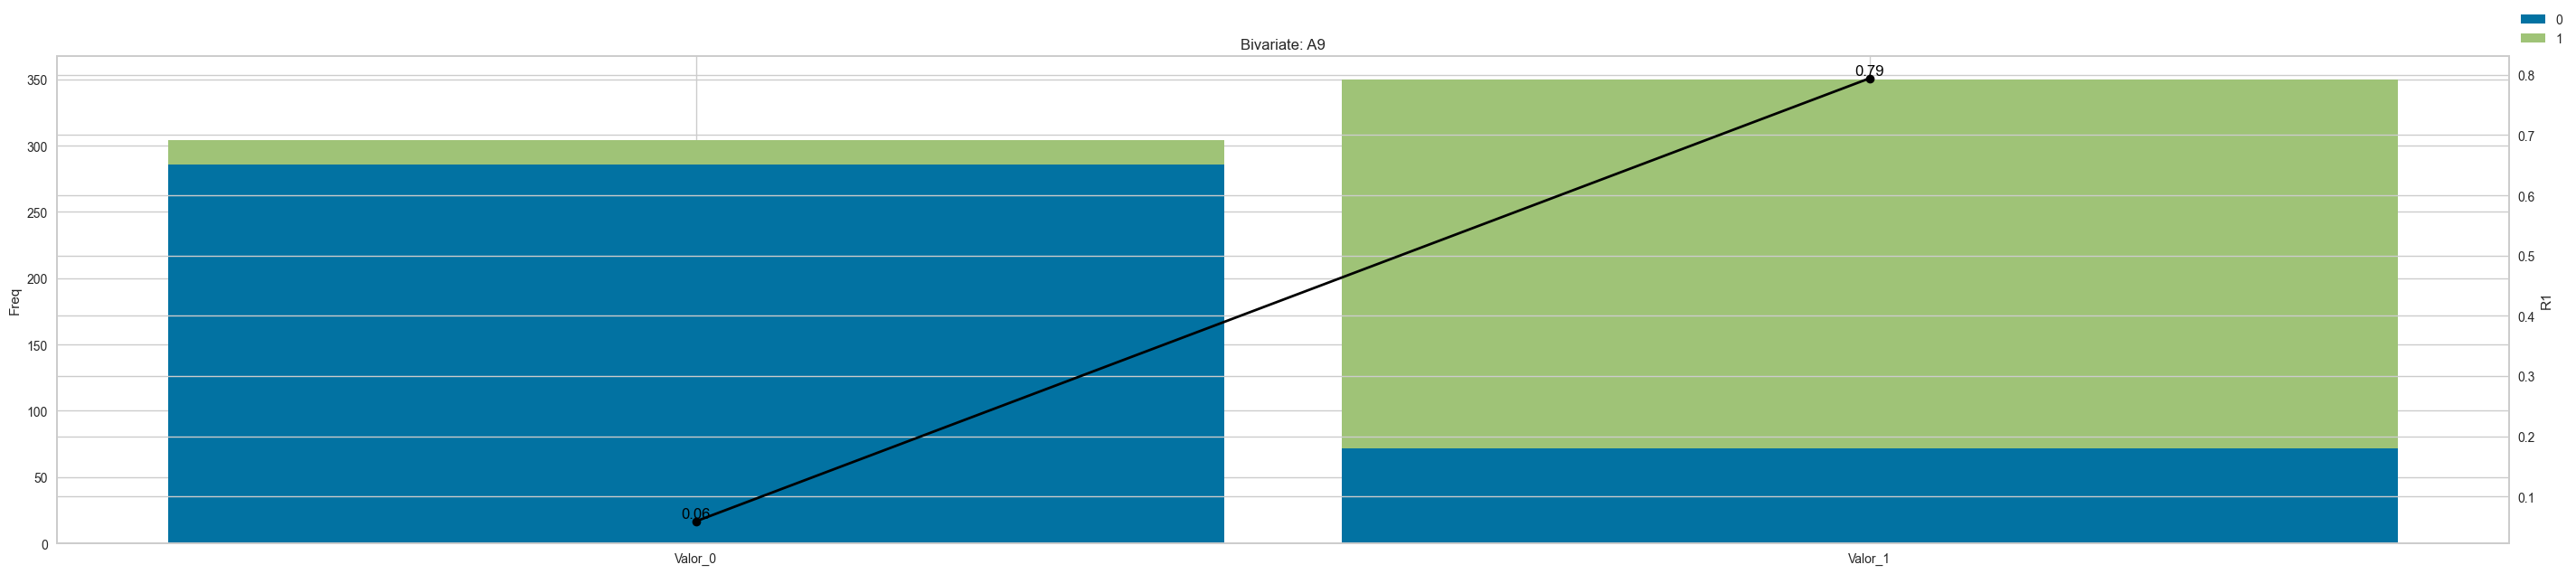

A10


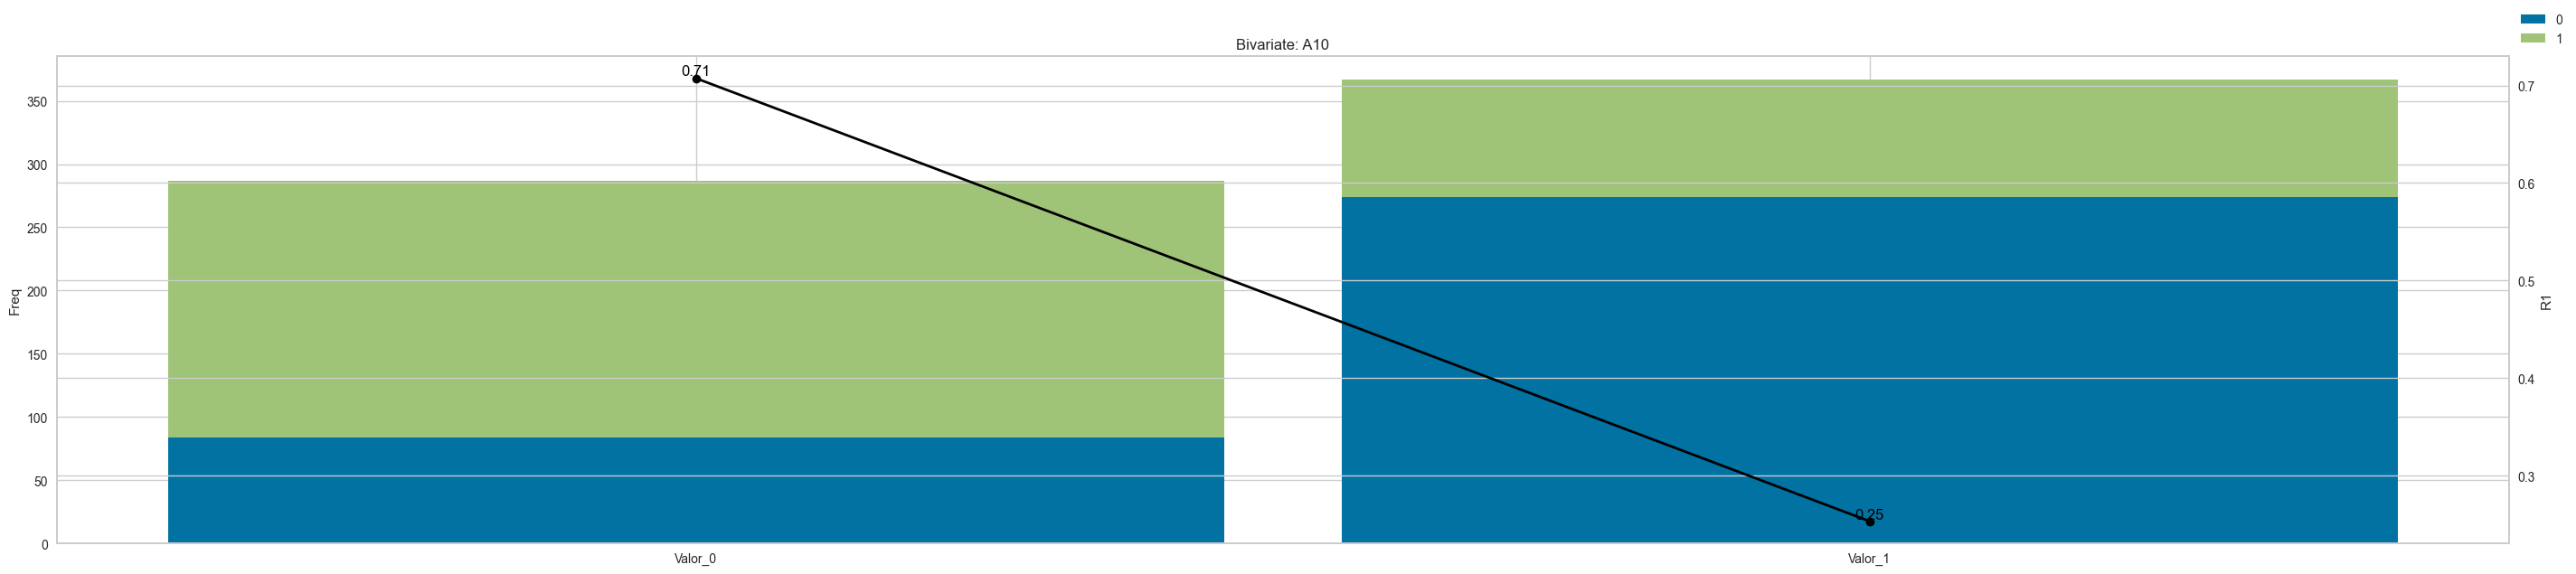

A11


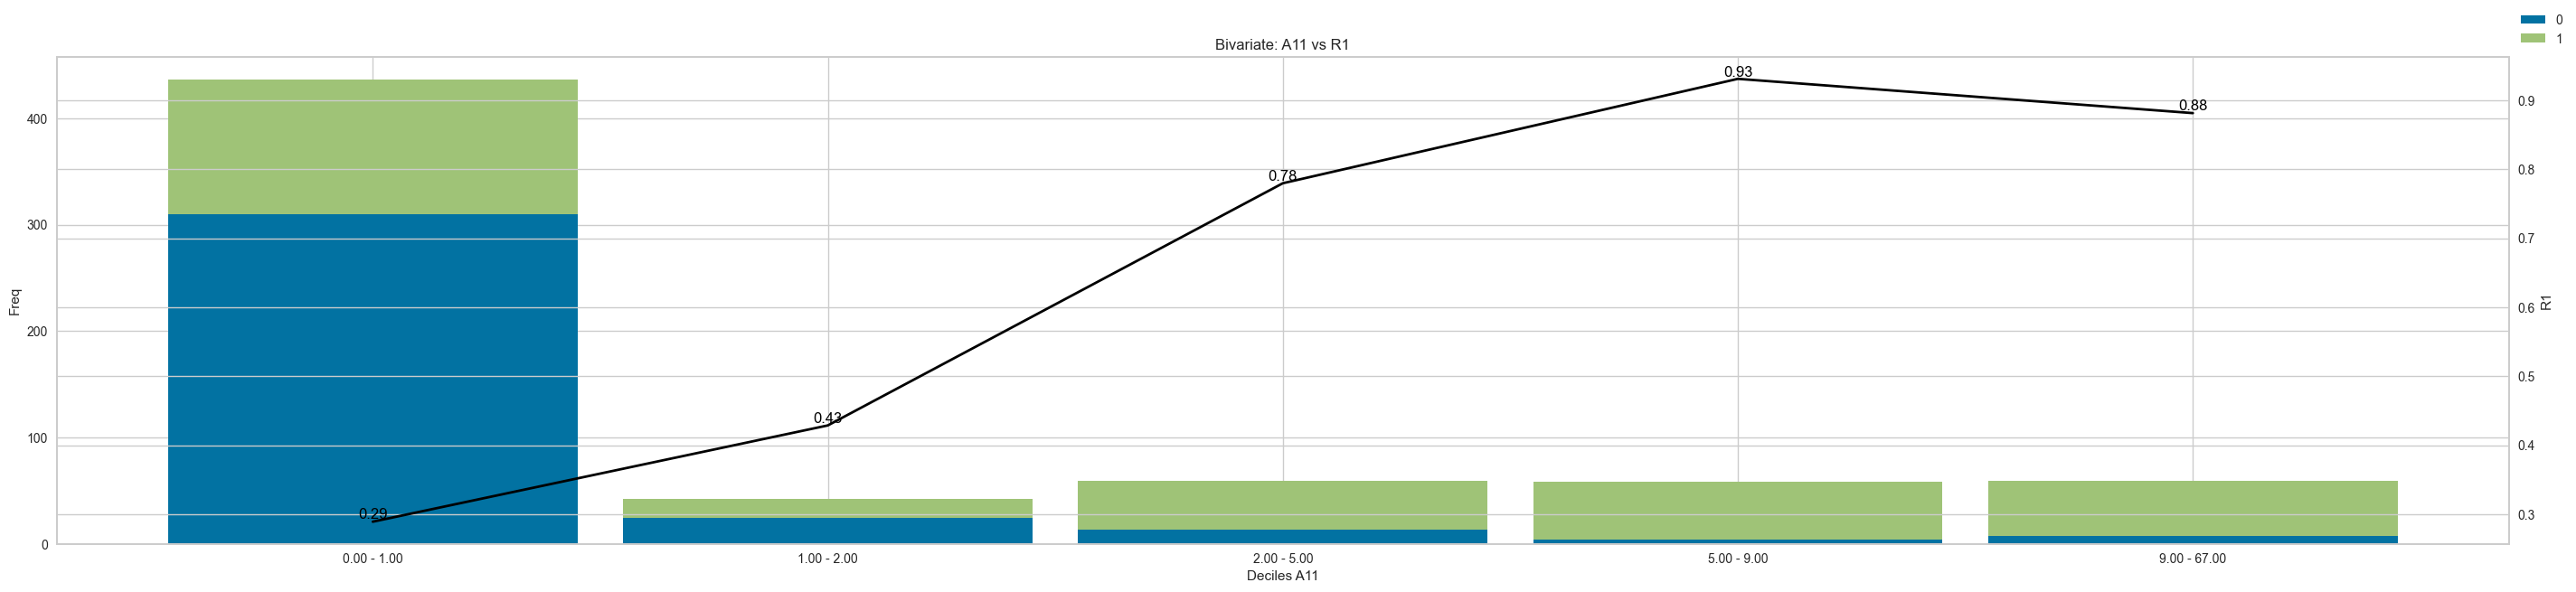

A12


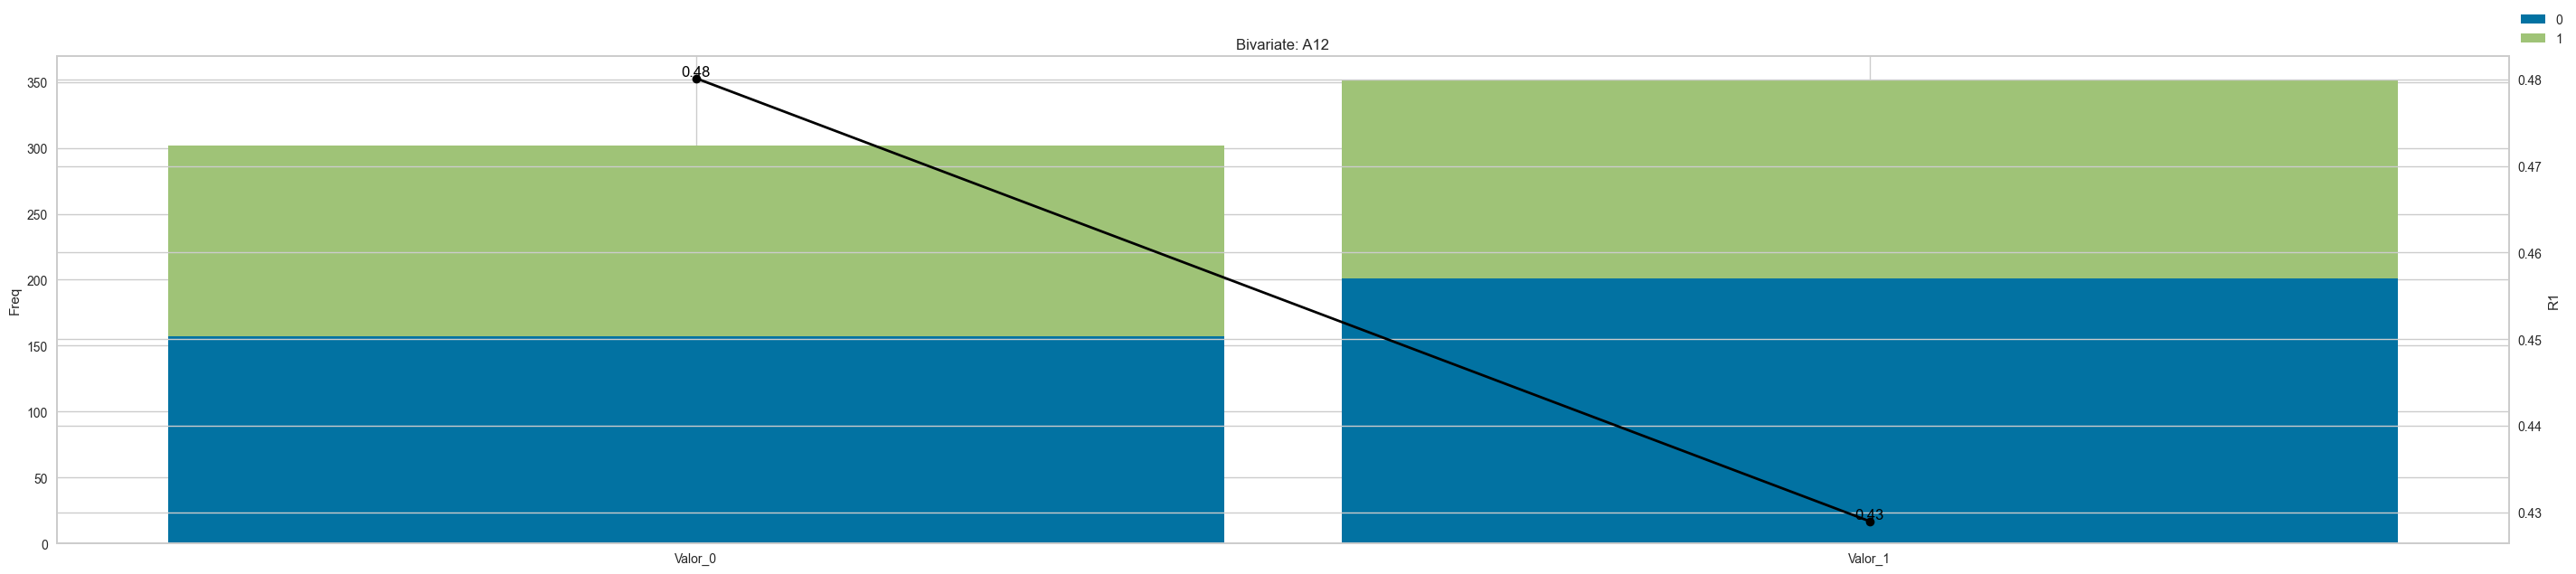

A14


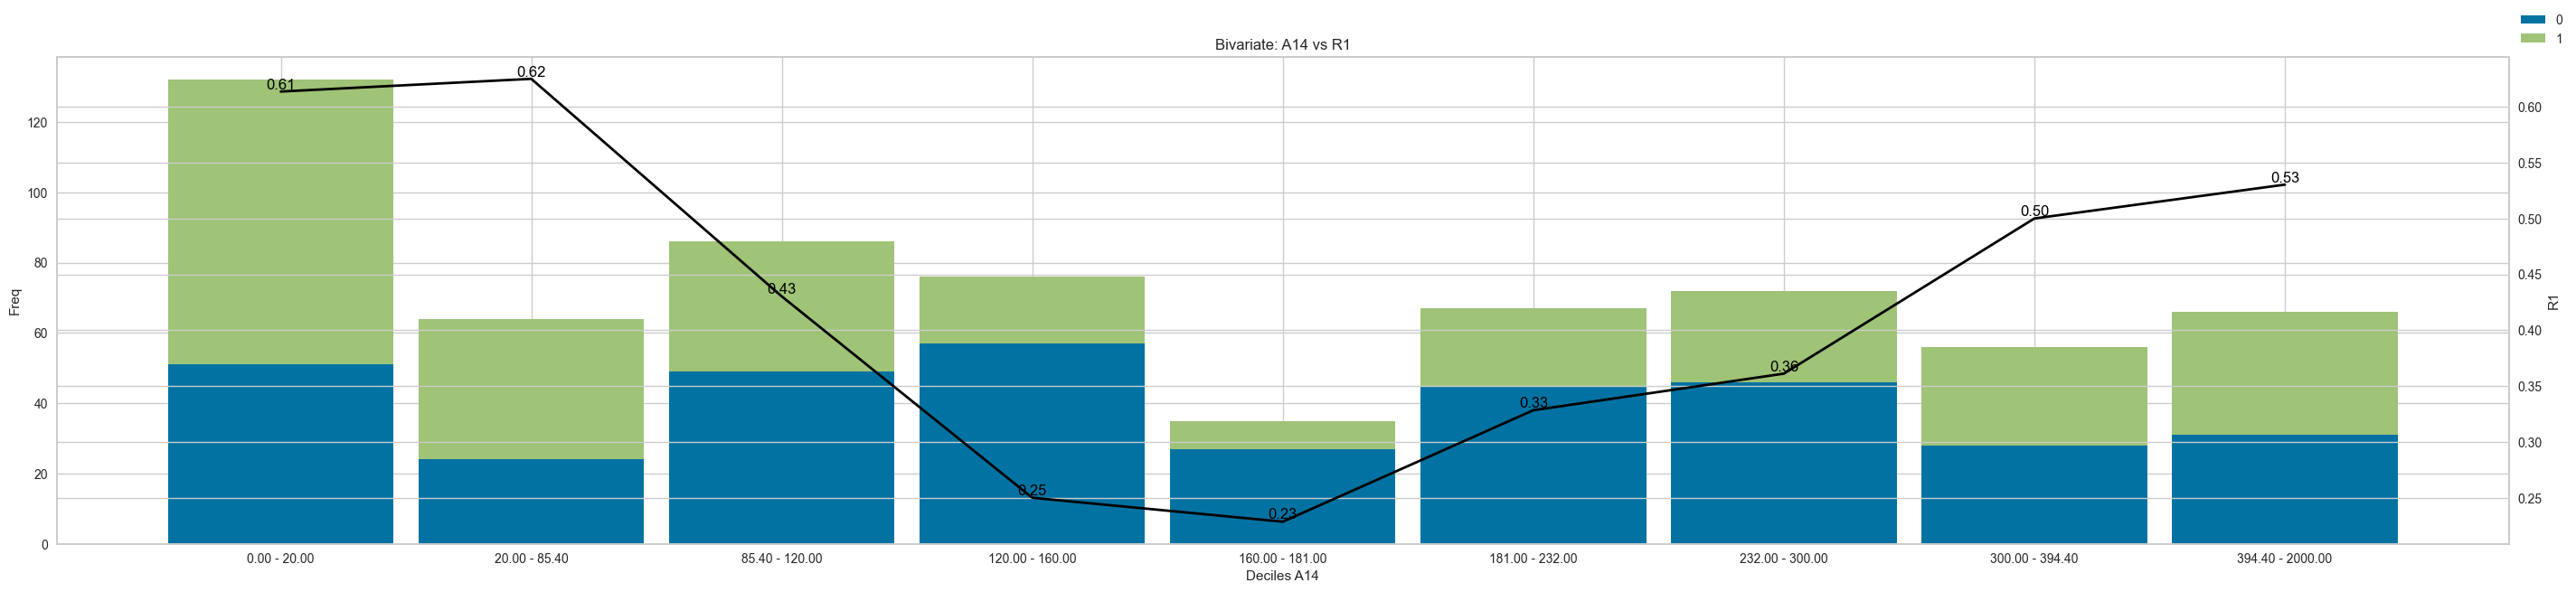

A15


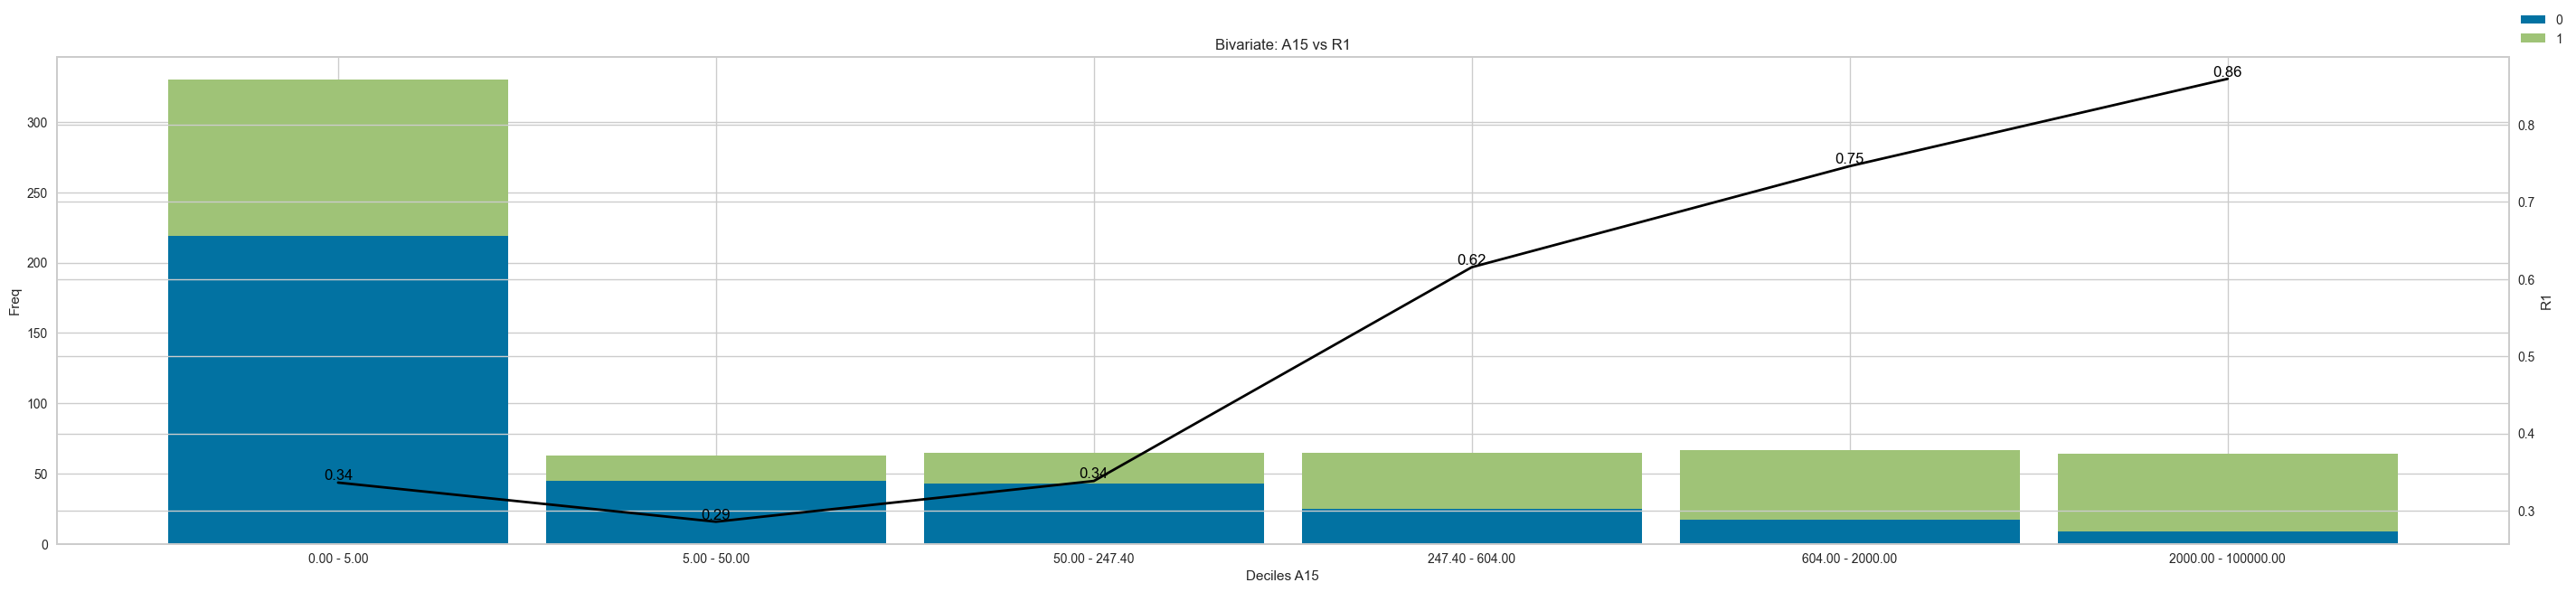

In [100]:
# Reporte para conocer la tasa de conversión con respecto al target
plot_graph_bivariable(df_analisis_bi, meta,'R1')

A partir de este reporte se desprende lo siguiente:
- Una mayor tasa de conversión para la solicitud de tarjeta de crédito en el valor_0 de la variable A1 a pesar de tener menor cantidad de valores
- Una mayor tasa de conversión para la solicitud de tarjeta de crédito en el valor_0 de la variable A10 a pesar de tener menor cantidad de valores
- Una mayor tasa de conversión para la solicitud de tarjeta de crédito en el valor_0 de la variable A12 a pesar de tener menor cantidad de valores
- Una mayor tasa de conversión para la solicitud de tarjeta de crédito en el valor_1 de la variable A9

### Análisis de regresión

Se calcula un gráfico de correlación entre todas las variables

In [101]:
df_corr = df_analisis.copy()

Convertimos las variables categóricas a valores numéricos

In [102]:
dicc_cambio_var_num = {'Valor_0': 0,
                       'Valor_1': 1}

df_corr['A1']=df_corr['A1'].map(dicc_cambio_var_num)
df_corr['A9']=df_corr['A9'].map(dicc_cambio_var_num)
df_corr['A10']=df_corr['A10'].map(dicc_cambio_var_num)
df_corr['A12']=df_corr['A12'].map(dicc_cambio_var_num)

In [103]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      654 non-null    int64  
 1   A2      654 non-null    float64
 2   A3      654 non-null    float64
 3   A8      654 non-null    float64
 4   A9      654 non-null    int64  
 5   A10     654 non-null    int64  
 6   A11     654 non-null    int64  
 7   A12     654 non-null    int64  
 8   A14     654 non-null    int64  
 9   A15     654 non-null    int64  
 10  R1      654 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 56.3 KB


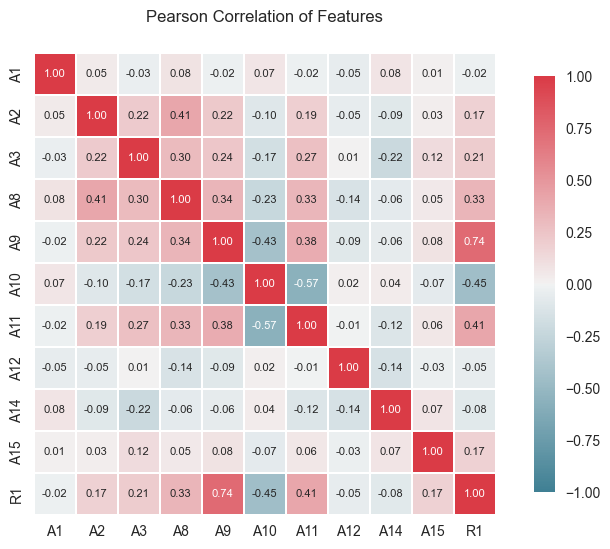

In [104]:
correlation_heatmap(df_corr)

In [105]:
df_corr.corr()

A1        A2        A3        A8        A9       A10       A11  \
A1   1.000000  0.045802 -0.034756  0.084334 -0.022270  0.066039 -0.017192   
A2   0.045802  1.000000  0.215737  0.409101  0.221511 -0.096747  0.192456   
A3  -0.034756  0.215737  1.000000  0.300434  0.236780 -0.165810  0.269675   
A8   0.084334  0.409101  0.300434  1.000000  0.335137 -0.228538  0.327587   
A9  -0.022270  0.221511  0.236780  0.335137  1.000000 -0.428780  0.377221   
A10  0.066039 -0.096747 -0.165810 -0.228538 -0.428780  1.000000 -0.569406   
A11 -0.017192  0.192456  0.269675  0.327587  0.377221 -0.569406  1.000000   
A12 -0.051311 -0.051588  0.006268 -0.139915 -0.088423  0.021452 -0.006467   
A14  0.076422 -0.090133 -0.217101 -0.063883 -0.058665  0.037486 -0.115151   
A15  0.012962  0.027909  0.119724  0.052247  0.084187 -0.068321  0.058494   
R1  -0.020732  0.172183  0.206766  0.333156  0.736572 -0.452540  0.406417   

          A12       A14       A15        R1  
A1  -0.051311  0.076422  0.012962 -0.020732  
A2  -0.051588 -0.090133  0.027909  0.172183  
A3   0.006268 -0.217101  0.119724  0.206766  
A8  -0.139915 -0.063883  0.052247  0.333156  
A9  -0.088423 -0.058665  0.084187  0.736572  
A10  0.021452  0.037486 -0.068321 -0.452540  
A11 -0.006467 -0.115151  0.058494  0.406417  
A12  1.000000 -0.141013 -0.027698 -0.051236  
A14 -0.141013  1.000000  0.073529 -0.083597  
A15 -0.027698  0.073529  1.000000  0.172833  
R1  -0.051236 -0.083597  0.172833  1.000000

Se desprende lo siguiente:

- Las variables A9, A10, A11 y A8 parecen tener las correlaciones más significativas con la solicitud de crédito (R1) y podrían ser importantes para el modelo predictivo. A3, A2 y A15 tienen correlaciones positivas más débiles pero aún podrían ser consideradas. Las demás variables parecen tener poca o ninguna correlación con el target.
- Las variables A10 y A11 están moderadamente correlacionadas de manera negativa (-0.57). Esto sugiere que cuando una de estas variables aumenta, la otra tiende a disminuir.
- Las variables A9 y A10 también tienen una moderada correlación negativa (-0.43), indicando una relación inversa.

# Preparación de los datos

In [106]:
df_prep= df_analisis.copy()

## Variables Binarias

Convertimos las variables categóricas a valores numéricos

In [107]:
dicc_cambio_var_num = {'Valor_0': 0,
                       'Valor_1': 1}

df_prep['A1']=df_prep['A1'].map(dicc_cambio_var_num)
df_prep['A9']=df_prep['A9'].map(dicc_cambio_var_num)
df_prep['A10']=df_prep['A10'].map(dicc_cambio_var_num)
df_prep['A12']=df_prep['A12'].map(dicc_cambio_var_num)

## Retirar los valores outliers mediante el análisis de percentiles

Dado el análisis exploratorio de los datos se determinan los siguiente cortes de imputación de datos.

In [108]:
#clean_outlier_perc(df_prep,'A8', 0.995)
#clean_outlier_perc(df_prep,'A11', 0.995)
clean_outlier_perc(df_prep,'A14', 0.995)
clean_outlier_perc(df_prep,'A15', 0.95)

In [109]:
vector_percentiles = [0,0.5,1,2.5,5,10,25,30,50,60,65,70,75,80,85,90,95,97.5,99,99.5,100]
vector_valores_percentiles=np.percentile(df_prep['A8'],vector_percentiles)

pd.concat([pd.DataFrame(vector_percentiles, columns = ['Percentile']),
           pd.DataFrame(vector_valores_percentiles, columns = ['Valor'])], axis = 1)

Percentile     Valor
0          0.0   0.00000
1          0.5   0.00000
2          1.0   0.00000
3          2.5   0.00000
4          5.0   0.00000
5         10.0   0.04000
6         25.0   0.16500
7         30.0   0.25000
8         50.0   1.00000
9         60.0   1.50000
10        65.0   1.75000
11        70.0   2.25000
12        75.0   2.61500
13        80.0   3.50000
14        85.0   4.63125
15        90.0   5.75000
16        95.0   8.63900
17        97.5  13.33750
18        99.0  15.23500
19        99.5  17.86750
20       100.0  28.50000

In [110]:
vector_percentiles = [0,0.5,1,2.5,5,10,25,30,50,60,65,70,75,80,85,90,95,97.5,99,99.5,100]
vector_valores_percentiles=np.percentile(df_prep['A11'],vector_percentiles)

pd.concat([pd.DataFrame(vector_percentiles, columns = ['Percentile']),
           pd.DataFrame(vector_valores_percentiles, columns = ['Valor'])], axis = 1)

Percentile  Valor
0          0.0    0.0
1          0.5    0.0
2          1.0    0.0
3          2.5    0.0
4          5.0    0.0
5         10.0    0.0
6         25.0    0.0
7         30.0    0.0
8         50.0    0.0
9         60.0    1.0
10        65.0    1.0
11        70.0    2.0
12        75.0    3.0
13        80.0    5.0
14        85.0    6.0
15        90.0    9.0
16        95.0   11.0
17        97.5   14.0
18        99.0   17.0
19        99.5   20.0
20       100.0   67.0

In [111]:
vector_percentiles = [0,0.5,1,2.5,5,10,25,30,50,60,65,70,75,80,85,90,95,97.5,99,99.5,100]
vector_valores_percentiles=np.percentile(df_prep['A14'],vector_percentiles)

pd.concat([pd.DataFrame(vector_percentiles, columns = ['Percentile']),
           pd.DataFrame(vector_valores_percentiles, columns = ['Valor'])], axis = 1)

Percentile    Valor
0          0.0    0.000
1          0.5    0.000
2          1.0    0.000
3          2.5    0.000
4          5.0    0.000
5         10.0    0.000
6         25.0   70.750
7         30.0   85.400
8         50.0  160.000
9         60.0  181.000
10        65.0  200.000
11        70.0  232.000
12        75.0  271.000
13        80.0  300.000
14        85.0  340.000
15        90.0  394.400
16        95.0  456.750
17        97.5  520.000
18        99.0  694.570
19        99.5  741.609
20       100.0  749.400

In [112]:
vector_percentiles = [0,0.5,1,2.5,5,10,25,30,50,60,65,70,75,80,85,90,95,97.5,99,99.5,100]
vector_valores_percentiles=np.percentile(df_prep['A15'],vector_percentiles)

pd.concat([pd.DataFrame(vector_percentiles, columns = ['Percentile']),
           pd.DataFrame(vector_valores_percentiles, columns = ['Valor'])], axis = 1)

Percentile    Valor
0          0.0     0.00
1          0.5     0.00
2          1.0     0.00
3          2.5     0.00
4          5.0     0.00
5         10.0     0.00
6         25.0     0.00
7         30.0     0.00
8         50.0     5.00
9         60.0    50.00
10        65.0   136.70
11        70.0   247.40
12        75.0   399.00
13        80.0   604.00
14        85.0  1000.00
15        90.0  2000.00
16        95.0  4081.78
17        97.5  4101.80
18        99.0  4101.80
19        99.5  4101.80
20       100.0  4101.80

## Diagrama de correlación

Se calcula un gráfico de correlación entre todas las variables

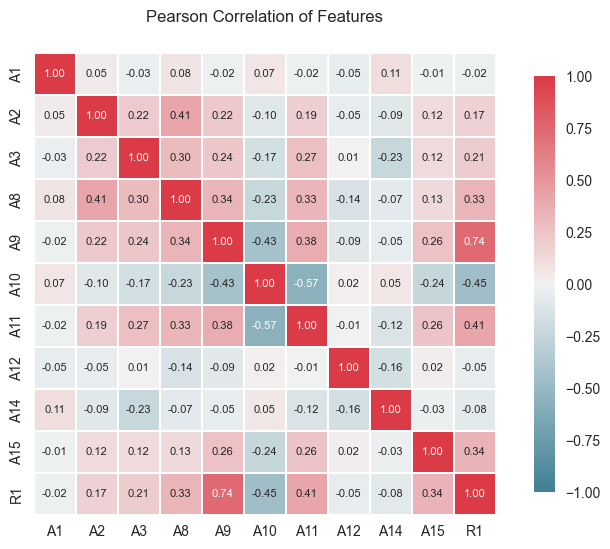

In [113]:
correlation_heatmap(df_prep)

- Las variables A9, A10 y A11 parecen tener las correlaciones más significativas con la solicitud de crédito (R1) y podrían ser importantes para el modelo predictivo. A8 y A15 tienen correlaciones positivas más débiles pero aún podrían ser consideradas. Las demás variables parecen tener poca o ninguna correlación con el target.
- Las variables A10 y A11 están moderadamente correlacionadas de manera negativa (-0.66). Esto sugiere que cuando una de estas variables aumenta, la otra tiende a disminuir.
- Las variables A9 y A10 también tienen una moderada correlación negativa (-0.43), indicando una relación inversa.
- El resto de variables mantiene una correlación débil.

Para fines del análisis se tomará en cuenta todas las variables.

# Modelado

Se realiza una copia del dataframe *df_prep*

In [114]:
df_prep.head(5)

A1     A2     A3    A8  A9  A10  A11  A12    A14    A15  R1
0   1  30.83  0.000  1.25   1    0    1    1  202.0    0.0   1
1   0  58.67  4.460  3.04   1    0    6    1   43.0  560.0   1
2   0  24.50  0.500  1.50   1    1    0    1  280.0  824.0   1
3   1  27.83  1.540  3.75   1    0    5    0  100.0    3.0   1
4   1  20.17  5.625  1.71   1    1    0    1  120.0    0.0   1

In [115]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      654 non-null    int64  
 1   A2      654 non-null    float64
 2   A3      654 non-null    float64
 3   A8      654 non-null    float64
 4   A9      654 non-null    int64  
 5   A10     654 non-null    int64  
 6   A11     654 non-null    int64  
 7   A12     654 non-null    int64  
 8   A14     654 non-null    float64
 9   A15     654 non-null    float64
 10  R1      654 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 56.3 KB


In [116]:
df_model = df_prep.copy()

In [117]:
df_model.shape

(654, 11)

Seleccionar las variables empleadas para el modelado

In [118]:
var_to_select=list(df_model.columns)
#var_to_select.remove('...')

In [119]:
df_model = df_model[var_to_select]

print("Número de filas y columnas:",df_model.shape)
df_model.head(5)

Número de filas y columnas: (654, 11)


A1     A2     A3    A8  A9  A10  A11  A12    A14    A15  R1
0   1  30.83  0.000  1.25   1    0    1    1  202.0    0.0   1
1   0  58.67  4.460  3.04   1    0    6    1   43.0  560.0   1
2   0  24.50  0.500  1.50   1    1    0    1  280.0  824.0   1
3   1  27.83  1.540  3.75   1    0    5    0  100.0    3.0   1
4   1  20.17  5.625  1.71   1    1    0    1  120.0    0.0   1

In [120]:
feat_categorical_model=['A1','A9','A10','A12']

feat_numerical_model=list(df_model.columns.values)
feat_numerical_model.remove('R1')
feat_numerical_model.remove('A1')
feat_numerical_model.remove('A9')
feat_numerical_model.remove('A10')
feat_numerical_model.remove('A12')

In [121]:
feat_numerical_model

['A2', 'A3', 'A8', 'A11', 'A14', 'A15']

In [122]:
feat_categorical_model

['A1', 'A9', 'A10', 'A12']

Se emplea la librería **pycaret** que nos permite automatizar el proceso de aprendizaje y evaluación de diferentes algoritmos de clasificación. Para realizar esta tarea se define un experimento y una serie de valores de hiperparametros.

## Setear el experimento

**Balanceo del Dataset**

Antes de ejecutar el experimento podemos observar que si bien se tiene una cantidad mayor de solicitudes rechazadas de tarjeta de crédito, esto no representa una problema de desbalance de clases.

In [123]:
print(df_prep['R1'].value_counts())
print(df_prep['R1'].value_counts(normalize=True))

R1
0    358
1    296
Name: count, dtype: int64
R1
0    0.547401
1    0.452599
Name: proportion, dtype: float64


**Normalización de los datos**


En PyCaret, cuando especificas normalize=True y no defines el método de normalización, el método por defecto utilizado es zscore. Esto significa que los datos serán escalados para tener una media de 0 y una desviación estándar de 1.

**Validación cruzada**

Se realiza validación cruzada empleando 5 folds con un train_size del 75%. Esto nos ayudará que validar que nuestro modelo no presente desajuste.

**Multicolinealidad**

Las variables correlacionadas serán retirados automaticamente empleado pycaret con el parámetro **remove_multicollinearity=True** siendo el valor del **threshold de 0.8**. Pudiendo modificarse este valor del parámetro, para nuestro caso no será necesario definir un corte.

**Definición de los parámetros del experimento**

Teniendo en cuenta estos criterio se definen los valores de los parámetros del experimento

In [124]:
from pycaret.classification import *

model_clf1 = setup(data=df_model,
                   target = 'R1',
                   session_id=123,
                   train_size=0.75,#0.7 #0.8
                   categorical_features=feat_categorical_model,
                   numeric_features=feat_numerical_model,
                   remove_multicollinearity=True,
                   multicollinearity_threshold=0.8,
                   fold=5,
                   fold_shuffle=True,
                   fold_strategy='stratifiedkfold',
                   feature_selection=True,
                   fix_imbalance=False,
                   normalize=True,
                   normalize_method='zscore'
                   )

## Comparar modelos

Una vez definido los valores de los parámetros del experimento se realiza el proceso de entrenamiento y evaluación empleando diferentes algoritmos de aprendizaje de máquina.

In [125]:
compare_models()

Según el desafio se debe entrenar uno o varios modelos (usando los algoritmos de preferencia) para clasificar si una solicitud debe ser rechazada o aceptada. En ese sentido se utilizó pycaret para probar diferentes algoritmos de aprendizaje automatico de clasificación.

Se toma en cuenta los siguientes algoritmos para un mejor entendimiento:

- El **accuracy** es alto para la mayoría de los modelos basados en árboles como **Xgboost**, **Catboost**, **Extra tree**, **Decision Tree** y **Random Forest**, sin embargo se debe de tener en cuenta que esta métrica no solo esta siendo afectado por los **TP** sino también por los **TN**. En este problema se pretende predecir si se rechaza o no una solicitud de crédito (**TP**).
- Para una partición del 70% en la data de entrenamiento:
    - El modelo **Xgboost** presenta altos valores de **Precisión** y **Accuracy**. Es un modelo robusto que equilibra bien la precisión y la exactitud.
    - El modelo **Catboost** presenta un mayor valor de **AUC** (0.7147) en comparación con otros modelos.Esto indica que una excelente capacidad para distinguir entre clases.
    - El modelo **Decision Tree** sobresale en Recall (0.6386), lo que indica que es muy efectivo en la identificación de rechazos (verdaderos positivos).

En conclusión:
La comparación de los modelos nos permite identificar cuál se debe elegir en función de las métricas que el negocio necesita optimizar:

- Para una alta **Precisión** y **Exactitud**, el modelo **XGBoost** es una excelente opción.
- Para maximizar la capacidad de discriminación entre clases, el modelo **CatBoost** es el más adecuado debido a su **alto valor de AUC**.
- Para priorizar la identificación de rechazos (minimizar los falsos negativos), el modelo **Decision Tree** con su alto valor de **Recall** puede ser preferible.

**Esta comparación nos permite conocer que algoritmo se debe elegir basado en las métricas que el negocio necesita optimizar**. 

### Decision Tree

#### Entrenamiento del modelo

In [126]:
dt_model = create_model('dt')

Podemos apreciar que las el promedio de cada métrica es cercano a los valores de cada Fold. Por otro lado presenta una desviación estandár aceptable que nos permite decir que el modelo no realiza overfitting.

#### Evaluación del modelo

Para este caso se emplea el 30% correspondiente al test de prueba.

$MATRIZ DE CONFUSIÓN$

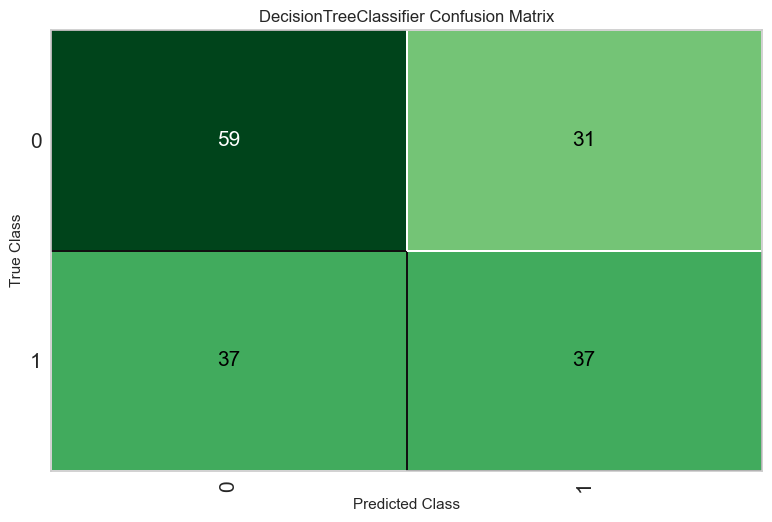

In [127]:
plot_model(dt_model, plot = 'confusion_matrix')

In [128]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc

# Obtener predicciones
predictions = predict_model(dt_model)

# Calcular la matriz de confusión
cm = confusion_matrix(predictions['R1'], predictions['prediction_label'])
tn, fp, fn, tp = cm.ravel()

# Calcular métricas
accuracy = accuracy_score(predictions['R1'], predictions['prediction_label'])
precision = precision_score(predictions['R1'], predictions['prediction_label'])
recall = recall_score(predictions['R1'], predictions['prediction_label'])
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')


Accuracy: 0.59
Precision: 0.54
Recall: 0.50
Specificity: 0.66


$ROC-AUC$

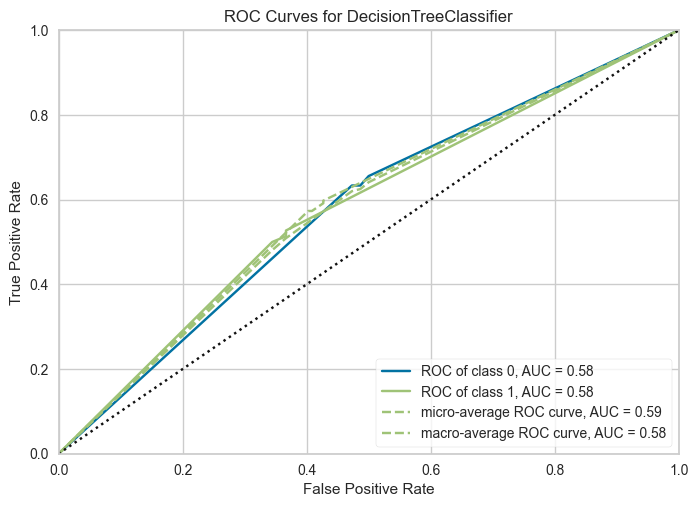

In [129]:
plot_model(dt_model, plot = 'auc')

### Extreme Gradient Boosting

#### Entrenamiento del modelo

In [130]:
xgboost_model = create_model('xgboost')

Podemos apreciar que las el promedio de cada métrica es cercano a los valores de cada Fold. Por otro lado presenta una desviación estandár aceptable que nos permite decir que el modelo no realiza overfitting.

#### Evaluación del modelo

Para este caso se emplea el 30% correspondiente al test de prueba.

$MATRIZ DE CONFUSIÓN$

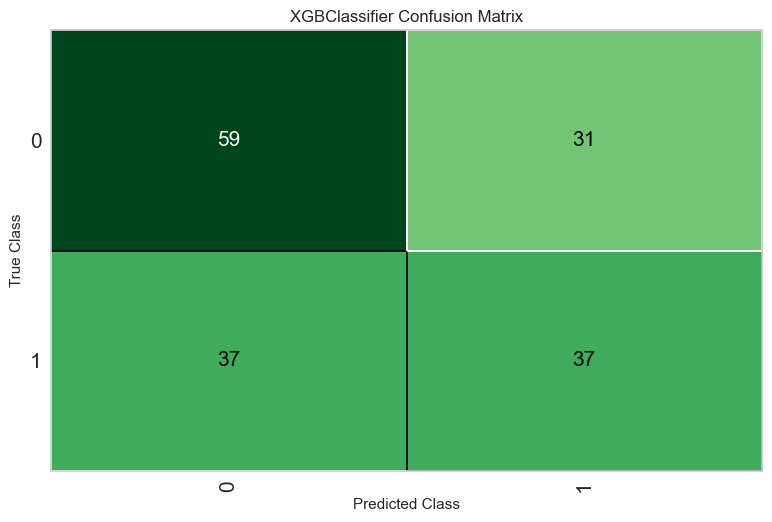

In [131]:
plot_model(xgboost_model, plot = 'confusion_matrix')

In [132]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc

predictions = predict_model(xgboost_model)

cm = confusion_matrix(predictions['R1'], predictions['prediction_label'])
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(predictions['R1'], predictions['prediction_label'])
precision = precision_score(predictions['R1'], predictions['prediction_label'])
recall = recall_score(predictions['R1'], predictions['prediction_label'])
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')


Accuracy: 0.59
Precision: 0.54
Recall: 0.50
Specificity: 0.66


$ROC-AUC$

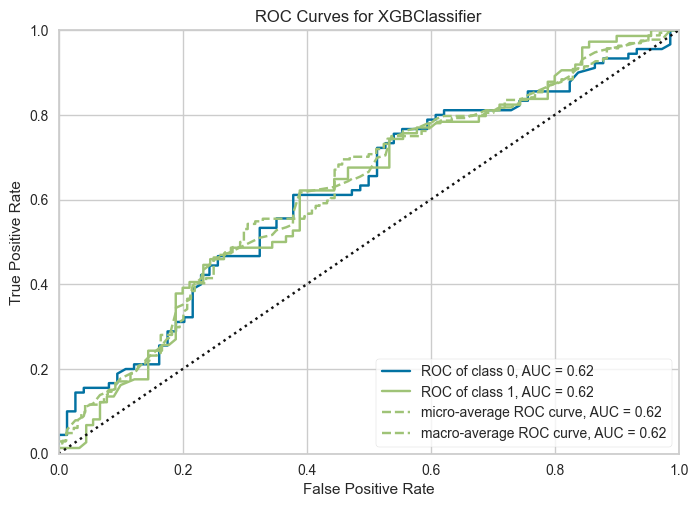

In [133]:
plot_model(xgboost_model, plot = 'auc')

### Extra Trees Classifier

#### Entrenamiento del modelo

In [134]:
et_model = create_model('et')

Podemos apreciar que las el promedio de cada métrica es cercano a los valores de cada Fold. Por otro lado presenta una desviación estandár aceptable que nos permite decir que el modelo no realiza overfitting.

#### Evaluación del modelo

Para este caso se emplea el 30% correspondiente al test de prueba.

$MATRIZ DE CONFUSIÓN$

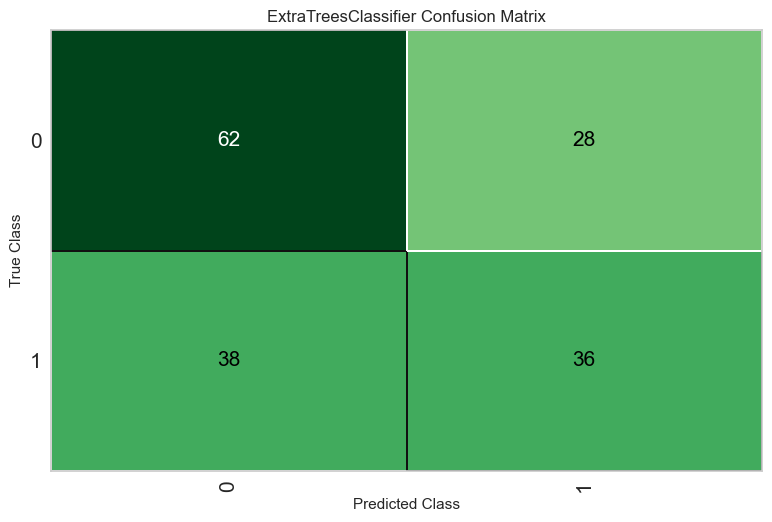

In [135]:
plot_model(et_model, plot = 'confusion_matrix')

In [136]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc

# Obtener predicciones
predictions = predict_model(et_model)

# Calcular la matriz de confusión
cm = confusion_matrix(predictions['R1'], predictions['prediction_label'])
tn, fp, fn, tp = cm.ravel()

# Calcular métricas
accuracy = accuracy_score(predictions['R1'], predictions['prediction_label'])
precision = precision_score(predictions['R1'], predictions['prediction_label'])
recall = recall_score(predictions['R1'], predictions['prediction_label'])
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')


Accuracy: 0.60
Precision: 0.56
Recall: 0.49
Specificity: 0.69


$ROC-AUC$

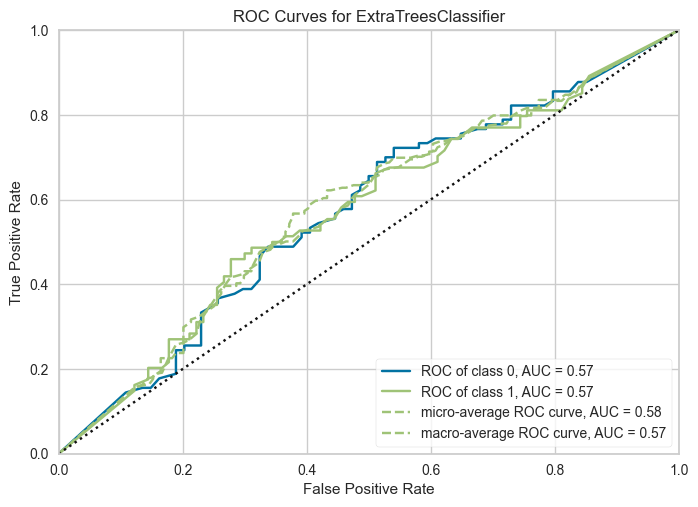

In [137]:
plot_model(et_model, plot = 'auc')

### Random Forest Classifier

#### Entrenamiento del modelo

In [138]:
rf_model = create_model('rf')

Podemos apreciar que las el promedio de cada métrica es cercano a los valores de cada Fold. Por otro lado presenta una desviación estandár aceptable que nos permite decir que el modelo no realiza overfitting.

#### Evaluación del modelo

Para este caso se emplea el 30% correspondiente al test de prueba.

$MATRIZ DE CONFUSIÓN$

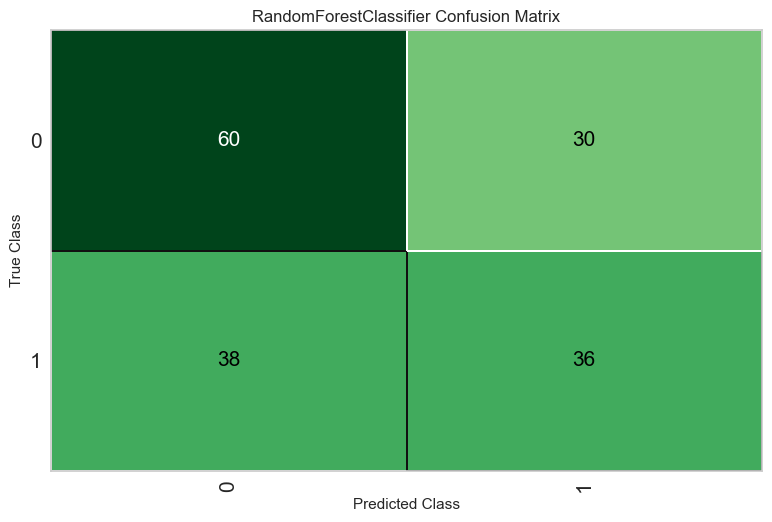

In [139]:
plot_model(rf_model, plot = 'confusion_matrix')

In [140]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc

# Obtener predicciones
predictions = predict_model(rf_model)

# Calcular la matriz de confusión
cm = confusion_matrix(predictions['R1'], predictions['prediction_label'])
tn, fp, fn, tp = cm.ravel()

# Calcular métricas
accuracy = accuracy_score(predictions['R1'], predictions['prediction_label'])
precision = precision_score(predictions['R1'], predictions['prediction_label'])
recall = recall_score(predictions['R1'], predictions['prediction_label'])
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')


Accuracy: 0.59
Precision: 0.55
Recall: 0.49
Specificity: 0.67


$ROC-AUC$

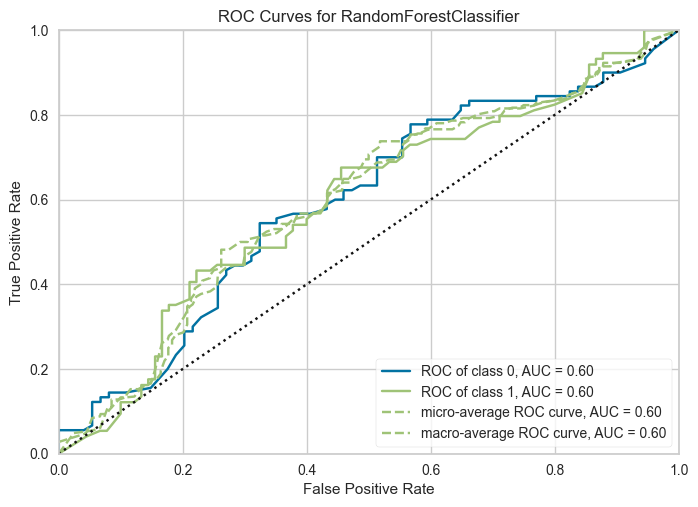

In [141]:
plot_model(rf_model, plot = 'auc')

### CatBoost Classifier

#### Entrenamiento del modelo

In [142]:
catboost_model = create_model('catboost')

Podemos apreciar que las el promedio de cada métrica es cercano a los valores de cada Fold. Por otro lado presenta una desviación estandár aceptable que nos permite decir que el modelo no realiza overfitting.

#### Evaluación del modelo

Para este caso se emplea el 30% correspondiente al test de prueba.

$MATRIZ DE CONFUSIÓN$

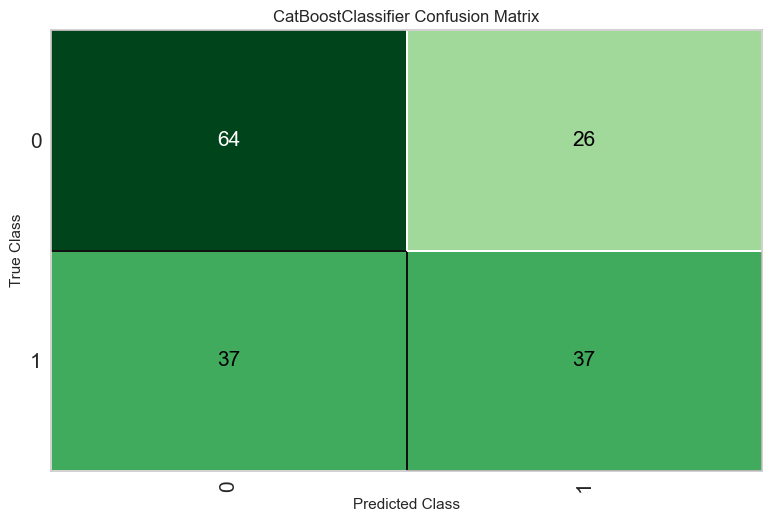

In [143]:
plot_model(catboost_model, plot = 'confusion_matrix')

In [144]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc

# Obtener predicciones
predictions = predict_model(catboost_model)

# Calcular la matriz de confusión
cm = confusion_matrix(predictions['R1'], predictions['prediction_label'])
tn, fp, fn, tp = cm.ravel()

# Calcular métricas
accuracy = accuracy_score(predictions['R1'], predictions['prediction_label'])
precision = precision_score(predictions['R1'], predictions['prediction_label'])
recall = recall_score(predictions['R1'], predictions['prediction_label'])
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')


Accuracy: 0.62
Precision: 0.59
Recall: 0.50
Specificity: 0.71


$ROC-AUC$

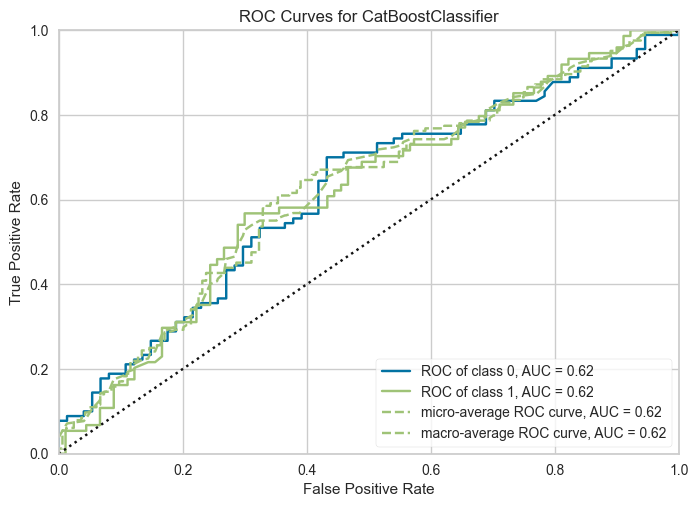

In [145]:
plot_model(catboost_model, plot = 'auc')

### Ligth Gradient Boosting Machine

#### Entrenamiento del modelo

In [146]:
lightgbm_model = create_model('lightgbm')

Podemos apreciar que las el promedio de cada métrica es cercano a los valores de cada Fold. Por otro lado presenta una desviación estandár aceptable que nos permite decir que el modelo no realiza overfitting.

#### Evaluación del modelo

Para este caso se emplea el 30% correspondiente al test de prueba.

$MATRIZ DE CONFUSIÓN$

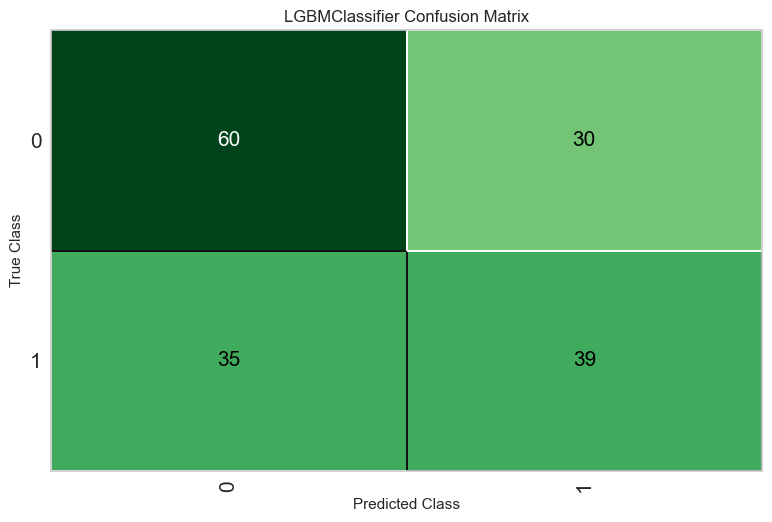

In [147]:
plot_model(lightgbm_model, plot = 'confusion_matrix')

In [148]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc

# Obtener predicciones
predictions = predict_model(lightgbm_model)

# Calcular la matriz de confusión
cm = confusion_matrix(predictions['R1'], predictions['prediction_label'])
tn, fp, fn, tp = cm.ravel()

# Calcular métricas
accuracy = accuracy_score(predictions['R1'], predictions['prediction_label'])
precision = precision_score(predictions['R1'], predictions['prediction_label'])
recall = recall_score(predictions['R1'], predictions['prediction_label'])
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')


Accuracy: 0.60
Precision: 0.57
Recall: 0.53
Specificity: 0.67


$ROC-AUC$

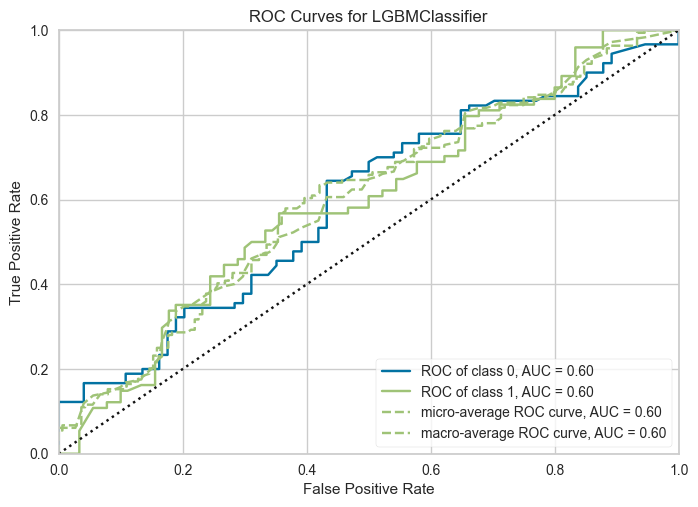

In [149]:
plot_model(lightgbm_model, plot = 'auc')

### Gradient Boosting Classifier

#### Entrenamiento del modelo

In [150]:
gbc_model = create_model('gbc')

Podemos apreciar que las el promedio de cada métrica es cercano a los valores de cada Fold. Por otro lado presenta una desviación estandár aceptable que nos permite decir que el modelo no realiza overfitting.

#### Evaluación del modelo

Para este caso se emplea el 30% correspondiente al test de prueba.

$MATRIZ DE CONFUSIÓN$

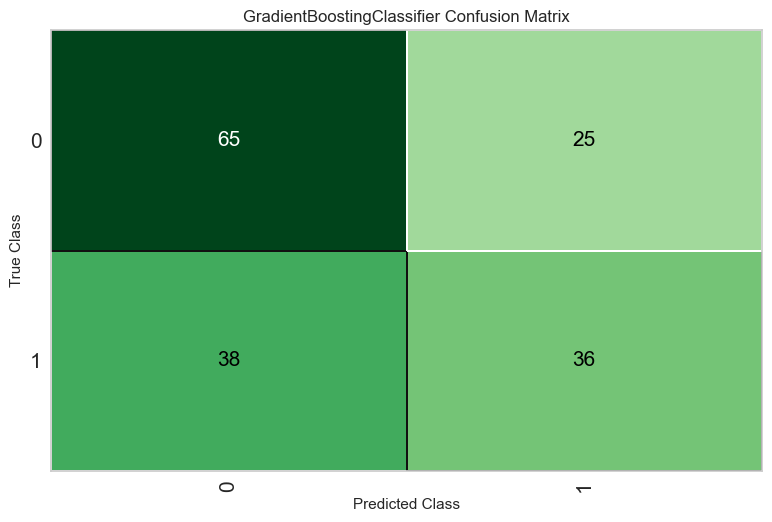

In [151]:
plot_model(gbc_model, plot = 'confusion_matrix')

In [152]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc

# Obtener predicciones
predictions = predict_model(gbc_model)

# Calcular la matriz de confusión
cm = confusion_matrix(predictions['R1'], predictions['prediction_label'])
tn, fp, fn, tp = cm.ravel()

# Calcular métricas
accuracy = accuracy_score(predictions['R1'], predictions['prediction_label'])
precision = precision_score(predictions['R1'], predictions['prediction_label'])
recall = recall_score(predictions['R1'], predictions['prediction_label'])
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')


Accuracy: 0.62
Precision: 0.59
Recall: 0.49
Specificity: 0.72


$ROC-AUC$

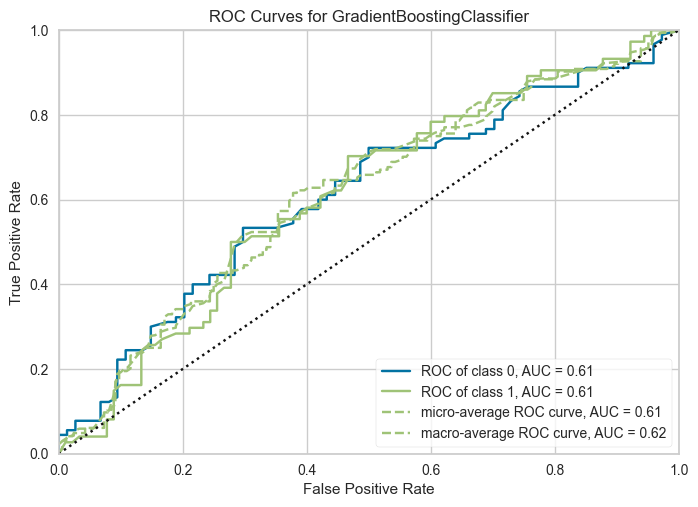

In [153]:
plot_model(gbc_model, plot = 'auc')

### Ada Boost Classifier

#### Entrenamiento del modelo

In [154]:
ada_model = create_model('ada')

Podemos apreciar que las el promedio de cada métrica es cercano a los valores de cada Fold. Por otro lado presenta una desviación estandár aceptable que nos permite decir que el modelo no realiza overfitting.

#### Evaluación del modelo

Para este caso se emplea el 30% correspondiente al test de prueba.

$MATRIZ DE CONFUSIÓN$

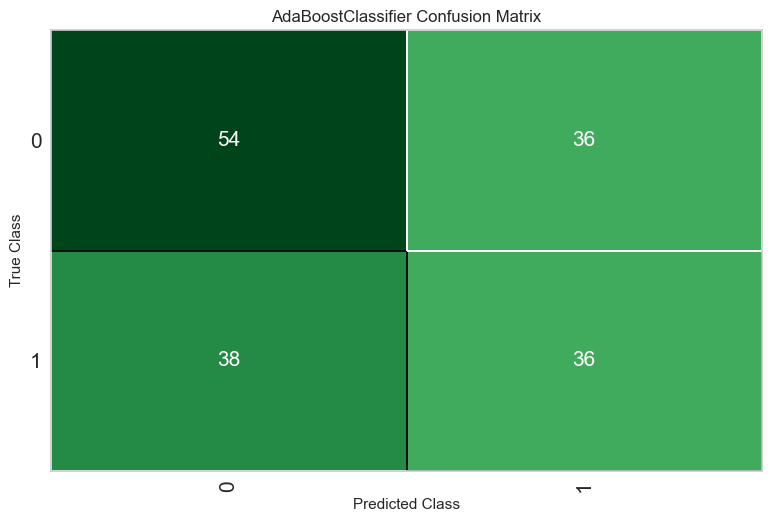

In [155]:
plot_model(ada_model, plot = 'confusion_matrix')

In [156]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc

# Obtener predicciones
predictions = predict_model(ada_model)

# Calcular la matriz de confusión
cm = confusion_matrix(predictions['R1'], predictions['prediction_label'])
tn, fp, fn, tp = cm.ravel()

# Calcular métricas
accuracy = accuracy_score(predictions['R1'], predictions['prediction_label'])
precision = precision_score(predictions['R1'], predictions['prediction_label'])
recall = recall_score(predictions['R1'], predictions['prediction_label'])
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')


Accuracy: 0.55
Precision: 0.50
Recall: 0.49
Specificity: 0.60


$ROC-AUC$

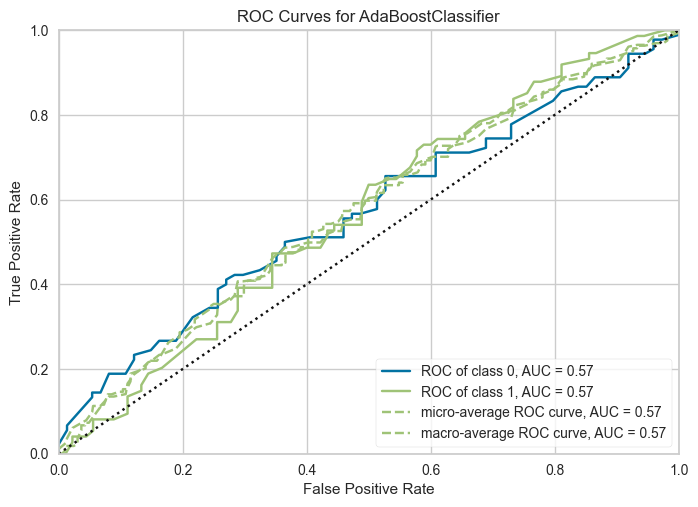

In [157]:
plot_model(ada_model, plot = 'auc')

### Logistic Regression

#### Entrenamiento del modelo

In [158]:
lr_model = create_model('lr')

Podemos apreciar que las el promedio de cada métrica es cercano a los valores de cada Fold. Por otro lado presenta una desviación estandár aceptable que nos permite decir que el modelo no realiza overfitting.

#### Evaluación del modelo

Para este caso se emplea el 30% correspondiente al test de prueba.

$MATRIZ DE CONFUSIÓN$

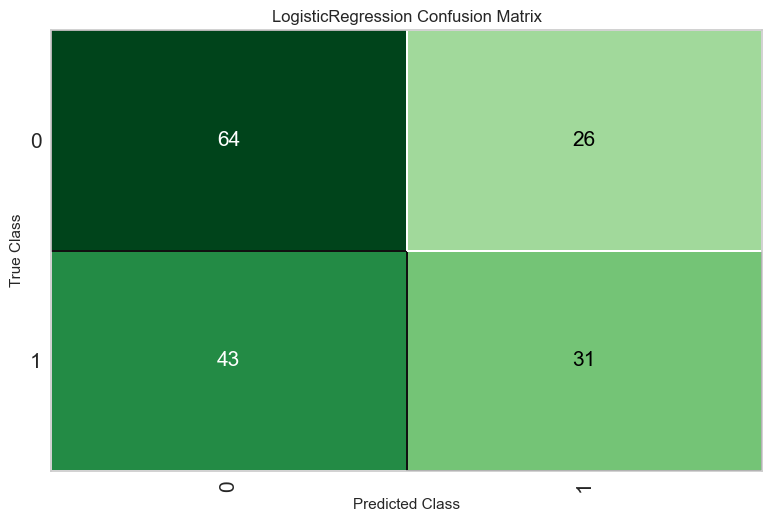

In [159]:
plot_model(lr_model, plot = 'confusion_matrix')

In [160]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc

# Obtener predicciones
predictions = predict_model(lr_model)

# Calcular la matriz de confusión
cm = confusion_matrix(predictions['R1'], predictions['prediction_label'])
tn, fp, fn, tp = cm.ravel()

# Calcular métricas
accuracy = accuracy_score(predictions['R1'], predictions['prediction_label'])
precision = precision_score(predictions['R1'], predictions['prediction_label'])
recall = recall_score(predictions['R1'], predictions['prediction_label'])
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')


Accuracy: 0.58
Precision: 0.54
Recall: 0.42
Specificity: 0.71


$ROC-AUC$

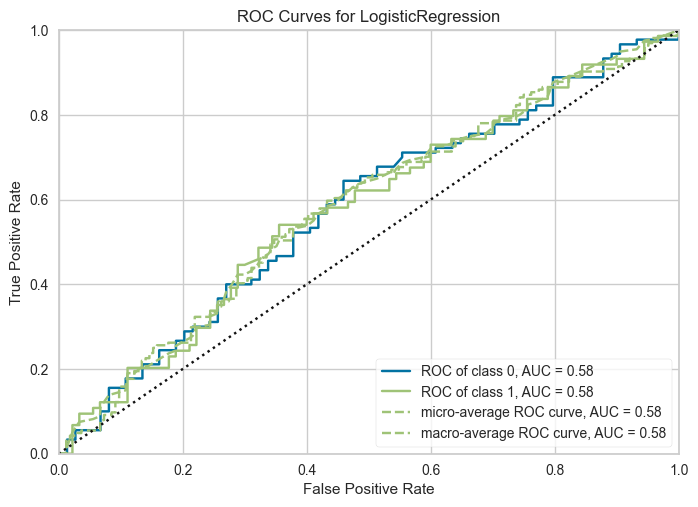

In [161]:
plot_model(lr_model, plot = 'auc')

## Elegir el modelo final

Para elegir el modelo que será empleado para para clasificar si una solicitud debe ser rechazada o aceptada se toma en cuenta algunos puntos relacionados con la interpretación del error y su impacto en el negocio. Para ellos empleamos la matriz de confusión:

<center><img src="imagenes/confusion_matrix.png"></center>

**Impacto de los Falsos Positivos (FP) y los Falsos Negativos (FN)**

CASO 1 orientado en los Falsos Positivos (FP):
Son los casos en los que el modelo predice que una solicitud debe ser aceptada, pero en realidad debería ser rechazada. Presenta los siguientes impactos:
- Riesgo Financiero: Otorgar crédito a un solicitante que debería haber sido rechazado puede resultar en pérdidas financieras significativas para la institución financiera, especialmente si el solicitante no cumple con sus obligaciones de pago.
- Costos Operativos: Incremento en los costos de seguimiento y cobranza, así como en la provisión para incobrables.

CASO 2 orientado en los Falsos Negativos (FN):
Son los casos en los que el modelo predice que una solicitud debe ser rechazada, pero en realidad debería ser aceptada. Presenta los siguientes impactos:
- Pérdida de Oportunidades: Rechazar a un solicitante que debería haber sido aceptado puede resultar en la pérdida de un cliente potencialmente valioso y rentable.
- Reputación: Rechazos injustificados pueden dañar la reputación de la institución financiera y afectar la percepción del cliente sobre la marca.

**Considero que el CASO 1 tendría más impacto para el negocio**, es decir clasificar una solicitud como **APROBADO** pero que debió clasificarse como **RECHAZADO**

La exactitud en general del modelo mejora cuando se reducen tanto los falsos positivos como los falsos negativos, pero en este contexto, **el costo asociado con falsos positivos (riesgo financiero) es mayor que el costo asociado con falsos negativos (pérdida de oportunidad).**

¿Qué se hará?

Métrica a Optimizar: **Especificidad**

Dado que los **falsos positivos (FP)** representan el mayor riesgo financiero (otorgar crédito a quienes no deberían recibirlo), aumentar la **especificidad** ayuda a reducir estos errores.

La **especificidad** se centra en la precisión de los rechazos (**TN**), lo que es crucial para mantener la salud financiera de la institución.

¿Por qué no la métrica de **Precisión**?

Aunque la precisión también tiene en cuenta los falsos positivos, no se enfoca exclusivamente en la capacidad del modelo para identificar correctamente los rechazos. Es más útil cuando el objetivo es asegurar que las aceptaciones sean correctas.

En la comparación de modelos como tenemos dos modelos que presentan los siguientes indicadores:

**CatBoost Classifier**
- Accuracy: 0.615
- Precision: 0.587
- Recall: 0.50
- Specificity: 0.71
- AUC: 0.617

**Gradient Boosting Classifier**
- Accuracy: 0.611
- Precision: 0.59
- Recall: 0.486
- Specificity: 0.72
- AUC: 0.611

Si bien **Gradient Boosting Classifier** presenta un mayor valor de especificidad, tomaremos **CatBoost Classifier** ya que no solo presenta buenos indicadores con la data de entrenamiento sino también con la data del test.


### CatBoost Classifier

Busquemos probar un corte diferente en la probabilidad a fin de reducir los FP y optimizar la especifidad.

#### Ajuste de Umbral

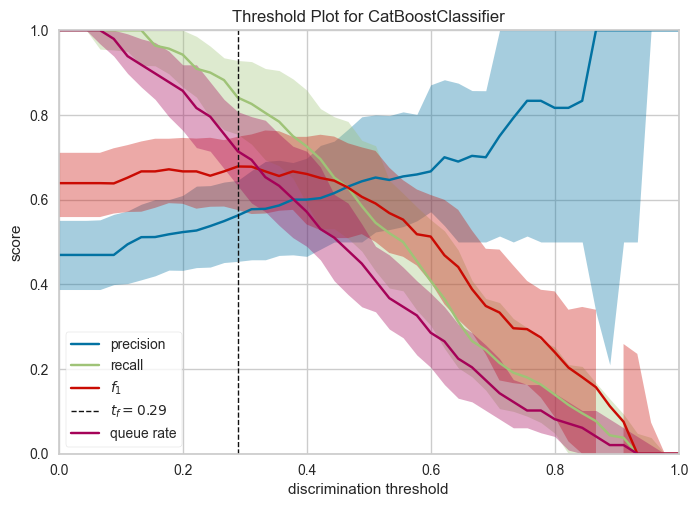

In [162]:
plot_model(catboost_model, plot = 'threshold')

A partir de este caso se crean otro modelo tomando un **probability_threshold** de valor **0.45**. Nos quedaremos con el que brinde un mejor valor de **especificidad**.

In [163]:
catboost_model_threshold = create_model('catboost',probability_threshold=0.45)

#### Evaluación del modelo con corte de probabilidad 0.5

Para este caso se emplea el 25% correspondiente al test de prueba.

$MATRIZ DE CONFUSIÓN$

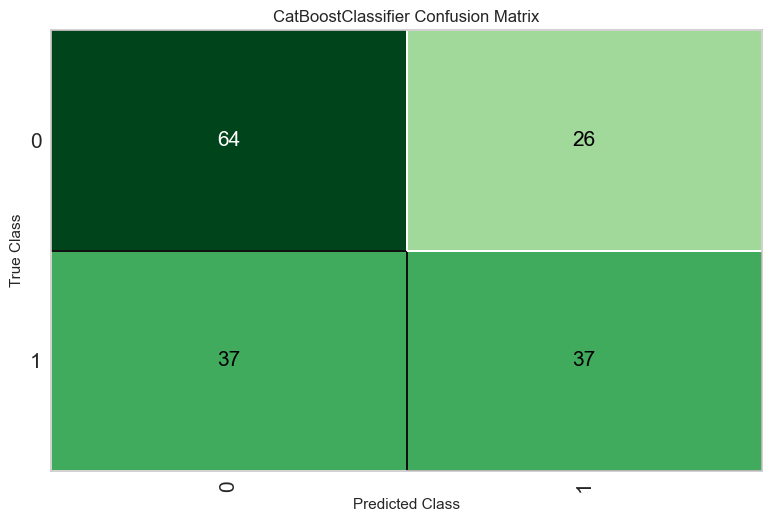

In [164]:
plot_model(catboost_model, plot = 'confusion_matrix')

In [165]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc

predictions = predict_model(catboost_model)

cm = confusion_matrix(predictions['R1'], predictions['prediction_label'])
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(predictions['R1'], predictions['prediction_label'])
precision = precision_score(predictions['R1'], predictions['prediction_label'])
recall = recall_score(predictions['R1'], predictions['prediction_label'])
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')

Accuracy: 0.62
Precision: 0.59
Recall: 0.50
Specificity: 0.71


$ROC-AUC$

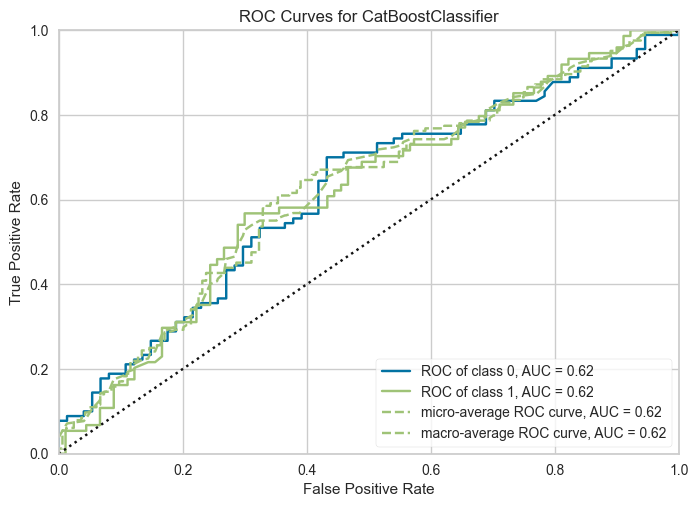

In [166]:
plot_model(catboost_model, plot = 'auc')

#### Evaluación del modelo con corte de probabilidad 0.45

Para este caso se emplea el 25% correspondiente al test de prueba.

$MATRIZ DE CONFUSIÓN$

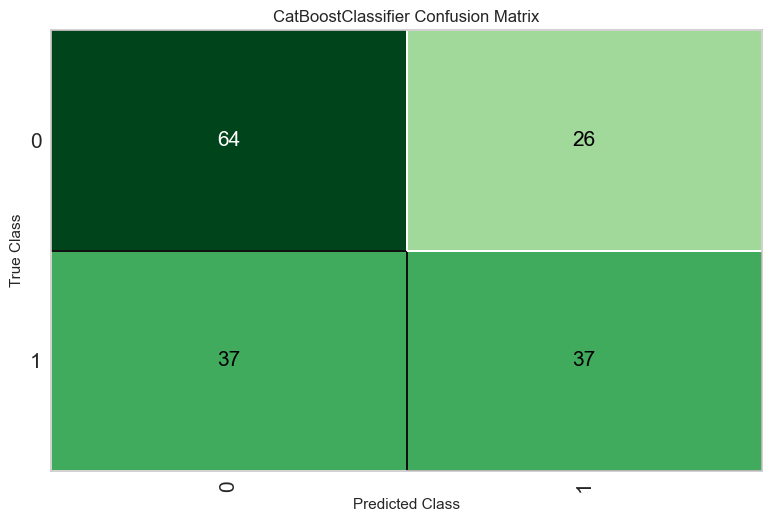

In [167]:
plot_model(catboost_model_threshold, plot = 'confusion_matrix')

In [168]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc

predictions = predict_model(catboost_model_threshold)

cm = confusion_matrix(predictions['R1'], predictions['prediction_label'])
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(predictions['R1'], predictions['prediction_label'])
precision = precision_score(predictions['R1'], predictions['prediction_label'])
recall = recall_score(predictions['R1'], predictions['prediction_label'])
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')

Accuracy: 0.62
Precision: 0.58
Recall: 0.57
Specificity: 0.66


$ROC-AUC$

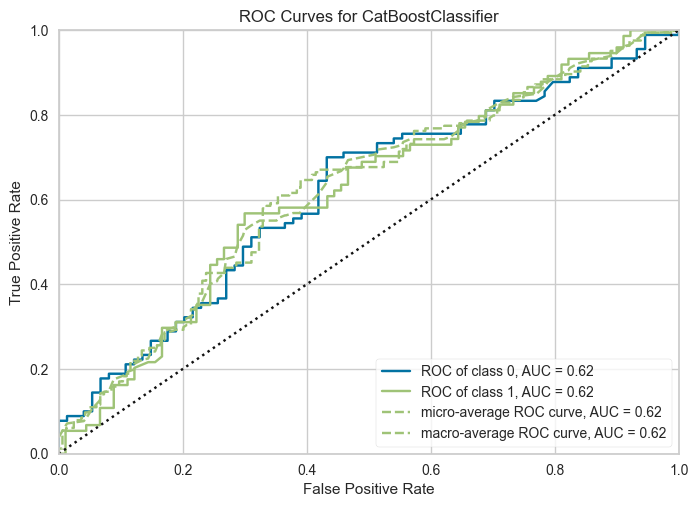

In [169]:
plot_model(catboost_model_threshold, plot = 'auc')

#### Modelo elegido

Como se aprecia no se tiene una mejora en torno a la especificidad. Por el contrario el valor cayó, así como el resto de métricas asociadas. En ese sentido nos quedaremos con el primer modelo de **CatBoost Classifier** que presenta un corte de probabilidad en 0.5

In [170]:
catboost_model = create_model('catboost')

Presenta la siguiente matriz de confusión:

In [171]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc

predictions = predict_model(catboost_model)

cm = confusion_matrix(predictions['R1'], predictions['prediction_label'])
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(predictions['R1'], predictions['prediction_label'])
precision = precision_score(predictions['R1'], predictions['prediction_label'])
recall = recall_score(predictions['R1'], predictions['prediction_label'])
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')

Accuracy: 0.62
Precision: 0.59
Recall: 0.50
Specificity: 0.71


Interpretación de cada métrica:

- Exactitud (Accuracy): La exactitud general del modelo es 61.59%, lo cual da una idea general del rendimiento pero puede ser engañoso en conjuntos de datos desbalanceados.

- Precisión: Indica que el 58.73% de las solicitudes predichas como aceptadas son realmente aceptadas. Es importante pero no el enfoque principal si queremos minimizar los falsos positivos.

- Sensibilidad (Recall): Muestra que el 50% de las solicitudes aceptadas fueron correctamente identificadas. Es crucial para no perder muchos casos positivos verdaderos, pero no es nuestro enfoque principal aquí.

- Especificidad: Indica que el 71.11% de las solicitudes rechazadas fueron correctamente identificadas. Dado que queremos minimizar los falsos positivos (otorgar crédito a quienes no deberían recibirlo), esta es la métrica clave.

Presenta el siguiente diagrama ROC-AUC:

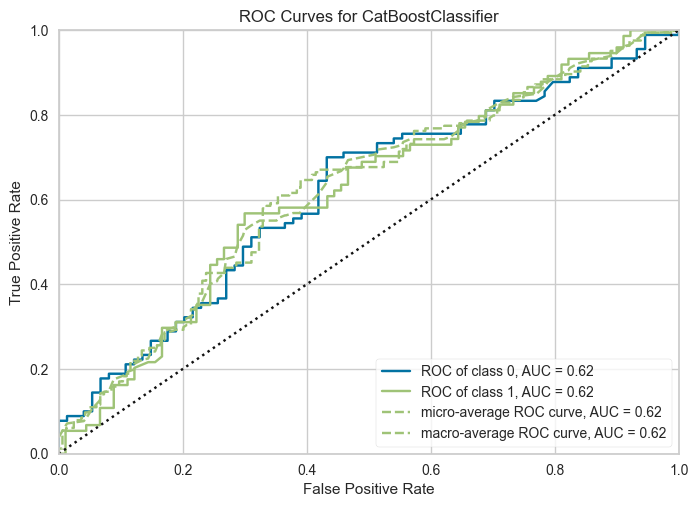

In [172]:
plot_model(catboost_model, plot = 'auc')

Se desprende de la gráfica:

La curva ROC y el área bajo la curva ROC (AUC) son herramientas visuales y métricas utilizadas para evaluar el rendimiento de un modelo de clasificación. Vamos a interpretar la figura proporcionada.

- Interpretación: El AUC de 0.62 indica que el modelo tiene un rendimiento moderado. Esto significa que hay un 62% de probabilidad de que el modelo clasifique correctamente una instancia positiva como más probable que una instancia negativa.
- Consideración: Un AUC de 0.62 sugiere que el modelo es mejor que un clasificador aleatorio, pero aún hay mucho espacio para mejorar.


Por último tomar en cuenta lo siguiente:

- Sensibilidad y Especificidad: La curva ROC permite evaluar cómo el modelo equilibra la sensibilidad y la especificidad a diferentes umbrales. Un mejor modelo se caracterizaría por una curva ROC que se curva más hacia la esquina superior izquierda.
- Área Bajo la Curva (AUC): El AUC proporciona un resumen del rendimiento del modelo en todas las posibles configuraciones de umbral. Un AUC de 0.62 indica que hay un potencial significativo para mejorar el modelo.


Por último veamos el diagrama de división

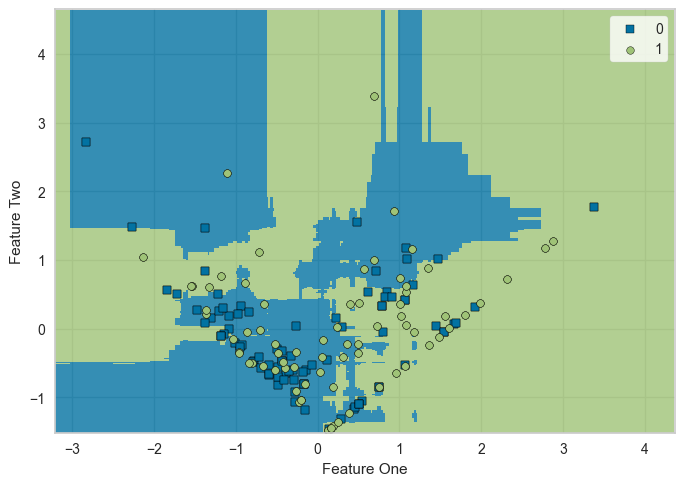

In [173]:
plot_model(catboost_model, plot = 'boundary')

# Interpretabilidad del modelo

Al parecer tenemos problemas para ejecutar la importancia de variables con Pycaret. Para tener una representatividad, se crea un modelo CatBoost mediante scikit-learn empleando la misma configuración realizada en PyCaret. Si bien pueden haber diferencias, la idea es tener en cuenta cuales son las variables que impactan en el modelo.

In [174]:
# Obtener los parámetros específicos del modelo CatBoost
import pprint

catboost_model_params = catboost_model.get_all_params()
print("Parámetros del Modelo CatBoost:")
pprint.pprint(catboost_model_params)

Parámetros del Modelo CatBoost:
{'auto_class_weights': 'None',
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': False,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'class_names': [0, 1],
 'classes_count': 0,
 'depth': 6,
 'eval_fraction': 0,
 'eval_metric': 'Logloss',
 'feature_border_type': 'GreedyLogSum',
 'force_unit_auto_pair_weights': False,
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 10,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.0075969998724758625,
 'loss_function': 'Logloss',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_score_type': 'NormalWithModelSizeDecrease',
 'random_

In [175]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

X = df_model.drop(columns=['R1'])
y = df_model['R1']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=123, stratify=y)

cat_features = [X.columns.get_loc(c) for c in feat_categorical_model]


In [176]:
# Crear y entrenar el modelo CatBoost
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.0075969998724758625,
    depth=6,
    loss_function='Logloss',
    random_seed=123,
    subsample=0.8,
    eval_metric='Logloss',
    bootstrap_type='MVS',
    leaf_estimation_iterations=10,
    cat_features=cat_features,
    logging_level='Silent'
)

# Entrenar el modelo
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

## Empleando el criterio de importancia de cada variable por indice de pureza de gini

In [177]:
#plot_model(catboost_model, plot = 'feature_all')

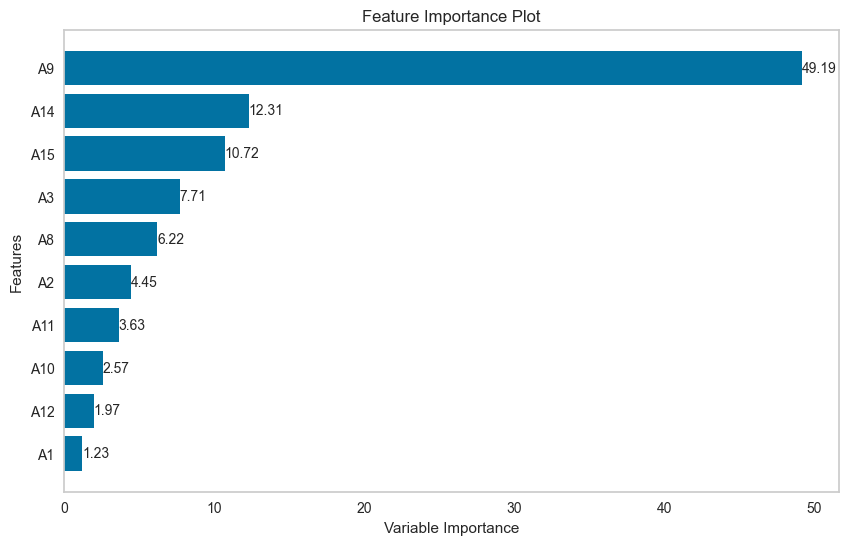

In [178]:
# Importancia de las características
feature_importances = catboost_model.get_feature_importance()
feature_names = X.columns

import pandas as pd
import matplotlib.pyplot as plt

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Variable Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')

for bar in bars:
    plt.text(
        bar.get_width(), 
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.2f}', 
        va='center', 
        ha='left',fontsize=10 
    )

plt.grid(False)
plt.show()


Interpretación de las 5 primeras variables más importantes:

Para A9 (49.19):
- Esta variable es la más importante con una importancia del 49.19%. Esto sugiere que A9 tiene la mayor influencia en las predicciones del modelo. Podría ser una variable altamente discriminativa para determinar si una solicitud de crédito es aceptada o rechazada.
- AcciAnalizar en detalle qué representa A9 en el contexto de las solicitudes de crédito. Entender por qué tiene un impacto tan significativo podría ofrecer valiosas percepciones del proceso de decisión.

A14 (12.31) y A15 (10.72):
- Estas variables también son muy importantes, aunque significativamente menos que A9. Ambas características contribuyen notablemente al modelo.
Acción: Evaluar el rol de A14 y A15 en el conjunto de datos.
- Identificar patrones o valores particulares que hacen que estas variables sean predictoras clave.

Para A3 (7.71) y A8 (6.22):
- Estas características tienen una importancia moderada. Son menos influentes que las primeras tres, pero aún aportan información significativa.


Para evaluar el efecto positivo o negativo de cada variable en el target, evaluamos también la influencia de variables a través del método de permutación.
 

## Empleando el criterio de importancia de cada variable por el método de permutación

Para evaluar el efecto positivo o negativo de cada variable en la solicitud de tarjeta de crédito, evaluamos también la influencia de variables a través del método de permutación.

In [179]:
#interpret_model(catboost_model)

In [180]:
import shap
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

explainer = shap.Explainer(catboost_model)
shap_values = explainer(X_test)


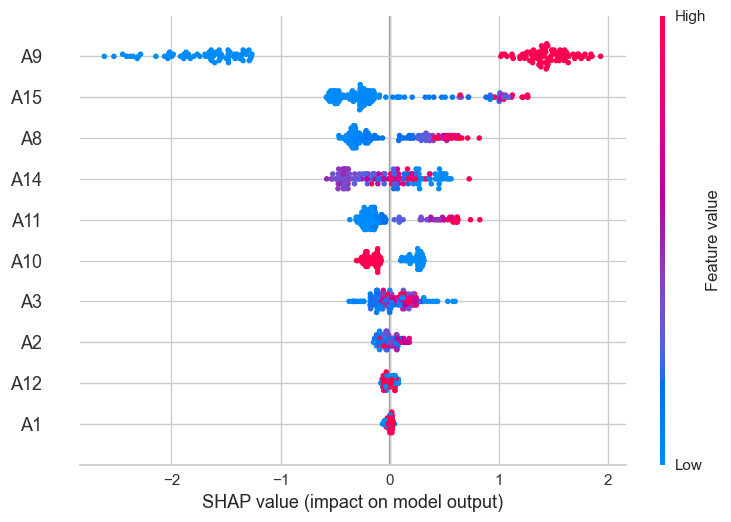

In [181]:
shap.summary_plot(shap_values, X_test)

**Empleando el criterio de importancia de cada variable por shap value**

Interpretación de la gráfica:

- En el gráfico, las características están ordenadas de arriba a abajo por su importancia, con A9 siendo la más importante y A1 la menos importante.
- El color de los puntos indica el valor de la característica: rojo para valores altos y azul para valores bajos.
- El color de los puntos junto con los valores SHAP indican si una característica aumenta o disminuye la probabilidad de aceptación
    - Valores positivos indican que la característica aumenta la probabilidad de aceptación de la solicitud de crédito
    - Valores negativos indican que la característica disminuye la probabilidad de la clase objetivo.
- La distancia de los puntos desde el eje central indica el grado de impacto. Cuanto más lejos del centro, mayor es el impacto de esa característica en la predicción.

Para A9:

- A9 tiene el mayor impacto en las predicciones del modelo.
- Los puntos rojos (valores altos de A9) están a la derecha, lo que indica que los valores altos de A9 aumentan la probabilidad de aceptación.
- Los puntos azules (valores bajos de A9) están a la izquierda, lo que indica que los valores bajos de A9 disminuyen la probabilidad de aceptación.

Para A15:

- A15 también tiene un impacto significativo.
- Los valores altos de A15 (puntos rojos) parecen estar asociados con una mayor probabilidad de aceptación.
- Los valores bajos de A15 (puntos azules) están asociados con una menor probabilidad de aceptación.

Para A8, A14:

- Estas características tienen un impacto moderado.
- Para A8, los valores altos tienden a aumentar la probabilidad de aceptación, mientras que los valores bajos tienden a disminuirla.
- Para A14, el impacto es más mezclado, con una distribución más dispersa de los valores SHAP.

La siguiente gráfica muestra el impacto promedio con respecto al target.

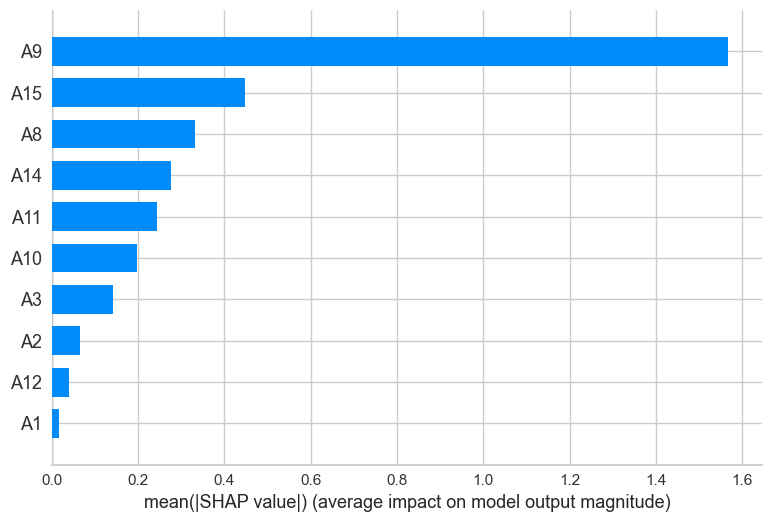

In [182]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Consideraciones y Recomendaciones

Consideraciones:

- Impacto Financiero: Dado que el principal objetivo es minimizar los falsos positivos para reducir el riesgo financiero, la especificidad es una métrica clave. Un valor de 71.11% es razonable, pero podría ser mejorado.
- Balance de Métricas: Si bien la especificidad es razonable, la precisión y la sensibilidad son moderadas, lo que indica que el modelo puede no ser óptimo en identificar correctamente tanto las solicitudes aceptadas como las rechazadas.
- Contexto del Negocio: Es importante considerar el contexto específico del negocio y los costos asociados con los errores. Si los falsos positivos tienen un costo significativamente mayor que los falsos negativos, enfocarse en mejorar la especificidad sería beneficioso.


Recomendaciones:
- Modelo Híbrido: Evaluar la posibilidad de combinar diferentes modelos o técnicas de ensamblado (ensemble) para mejorar las métricas clave.
- Tuning de Hiperparámetros: Realizar una optimización de hiperparámetros más exhaustiva para mejorar el rendimiento del modelo.
- Variables Adicionales: Si es posible, obtener más datos o características adicionales que puedan mejorar la capacidad del modelo para distinguir entre las clases.
